In [6]:
# !open .

In [7]:
# %load py_neo_quant_backbone.py
# %load py_neo_quant_backbone.py
# !open .
import pandas as pd
import numpy as np
import requests
import bs4
import time
import datetime
import matplotlib.pyplot as plt
from dateutil import parser
from matplotlib import font_manager, rc
from IPython.display import HTML
pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# %matplotlib inline



def make_code(x):
    x = str(x)
    code = '0' * (6-len(x)) + x
    if not code.startswith('A'):
        code = 'A' + code
    return code


def make_code2(x):
    x = str(x)
    return '0' * (6-len(x)) + x

# def get_all_company_info():
#     kospi = pd.read_excel('data/kospi.xls')
#     kosdaq = pd.read_excel('data/kosdaq.xls')
#     kospi['구분'] = '코스피'
#     kosdaq['구분'] = '코스닥'
#     companies = pd.concat([kospi, kosdaq])
#     companies = companies[['구분','종목코드','기업명']]
# #     companies['종목코드'] = companies['종목코드'].apply(modifyCompanyCode)
#     companies = companies.reset_index()
#     return companies

def company_apply_a_prefix(companies):
    old_index = pd.Series(companies.index)
    new_index = old_index.map(make_code)
    return companies.set_index(new_index)

def company_apply_no_prefix(companies):
    old_index = pd.Series(companies.index)
    new_index = old_index.map(make_code2)
    return companies.set_index(new_index)

def remove_a_from_company_code(company_df):
    code_list = []
    for code in company_df.index:
        code = code.replace('A','')
        code_list.append(code)
    return company_df.set_index(pd.Series(code_list))

def _get_firm_list_existing_in_price_df(firm_list, price_df):
    new_firm_list = []
    for code in firm_list:
        if code in price_df.columns:
            new_firm_list.append(code)
    return new_firm_list

def get_company_data(min_price=0):
    kospi = pd.read_excel('data/kospi.xls')
    kosdaq = pd.read_excel('data/kosdaq.xls')
    kospi['구분'] = '코스피'
    kosdaq['구분'] = '코스닥'
    companies = pd.concat([kospi, kosdaq], sort=False)
    companies = companies[['종목코드','기업명','구분','업종코드','업종','액면가(원)','상장주식수(주)', '자본금(원)']]
    companies['상장주식수(주)'] = companies['상장주식수(주)'].str.replace(',','').astype(int)
    companies['자본금(원)'] = companies['자본금(원)'].str.replace(',','').astype(int)
    companies['액면가(원)'] = companies['액면가(원)'].str.replace(',','').astype(float)
    companies = companies[companies['액면가(원)'] >= min_price]
    companies['액면가(원)'] = companies['액면가(원)'].astype(int)
    companies = companies.set_index('종목코드')
    companies = company_apply_a_prefix(companies)
    return companies

def get_price_data():
    price_path = r'data/price_data_2013.xlsx'
    price_df = pd.read_excel(price_path)
    price_df = price_df.set_index(price_df.columns[0])
#     price_df.columns = 'A' + price_df.columns 
    return price_df

def get_fs_data():
    fs_path = r'data/fs_data.xlsx'
    return get_finance_data(fs_path)

def get_fr_data():
    fr_path = r'data/fr_data.xlsx'
    return get_finance_data(fr_path)

def get_invest_data():
    invest_path = r'data/invest_data.xlsx'
    return get_finance_data(invest_path)

def get_company_df_from_total_capital(company_df, pct, start_date = None):
    company_df = add_price_info(company_df, start_date)
    company_df['시가총액'] = company_df['상장주식수(주)'] * company_df['price']
    return company_df.sort_values(by='시가총액', ascending=False)[:int(len(companies) * pct)]

def load_all_data():
    companies = get_company_data()
    fs_df = get_fs_data()
    fr_df = get_fr_data()
    iv_df = get_invest_data()
    prices = get_price_data()
    return companies, fs_df, fr_df, iv_df, prices 

# 액면가 1000원 이상 회사 리스트 가져와서 코드앞에 A 붙이기
# companies = get_company_info(1000)
# companies = apply_a_type_code(companies)

def filter_company(st_df, companies):
    new_company_list = []
    for num, code in enumerate(st_df.index):
        if code in companies.index:
            new_company_list.append(code)

    return st_df.loc[new_company_list]

# def _get_price_over_list(company_code_list, price_df, check_date=None, min_price = 0):
#     if check_date == None:
#         temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
#     else:
#         temp_df = pd.DataFrame({'price':price_df[company_code_list].loc[-1]})
#     temp_df = temp_df[temp_df['price'] > min_price]
#     return temp_df.index

def _get_price_over_code_list(company_code_list, price_df, min_price = 0, check_month=None):
    if check_month == None:
        temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
    else:
        if check_month in price_df.index:
            temp_df = pd.DataFrame({'price':price_df[company_code_list].loc[check_month].iloc[-1]})
        else:
            temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
    temp_df = temp_df[temp_df['price'] > min_price]
    return temp_df.index

def _add_company_info(st_df, company_df):
    return pd.merge(st_df, company_df, how='inner', left_index=True, right_index=True)

def _add_price_info(st_df, price_df, start_date = None):
    if start_date == None:
        temp_df = pd.DataFrame({'price':price_df[st_df.index].iloc[-1]}) 
    else:
        temp_df = pd.DataFrame({'price':price_df[st_df.index].loc[start_date:].iloc[0]}) 
    return pd.merge(st_df, temp_df, how='left', left_index=True, right_index=True)

# str 이나 list 를 전달한다.
def _get_company_code_list(company_name_list, company_df):
    code_list = []
    if isinstance(company_name_list, str):
        company_name_list = [company_name_list]
    for company_name in company_name_list:
        for num, name in enumerate(company_df['기업명']):
            if company_name in name:
                code_list.append({'code':company_df.index[num], 'name':name})
    return code_list

def _get_company_code(name, company_df):
    return company_df[company_df['기업명']==name].index[0]

def _get_company_name(company_code, company_df):
    return company_df.loc[company_code]['기업명']

def _show_chart(company_code, price_df, company_df, start_date, end_date, show_market_price=False, name=None):
    if isinstance(company_code, str):
        strategy_price = price_df[company_code][start_date:end_date]
        strategy_df = pd.DataFrame({'price':strategy_price})
        
        plt.figure(figsize=(10, 6))
        if name == None:
            name = _get_company_name(company_code, company_df)
        strategy_df['price'].plot(label=name)
        
        if show_market_price == True:
            if is_kospi(company_code):
                market_name = 'KOSPI'
            else:
                market_name = 'KOSDAQ'
            market_price = price_df[market_name][start_date:end_date]
            market_df = pd.DataFrame({'price':market_price})
            ratio = strategy_df.iloc[0]/market_df.iloc[0]
            market_df = market_df * ratio
            market_df['price'].plot(label=market_name)
        
        plt.legend()
        plt.show() 
    else:
        plt.rc('font', size=20)
        company_code_list = company_code
        strategy_price = price_df[company_code_list][start_date:end_date]
        num_row = int((len(company_code_list)-1)/2)+1
        plt.figure(figsize=(10*4, (num_row)*5))
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        for i, code in enumerate(company_code_list):
            ax = plt.subplot(num_row, 4, i+1)
            name = _get_company_name(code, company_df)
            ax.title.set_text(name + ' (' + str(code) + ')')
            ax.plot(strategy_price.index, strategy_price[code], color='black')

            if show_market_price == True:
                if is_kospi(code):
                    market_name = 'KOSPI'
                else:
                    market_name = 'KOSDAQ'
                market_price = price_df[market_name][start_date:end_date]
                market_df = pd.DataFrame({'price':market_price})
                ratio = strategy_price[code].iloc[0]/market_df.iloc[0]
                market_df = market_df * ratio
                ax.plot(market_df.index, market_df['price'], color='red')
        plt.show()

    
# def _show_chart_by_name(company_name, company_df, price_df, year_duration=1):
#     company_list = _get_company_code_list(company_name, company_df)
#     if len(company_list) == 0:
#         print('no company with name' + company_name)
#         return
#     code = company_list[0]['code']
#     name = company_list[0]['name']
#     _show_chart(code, company_df, price_df, year_duration, name) 
    
def _show_monthly_chart(company_code, company_df, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")
    
    first = True
    for year in range(int(start_year), int(end_year)+1):
        for month in range(1,13):
            year_month = "%d-%02d" % (year, month)
#             print(year_month)
            if year_month in price_df.index:
                temp_df = pd.DataFrame(price_df.loc[year_month].iloc[0]).T
                if first:
                    month_df = temp_df
                    first = False
                else:
                    month_df = pd.concat([month_df, temp_df], sort=False)

    strategy_df = pd.DataFrame({'price':month_df[company_code]})
    ma3 = strategy_df['price'].rolling(window=3).mean()
    strategy_df['ma3'] = ma3

#     plt.figure(figsize=(10, 6))
    name = _get_company_name(company_code, company_df)
#     strategy_df['price'].plot(label=name)

    plt.figure(figsize=(20, 12))
    
    plt.plot(strategy_df.index, strategy_df['price'], color='darkblue',linewidth=3.0)
    plt.plot(strategy_df.index, strategy_df['ma3'], color='red', label='ma3')

    plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show() 

    
def _show_multi_chart(company_code_list, price_df, company_df, start_date, end_date):
#     end_date = price_df.iloc[-1].name
#     start_date = end_date - datetime.timedelta(days=year_duration * 365)
    strategy_price = price_df[company_code_list][start_date:end_date]
    num_row = int((len(company_code_list)-1)/2)+1
    plt.figure(figsize=(10, num_row*5))
    for i, code in enumerate(company_code_list):
        ax = plt.subplot(num_row, 4, i+1)
        name = _get_company_name(code, company_df)
        ax.title.set_text(name)
        ax.plot(strategy_price.index, strategy_price[code])
    plt.show()


def _show_detail_chart(company_code, company_df, price_df, year_duration=1, name=None):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})
#     strategy_df
    ma5 = strategy_df['price'].rolling(window=5).mean()
    strategy_df['ma5'] = ma5
    ma10 = strategy_df['price'].rolling(window=10).mean()
    strategy_df['ma10'] = ma10
    ma20 = strategy_df['price'].rolling(window=20).mean()
    strategy_df['ma20'] = ma20
    ma60 = strategy_df['price'].rolling(window=60).mean()
    strategy_df['ma60'] = ma60
    ma120 = strategy_df['price'].rolling(window=120).mean()
    strategy_df['ma120'] = ma120
    plt.figure(figsize=(20, 12))
    # strategy_df['price'].plot(label=name)
    if name == None:
        name = company_code
    plt.plot(strategy_df.index, strategy_df['price'], color='darkblue',linewidth=3.0)
    plt.plot(strategy_df.index, strategy_df['ma5'], color='red', label='ma5')
    plt.plot(strategy_df.index, strategy_df['ma10'], color='blue', label='ma10')
    plt.plot(strategy_df.index, strategy_df['ma20'], color='green', label='ma20')
    plt.plot(strategy_df.index, strategy_df['ma60'], color='cyan', label='ma60')
    plt.plot(strategy_df.index, strategy_df['ma120'], color='yellow', label='ma120')
    plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show() 
    


def _show_detail_chart_by_name(company_name, company_df, price_df, year_duration=1):
    company_list = _get_company_code_list(company_name, company_df)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
    code = company_list[0]['code']
    name = company_list[0]['name']
    _show_detail_chart(code, company_df, price_df, year_duration, name)    
    
    
def _get_maximum_earning_rate(price_df, company_df, year_duration=1, min_price=0, min_profit=0, type='all'):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    
    strategy_price = price_df[start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    
    last_price = strategy_price.iloc[-1]
    first_price = strategy_price.iloc[0]
    
    price_diff_df = pd.DataFrame({first_price.name:first_price, last_price.name:last_price})
    price_diff_df = price_diff_df[price_diff_df[last_price.name] > min_price]
    
    price_diff_df['diff'] = price_diff_df[last_price.name] - price_diff_df[first_price.name]
#     price_diff_df = price_diff_df[price_diff_df['diff'] > 0]
    
    # price_diff_df['ratio'] = price_diff_df['diff'] / price_diff_df[first_price.name]
    price_diff_df['ratio'] = ((price_diff_df[last_price.name] / price_diff_df[first_price.name]) - 1) * 100
    price_diff_df['ratio'] = price_diff_df['ratio'].astype(int)
    
    price_diff_df = price_diff_df[price_diff_df['ratio'] > min_profit]
    
    price_diff_df = price_diff_df.sort_values(by='ratio', ascending=False)
    
    price_diff_df = _add_company_info(price_diff_df, company_df)
    
    if type == 'kospi':
        price_diff_df = get_kospi_list(price_diff_df)
    elif type == 'kosdaq':
        price_diff_df = get_kosdaq_list(price_diff_df)
        
    return price_diff_df


def _show_earning_chart(code_list, price_df, year_duration=1, initial_money=100000000):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    st_backtest = _backtest_with_code_list(code_list, price_df, start_date, end_date, initial_money)
    plt.figure(figsize=(10, 6))
    st_backtest['total_change_rate'].plot()
    plt.show()
    
def _show_company_info(company_code_list, company_df, price_df):
    firm_df = company_df.loc[company_code_list]
    firm_df = _add_price_info(firm_df, price_df)
    firm_df['fs_info'] = firm_df.index
    firm_df['fs_info'] = firm_df['fs_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=103&stkGb=701&gicode={0}" target="_blank">fs</a>'.format(x))
    firm_df['fr_info'] = firm_df.index
    firm_df['fr_info'] = firm_df['fr_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_FinanceRatio.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=104&stkGb=701&gicode={0}" target="_blank">fr</a>'.format(x))
    firm_df['iv_info'] = firm_df.index
    firm_df['iv_info'] = firm_df['iv_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_Invest.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=105&stkGb=701&gicode={0}" target="_blank">iv</a>'.format(x))
    firm_df['chart'] = firm_df.index
    firm_df['chart'] = firm_df['chart'].apply(lambda x: x.replace('A',''))
    firm_df['chart'] = firm_df['chart'].apply(lambda x: '<a href="https://finance.naver.com/item/fchart.nhn?code={0}" target="_blank">chart</a>'.format(x))
    return HTML(firm_df.to_html(escape=False))

def _show_company_info_by_name(firm_name, company_df):
    company_list = _get_company_code_list(firm_name, company_df)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
#     company_list
    code_list = []
    for company in company_list:
        code_list.append(company['code'])
    return _show_company_info(code_list, companies)

def _show_earning_rate(company_code_list, company_df, price_df, year_duration=1):
    company_selected = companies.loc[company_code_list]

    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    
    strategy_price = price_df[company_code_list][start_date:end_date]
    strategy_price = strategy_price.dropna()
    strategy_price = strategy_price.fillna(method='bfill')
    last_price = strategy_price.iloc[-1]
    first_price = strategy_price.iloc[0]

    company_selected['profit'] = ((last_price/first_price - 1) * 100).astype(int)
    company_selected['profit'] = company_selected['profit'].astype(str) + ' %'
    return company_selected

def _show_earning_rate_by_name(firm_name, company_df, price_df, year_duration=1):
    company_list = _get_company_code_list(firm_name, company_df)
    if len(company_list) == 0:
        return "No Company with name : " + firm_name
    
    code_list = []
    for company in company_list:
        code_list.append(company['code'])

    return _show_earning_rate(code_list, company_df, price_df, year_duration)


def get_vaild_code_from_price_df(code_list, price_df):
    new_code_list = []
    for code in code_list:
        if code in price_df.columns:
            new_code_list.append(code)
    return new_code_list        

def _show_business_trend(company_df, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    company_df['업종코드'] = company_df['업종코드'].astype(str)
    company_df['업종구분'] = company_df['업종코드'] + ' (' + company_df['업종'] + ')'
    all_busi = company_df['업종구분'].unique()
    busi_list = []
    for busi_name in all_busi:
        temp_list = company_df[company_df['업종구분'] == busi_name]
        busi_list.append({'name':busi_name + ' - ' + str(len(temp_list)),'list':temp_list.index})

    for i, busi in enumerate(busi_list):
        busi_name = busi['name']
        busi_code_list = busi['list']
        strategy_price = price_df[get_vaild_code_from_price_df(busi_code_list, price_df)][start_date:end_date]
        strategy_price.fillna(method='bfill')
        busi_earning = strategy_price.sum(axis=1)
        temp_df = pd.DataFrame({busi_name:busi_earning})
        if i == 0:
            total_busi_earning = temp_df
        else:
            total_busi_earning = pd.merge(total_busi_earning, temp_df, how='outer', left_index=True, right_index=True)
    num_row = int((len(total_busi_earning.columns)-1)/4)+1
    plt.figure(figsize=(6*4, num_row*6))
    for i, busi in enumerate(total_busi_earning.columns):
        ax = plt.subplot(num_row, 4, i+1)
        ax.title.set_text(busi)
        ax.plot(total_busi_earning.index, total_busi_earning[busi])
    plt.show()    
    
def get_company_list_from_business_code(busi_code, company_df):
    return company_df[company_df['업종코드'] == busi_code].index





def fetch_prices(compay_code_list, timeframe, count):
    for num, code in enumerate(compay_code_list):
        try:
            print(num, code)
            time.sleep(1)
            try:
                price_df = make_price_dataframe(code, timeframe, count)
            except requests.exceptions.Timeout:
                time.sleep(60)
                price_df = make_price_dataframe(code, timeframe, count)
            if num == 0 :
                total_price = price_df
            else:
                total_price = pd.merge(total_price, price_df, how='outer', right_index=True, left_index=True)
        except ValueError:
            continue
        except KeyError:
            continue
    return total_price





# 기존 price dataframe 을 최신 가격으로 업데이트.
# ex) prices_update = update_prices(companies, prices, '10') 
# 기존 price 와 신규 price 의 차이 비교
# prices_update.merge(prices,indicator = True, left_index=True, right_index=True, how='outer').loc[lambda x : x['_merge']!='both']
def update_origin_price_df(origin_price_df, code, count):
    origin_prices = origin_price_df
    price_df = make_price_dataframe(code, 'day', count)
    price_df.index = pd.to_datetime(price_df.index)
    price_df[code] = price_df[code].astype(float)
    price_df_origin = pd.DataFrame({code:origin_prices[code]}) 
    new_price_df = pd.concat([price_df_origin, price_df], sort=False)
    new_price_df = new_price_df.loc[~new_price_df.index.duplicated(keep='last')]
    origin_prices = origin_prices.drop(code, axis=1)
    origin_prices = pd.merge(origin_prices, new_price_df, left_index=True, right_index=True, how='outer')
    return origin_prices
    
def update_prices(company_df, origin_price_df, count):
    origin_prices = origin_price_df
    for num, code in enumerate(company_df.index):
        try:
            print(num, code)
            time.sleep(1)
            try:
                origin_prices = update_origin_price_df(origin_prices, code, count)
            except requests.exceptions.Timeout:
                time.sleep(60)
                origin_prices = update_origin_price_df(origin_prices, code, count)
        except ValueError:
            continue
        except KeyError:
            continue
    return origin_prices

# [코드 3.15] 재무제표 데이터를 가져와 데이터프레임으로 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_fs_dataframe(firm_code):
    fs_url = 'https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=103&stkGb=701&gicode=' + firm_code
    fs_page = requests.get(fs_url)
    fs_tables = pd.read_html(fs_page.text)
    
    temp_df = fs_tables[0]
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df[temp_df.columns[:4]]
    temp_df = temp_df.loc[['매출액', '매출원가', '영업이익', '당기순이익', '매출총이익']]

    temp_df2 = fs_tables[2]
    temp_df2 = temp_df2.set_index(temp_df2.columns[0])
    temp_df2 = temp_df2.loc[['자산', '부채', '자본']]

    temp_df3 = fs_tables[4]
    temp_df3 = temp_df3.set_index(temp_df3.columns[0])
    temp_df3 = temp_df3.loc[['영업활동으로인한현금흐름']]

    fs_df = pd.concat([temp_df, temp_df2, temp_df3], sort=False)
    
    return fs_df

# [코드 3.19] 데이터프레임 형태 바꾸기 코드 함수화 (CH3. 데이터 수집하기.ipynb)

def change_df(firm_code, dataframe):
    for num, col in enumerate(dataframe.columns):
        temp_df = pd.DataFrame({firm_code : dataframe[col]})
        temp_df = temp_df.T
        temp_df.columns = [[col]*len(dataframe), temp_df.columns]
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.merge(total_df, temp_df, how='outer', left_index=True, right_index=True)    
    
    return total_df

# [코드 3.21] 재무 비율 데이터프레임을 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_fr_dataframe(firm_code):
    fr_url = 'https://comp.fnguide.com/SVO2/asp/SVD_FinanceRatio.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=104&stkGb=701&gicode=' + firm_code
    fr_page = requests.get(fr_url)
    fr_tables = pd.read_html(fr_page.text)
    
    temp_df = fr_tables[0]
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df.loc[['유동비율계산에 참여한 계정 펼치기',
                           '부채비율계산에 참여한 계정 펼치기',
                           '영업이익증가율계산에 참여한 계정 펼치기',
                           'ROA계산에 참여한 계정 펼치기',
                           'ROIC계산에 참여한 계정 펼치기']]
    temp_df.index = ['유동비율', '부채비율', '영업이익률', 'ROA', 'ROIC']
    return temp_df

# [코드 3.23] 투자지표 데이터프레임을 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_invest_dataframe(firm_code):
    invest_url = 'https://comp.fnguide.com/SVO2/asp/SVD_Invest.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=105&stkGb=701&gicode=' + firm_code
    invest_page = requests.get(invest_url)
    invest_tables = pd.read_html(invest_page.text)
    temp_df = invest_tables[1]
    
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df.loc[['PER계산에 참여한 계정 펼치기',
                       'PCR계산에 참여한 계정 펼치기',
                       'PSR계산에 참여한 계정 펼치기',
                       'PBR계산에 참여한 계정 펼치기',
                      '총현금흐름']]
    temp_df.index = ['PER', 'PCR', 'PSR', 'PBR', '총현금흐름']
    return temp_df

#  [코드 3.40] 가격을 가져와 데이터프레임 만드는 함수 (CH3. 데이터 수집하기 2.ipynb)

def make_price_dataframe(company_code, timeframe, count):
    request_code = company_code
    if request_code.startswith('A'):
        request_code = request_code.replace('A','')
    url = 'https://fchart.stock.naver.com/sise.nhn?requestType=0'
    price_url = url + '&symbol=' + request_code + '&timeframe=' + timeframe + '&count=' + str(count)
    price_data = requests.get(price_url)
    price_data_bs = bs4.BeautifulSoup(price_data.text, 'lxml')
    item_list = price_data_bs.find_all('item')
    
    date_list = []
    price_list = []
    for item in item_list:
        temp_data = item['data']
        datas = temp_data.split('|')
        date_list.append(datas[0])
        price_list.append(datas[4])

    price_df = pd.DataFrame({company_code:price_list}, index=date_list)
    
    return price_df

def _add_market_price_info(price_df):
    kosdaq_df = make_price_dataframe('KOSDAQ', 'day', '6000')
    kosdaq_df.index = pd.to_datetime(kosdaq_df.index)
    kosdaq_df = kosdaq_df[price_df.iloc[0].name:price_df.iloc[-1].name]
    total_df = pd.merge(kosdaq_df, price_df, left_index=True, right_index=True, how='inner')

    kospi_df = make_price_dataframe('KOSPI', 'day', '6000')
    kospi_df.index = pd.to_datetime(kospi_df.index)
    kospi_df = kospi_df[price_df.iloc[0].name:price_df.iloc[-1].name]
    total_df = pd.merge(kospi_df, total_df, left_index=True, right_index=True, how='inner')
    
    return total_df


#  [코드 4.6] 재무 데이터 전처리하는 함수 (CH4. 전략 구현하기.ipynb)

def get_finance_data(path):
    data_path = path
    raw_data = pd.read_excel(data_path)
    raw_data = raw_data.set_index(raw_data.columns[0])
    big_col = list(raw_data.columns)
    small_col = list(raw_data.iloc[0])
    
    new_big_col = []
    for num, col in enumerate(big_col):
        if 'Unnamed' in col:
            new_big_col.append(new_big_col[num-1])
        else:
            new_big_col.append(big_col[num])
            
    raw_data.columns = [new_big_col, small_col]
    clean_df = raw_data.loc[ raw_data.index.dropna() ]
    
    return clean_df

def check_IFRS(x):
    if x == 'N/A(IFRS)':
        return np.NaN
    else:
        return x

#  [코드 4.14] PER기준으로 오름차순으로 정렬하여 주는 함수 (CH4. 전략 구현하기.ipynb)

def _low_per(invest_df, index_date, num):
    invest_df[(index_date, 'PER')] = pd.to_numeric(invest_df[(index_date, 'PER')])
    per_sorted = invest_df.sort_values(by=(index_date, 'PER'))
    return per_sorted[index_date][:num]

#  [코드 4.15] ROA기준으로 내림차순으로 정렬하여 주는 함수 (CH4. 전략 구현하기.ipynb)

def high_roa(fr_df, index_date, num):
    fr_df[(index_date, 'ROA')] = fr_df[(index_date, 'ROA')].apply(check_IFRS)
    fr_df[(index_date, 'ROA')] = pd.to_numeric(fr_df[(index_date, 'ROA')] )
    sorted_roa = fr_df.sort_values(by=(index_date, 'ROA'), ascending=False)
    return sorted_roa[index_date][:num]

def _low_pbr(invest_df, index_date, num):
    invest_df[(index_date, 'PBR')] = pd.to_numeric(invest_df[(index_date, 'PBR')])
    pbr_sorted = invest_df.sort_values(by=(index_date, 'PBR'))
    return pbr_sorted[index_date][:num]

def _high_gpa(fs_df, index_date, num):
    gpa = fs_df[index_date]
    gpa['GPA'] = gpa['매출총이익']/gpa['자산']
    gpa_sorted = gpa.sort_values(by='GPA', ascending=False)
    return gpa_sorted[:num]

#  [코드 4.22] 마법공식 함수로 만들기 (CH4. 전략 구현하기.ipynb)

def magic_formula(fr_df, invest_df, index_date, num):
    per = low_per(invest_df, index_date, None)
    roa = high_roa(fr_df, index_date, None)
    per['per순위'] = per['PER'].rank()
    roa['roa순위'] = roa['ROA'].rank(ascending=False)
    magic = pd.merge(per, roa, how='outer', left_index=True, right_index=True)
    magic['마법공식 순위'] = (magic['per순위'] + magic['roa순위']).rank().sort_values()
    magic = magic.sort_values(by='마법공식 순위')
    return magic[:num]

#  [코드 4.23] 저평가 지수를 기준으로 정렬하여 순위 만들어 주는 함수 (CH4. 전략 구현하기.ipynb)

def get_value_rank(invest_df, value_type, index_date, num):
    invest_df[(index_date,  value_type)] = pd.to_numeric(invest_df[(index_date,  value_type)])
    value_sorted = invest_df.sort_values(by=(index_date,  value_type))[index_date]
    value_sorted[  value_type + '순위'] = value_sorted[value_type].rank()
    return value_sorted[[value_type, value_type + '순위']][:num]

#  [코드 4.25] 저평가 지표 조합 함수 (CH4. 전략 구현하기.ipynb)

def make_value_combo(value_list, invest_df, index_date, num):
    
    for i, value in enumerate(value_list):
        temp_df = get_value_rank(invest_df, value, index_date, None)
        if i == 0:
            value_combo_df = temp_df
            rank_combo = temp_df[value + '순위']
        else:
            value_combo_df = pd.merge(value_combo_df, temp_df, how='outer', left_index=True, right_index=True)
            rank_combo = rank_combo + temp_df[value + '순위']
    
    value_combo_df['종합순위'] = rank_combo.rank()
    value_combo_df = value_combo_df.sort_values(by='종합순위')
    
    return value_combo_df[:num]

#  [코드 4.29] F-score 함수(CH4. 전략 구현하기.ipynb)

def get_fscore(fs_df, index_date, num):
    fscore_df = fs_df[index_date]
    fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
    fscore_df['영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > 0
    fscore_df['더큰영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > fscore_df['당기순이익']
    fscore_df['종합점수'] = fscore_df[['당기순이익점수', '영업활동점수', '더큰영업활동점수']].sum(axis=1)
    fscore_df = fscore_df[fscore_df['종합점수'] == 3]
    return fscore_df[:num]

#  [코드 4.34] 모멘텀 데이터프레임 만들기 함수화 (CH4. 전략 구현하기.ipynb)

def get_momentum_rank(price_df, index_date, date_range, num):
    momentum_df = pd.DataFrame(price_df.pct_change(date_range).loc[index_date])
    momentum_df.columns = ['모멘텀']
    momentum_df['모멘텀순위'] = momentum_df['모멘텀'].rank(ascending=False)
    momentum_df = momentum_df.sort_values(by='모멘텀순위')
    return momentum_df[:num]

#  [코드 4.39] 저평가 + Fscore 함수화 (CH4. 전략 구현하기.ipynb)

def get_value_quality(invest_df, fs_df, index_date, num):
    value = make_value_combo(['PER', 'PBR', 'PSR', 'PCR'], invest_df, index_date, None)
    quality = get_fscore(fs_df, index_date, None)
    value_quality = pd.merge(value, quality, how='outer', left_index=True, right_index=True)
    value_quality_filtered = value_quality[value_quality['종합점수'] == 3]
    vq_df = value_quality_filtered.sort_values(by='종합순위')
    return vq_df[:num]

#  [코드 5.12] 백테스트 함수 버젼1 (Ch5. 백테스트.ipynb)


def backtest_beta(price_df, strategy_df, start_date, end_date, initial_money):

    code_list = []
    for code in strategy_df.index:
#         code_list.append(code.replace('A',''))
        code_list.append(code)

    strategy_price = price_df[code_list][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    
    pf_stock_num = {}
    stock_amount = 0
    stock_pf = 0
    each_money = initial_money / len(strategy_df)
    for code in strategy_price.columns:
        temp = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = temp
        stock_amount = stock_amount + temp * strategy_price[code][0]
        stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

    cash_amount = initial_money - stock_amount

    backtest_df = pd.DataFrame({'주식포트폴리오':stock_pf})
    backtest_df['현금포트폴리오'] = [cash_amount] * len(backtest_df)
    backtest_df['종합포트폴리오'] = backtest_df['주식포트폴리오'] + backtest_df['현금포트폴리오']
    backtest_df['일변화율'] = backtest_df['종합포트폴리오'].pct_change()
    backtest_df['총변화율'] = backtest_df['종합포트폴리오']/initial_money - 1
    
    return backtest_df

# def backtest_with_code_list(price_df, code_list_to_test, start_date, end_date, initial_money):

#     code_list = []
#     for code in code_list_to_test:
# #         code_list.append(code.replace('A',''))
#         code_list.append(code)

#     strategy_price = price_df[code_list][start_date:end_date]
#     strategy_price = strategy_price.fillna(method='bfill')
    
#     pf_stock_num = {}
#     stock_amount = 0
#     stock_pf = 0
#     each_money = initial_money / len(code_list)
#     for code in strategy_price.columns:
#         temp = int( each_money / strategy_price[code][0] )
#         pf_stock_num[code] = temp
#         stock_amount = stock_amount + temp * strategy_price[code][0]
#         stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

#     cash_amount = initial_money - stock_amount

#     backtest_df = pd.DataFrame({'주식포트폴리오':stock_pf})
#     backtest_df['현금포트폴리오'] = [cash_amount] * len(backtest_df)
#     backtest_df['종합포트폴리오'] = backtest_df['주식포트폴리오'] + backtest_df['현금포트폴리오']
#     backtest_df['일변화율'] = backtest_df['종합포트폴리오'].pct_change()
#     backtest_df['총변화율'] = backtest_df['종합포트폴리오']/initial_money - 1
    
#     return backtest_df

def _backtest_with_code_list(code_list, price_df, start_date, end_date, initial_money):
    if end_date == None:
        end_date = end_date = prices.iloc[-1].name
    strategy_price = price_df[code_list][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    strategy_price = strategy_price.dropna(axis=1)

    pf_stock_num = {}
    stock_amount = 0
    stock_pf = 0
    each_money = initial_money / len(code_list)
    for code in strategy_price.columns:
        temp = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = temp
        stock_amount = stock_amount + temp * strategy_price[code][0]
        stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

    cash_amount = initial_money - stock_amount

    backtest_df = pd.DataFrame({'stock_portfolio':stock_pf})
    backtest_df['cash_portfolio'] = [cash_amount] * len(backtest_df)
    backtest_df['total_portfolio'] = backtest_df['stock_portfolio'] + backtest_df['cash_portfolio']
    backtest_df['day_change_rate'] = backtest_df['total_portfolio'].pct_change()
    backtest_df['total_change_rate'] = backtest_df['total_portfolio']/initial_money - 1

    return backtest_df

#  [코드 5.16] 해당 날짜에 가격이 없으면 투자 관련 데이터에서 해당 종목 없애는 함수 (Ch5. 백테스트.ipynb)

def select_code_by_price(price_df, data_df, start_date):
    new_code_list = []
    for code in price_df[start_date].iloc[0].dropna().index:
        new_code_list.append(code)
        
    selected_df =  data_df.loc[new_code_list]
    return selected_df

# [코드 5.24] 백테스트 시작날짜가 주어지면 전략 기준 날짜를 계산하는 함수 (Ch5. 백테스트.ipynb)

def get_strategy_date(start_date):
    temp_year = int(start_date.split('-')[0])
    temp_month = start_date.split('-')[1]
    if temp_month in '1 2 3 4 5'.split(' '):
        strategy_date = str(temp_year - 2) + '/12'
    else:
        strategy_date = str(temp_year - 1) + '/12'
    return strategy_date


# [코드 5.32] 리밸런싱 백테스트 함수화 (Ch5. 백테스트.ipynb)

def backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, invest_df, num, value_type=None, value_list=None, date_range=None):
    
    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    total_df = 0
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_date.split('-')[1]
        this_term_end = str(temp+1) + '-' + start_date.split('-')[1]
        strategy_date = get_strategy_date(this_term_start)
        
        if strategy.__name__ == 'high_roa':
            st_df = strategy(select_code_by_price(price_df, fr_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'magic_formula':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_value_rank':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), value_type, strategy_date, num)
        elif strategy.__name__ == 'make_value_combo':
            st_df = strategy(value_list, select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_fscore':
            st_df = strategy(select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_momentum_rank':
            st_df = strategy(price_df, price_df[this_term_start].index[0] , date_range, num)
        elif strategy.__name__ == 'get_value_quality':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), 
                             select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        
        backtest = backtest_beta(price_df, st_df, this_term_start, this_term_end, initial_money)
        temp_end = backtest[this_term_end].index[0]
        backtest = backtest[:temp_end]
        initial_money =  backtest['종합포트폴리오'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df[:-1], backtest], sort=False)

    total_df ['일변화율'] = total_df ['종합포트폴리오'].pct_change()
    total_df ['총변화율'] = total_df ['종합포트폴리오']/ total_df ['종합포트폴리오'][0] - 1
    
    return total_df


# [코드 5.40] MDD 함수화 (Ch5. 백테스트.ipynb)

def get_mdd(back_test_df):
    max_list = [0]
    mdd_list = [0]

    for i in back_test_df.index[1:]:
        max_list.append(back_test_df['총변화율'][:i].max())
        if max_list[-1] > max_list[-2]:
            mdd_list.append(0)
        else:
            mdd_list.append(min(back_test_df['총변화율'][i] - max_list[-1], mdd_list[-1])   )

    back_test_df['max'] = max_list
    back_test_df['MDD'] = mdd_list
    
    return back_test_df



# company_code = get_company_code('GS')
# st_df = get_price_df(company_code, prices, 1)
# st_df = get_monthly_price_df(company_code, prices, 1)
# st_df = get_weekly_price_df(company_code, prices, 1)
# st_df = add_moving_avererge(st_df, 5)
# st_df = add_exponential_moving_average(st_df, 5)
# st_df = add_weighted_moving_average(st_df, 5)
# show_price_chart(st_df, 'GS')

def weighted_mean(weightArray):
    def inner(x):
        return (weightArray*x).mean()
    return inner

def add_weighted_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    t = [v for v in np.arange(1, n+1)]
    sumv = sum(t)/n
    wts = np.array(t)/sumv
    wMov = st_df['price'].rolling(n).apply(weighted_mean(wts), raw=True)
    st_df['wMov' + str(n)] = wMov
    return st_df

def add_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    Mov = st_df['price'].rolling(window=n).mean()
    st_df['Mov'+str(n)] = Mov
    return st_df

def add_exponential_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    eMov = st_df['price'].ewm(span=n).mean()
    st_df['eMov'+str(n)] = eMov
    return st_df


def get_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})
    return strategy_df

def get_weekly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})

    first_week_day_list = []

    prev_weekday_num = 5
    for date in strategy_df.index:
        weekday_num = date.weekday()
        if weekday_num < prev_weekday_num:
            first_week_day_list.append(date)
        prev_weekday_num = weekday_num

    weekly_price_df = strategy_df.loc[first_week_day_list]
    weekly_price_df = pd.DataFrame({'price':weekly_price_df})

    return weekly_price_df

def get_monthly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")

    first = True
    for year in range(int(start_year), int(end_year)+1):
        for month in range(1,13):
            year_month = "%d-%02d" % (year, month)
            if year_month in strategy_df.index:
                temp_df = pd.DataFrame(strategy_df.loc[year_month].iloc[0]).T
                if first:
                    month_df = temp_df
                    first = False
                else:
                    month_df = pd.concat([month_df, temp_df], sort=False)
    return month_df

def get_yearly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")

    first_year_day_list = []

    for year in range(int(start_year), int(end_year)+1):
        if str(year) in strategy_price.index:
            first_day_of_year = strategy_price.loc[str(year)].index[0]
            first_year_day_list.append(first_day_of_year)
    first_year_day_list.append(end_date)
    yearly_price_df = strategy_price.loc[first_year_day_list]
    yearly_price_df = pd.DataFrame({'price':yearly_price_df})
    return yearly_price_df

def show_price_chart(st_df, name=None):
    plt.figure(figsize=(40, 20))
    plt.rcParams.update({'font.size': 22})
    plt.plot(st_df.index, st_df['price'], linewidth=3.0)
    for column in st_df.columns[1:len(st_df.columns)+1]:
        plt.plot(st_df.index, st_df[column], label=column)
    if name != None:
        plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    # plt.grid()
    plt.show()

def show_general_chart(st_df, name_to_draw, label=None):
    plt.figure(figsize=(40, 20))
    plt.rcParams.update({'font.size': 22})
    if label == None:
        label = name_to_draw
    plt.plot(st_df.index, st_df[name_to_draw], linewidth=3.0, label=label)
    plt.xlabel("duration")
    plt.ylabel(name_to_draw)
    plt.legend(loc='upper right')
    # plt.grid()
    plt.show()
    


























In [8]:
# %load py_neo_quant_basic.py
# %load py_neo_quant_basic.py
import pandas as pd
import numpy as np
# import requests
# import bs4
# import time
# import datetime
# import matplotlib.pyplot as plt
# from dateutil import parser
# from matplotlib import font_manager, rc
# from IPython.display import HTML
# pd.set_option('display.max_colwidth', -1)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
%matplotlib inline

my_portfolio = ['동국제강', '포스코','현대건설','GS건설','한국조선해양','OCI','미래에셋대우','삼성증권','삼성중공업','키움증권','LG화학']
my_portfolio_code_list = ['A001230','A005490','A000720','A006360','A009540','A010060','A006800','A016360','A010140','A039490','A051910']

# default loading
# companies, fs_df, fr_df, iv_df, prices = load_all_data()

########################## Basic API ################################

def iterable(obj):
    try:
        iterator = iter(obj)
    except TypeError:
        return False
    else:
        return True


def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def is_kospi(company_code):
    if company_code in companies.index:
        return companies.loc[company_code]['구분'] == '코스피'
    elif company_code == 'KOSPI':
        return True
    else:
        return False

def get_company_name(company_code):    
    return _get_company_name(company_code, companies)
    
def get_company_code(company_name):
    return _get_company_code(company_name, companies)

# str 이나 list 를 전달한다.
def get_company_code_list(company_name_list):
    return _get_company_code_list(company_name_list, companies)


########################## API ################################

def get_firm_list_existing_in_price_df(firm_list):
    return _get_firm_list_existing_in_price_df(firm_list, prices)

def show_earning_rate(company_code_list, year_duration=1):
    return _show_earning_rate(company_code_list, companies, prices, year_duration)

def show_chart_by_name(company_name, days=365):
    company_list = _get_company_code_list(company_name, companies)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
    code = company_list[0]['code']
    name = company_list[0]['name']
    show_chart(code, days) 

def show_chart(company_code, days=365, show_market_price=False):
    end_date = prices.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=days)
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)
    
def show_start_duration_chart(company_code, start_date, days=None, show_market_price=False):
    if days == None:
        end_date = prices.iloc[-1].name
    else:
        end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)

def show_start_end_chart(company_code, start_date, end_date=None, show_market_price=False):
    if end_date == None:
        end_date = prices.iloc[-1].name
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)    
    
def show_monthly_chart(company_code, year_duration=1):
    _show_monthly_chart(company_code, companies, prices, year_duration)
    
def show_detail_chart_by_name(company_name, year_duration=1):
    _show_detail_chart_by_name(company_name, companies, prices, year_duration)
    
# def show_multi_chart(company_code_list, days=365):
#     end_date = prices.iloc[-1].name
#     start_date = end_date - datetime.timedelta(days=days)
#     _show_chart(company_code_list, prices, companies, start_date, end_date)

# def show_multi_start_duration_chart(company_code_list, start_date, days=None):
#     if days == None:
#         end_date = prices.iloc[-1].name
#     else:
#         end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
#     _show_multi_chart(company_code_list, prices, companies, start_date, end_date)

def show_earning_rate_by_name(firm_name, year_duration=1):
    return _show_earning_rate_by_name(firm_name, companies, prices, year_duration)

def show_earning_chart(code_list, year_duration=1, initial_money=100000000):
    _show_earning_chart(code_list, prices, year_duration, initial_money)

def show_company_info(company_code_list):
    return _show_company_info(company_code_list, companies, prices)
    
def show_company_info_by_name(firm_name):
    return _show_company_info_by_name(firm_name, companies)
    
def add_company_info(st_df):
    return _add_company_info(st_df, companies)

def add_price_info(st_df, start_date = None):
    return _add_price_info(st_df, prices, start_date)

def get_kospi_list(company_df):
    return company_df[company_df['구분']=='코스피']

def get_kosdaq_list(company_df):
    return company_df[company_df['구분']=='코스닥']
    
def get_price_over_code_list(company_code_list, min_price = 0, check_month=None):
    return _get_price_over_code_list(company_code_list, prices, min_price, check_month)    

def get_price_over_list(company_df, min_price = 0, check_month=None):
    return company_df[company_df['price'] > min_price]

def low_per(index_date, num=None):
    return _low_per(iv_df, index_date, num)

def low_pbr(index_date, num = None):
    return _low_pbr(iv_df, index_date, num)

def high_gpa(index_date, num = None):
    return _high_gpa(fs_df, index_date, num)

def qp_formula(index_date, num = None):
    pbr = low_pbr(index_date, num)
    gpa = high_gpa(index_date, num)
    pbr['PBR_RANK'] = pbr['PBR'].rank()
    gpa['GPA_RANK'] = gpa['GPA'].rank(ascending=False)
    qp = pd.merge(pbr, gpa, how='outer', left_index=True, right_index=True)
    qp['MAGIC_RANK'] = (qp['PBR_RANK'] + qp['GPA_RANK']).rank()
    qp = qp.sort_values(by='MAGIC_RANK')
    return qp[:num]

########################## Strategy API ################################
    
    
def show_business_trend(year_duration=1):
    _show_business_trend(companies, prices, year_duration)
    
# get_maximum_earning_rate(5, 5000, 100, 'kospi')    
def get_maximum_earning_rate(year_duration=1, min_price=0, min_profit=0, type='all'):
    return _get_maximum_earning_rate(prices, companies, year_duration, min_price, min_profit, type)
    
def backtest_with_code_list(code_list, start_date, end_date=None, initial_money=100000000):
#     if days == None:
#         end_date = prices.iloc[-1].name
#     else:
#         end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
    return _backtest_with_code_list(code_list, prices, start_date, end_date, initial_money)       
    
    
def low_per_backtest(start_date='2016-6', end_date=None, stock_num=6, min_price=0, division='kospi', initial_money=100000000):

    price_df = prices

    if end_date == None:
        end_date = price_df.iloc[-1].name
        end_date = end_date.strftime('%Y-%m-%d')

    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    start_month = start_date.split('-')[1]
    date_month_ago = pd.to_datetime(start_date) - datetime.timedelta(days=30)
    date_month_ago = date_month_ago.strftime('%Y-%m-%d')
    end_month = date_month_ago.split('-')[1]

    total_df = 0
    total_money = initial_money
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_month
        if end_month == '12':
            this_term_end = str(temp) + '-' + end_month
        else:
            this_term_end = str(temp+1) + '-' + end_month

        strategy_date = get_strategy_date(this_term_start)
        per = _low_per(iv_df, strategy_date, None)

        temp_index = price_df[this_term_start].iloc[0].dropna().index
        final_index = intersection(per.index, temp_index)
        per = per.loc[final_index]

        per = add_price_info(per)
        per = add_company_info(per)
        if division == 'kospi':
            per = get_kospi_list(per)
        elif division == 'kosdaq':
            per = get_kosdaq_list(per)
        if min_price > 0:
            temp_index = get_price_over_code_list(per.index, min_price, this_term_start)
            per = per.loc[temp_index]

        backtest = backtest_with_code_list(per.index[:stock_num], this_term_start, this_term_end, total_money)
        total_money = backtest['total_portfolio'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df, backtest], sort=False)

    total_df ['day_change_rate'] = total_df ['total_portfolio'].pct_change()
    total_df ['total_change_rate'] = total_df ['total_portfolio']/ total_df ['total_portfolio'][0] - 1

    return total_df
        

def get_company_list_beated_market_profit(price_df, start_date, end_date=None, market_type='kospi', min_profit=None, min_price=0):
    if end_date == None:
        end_date = price_df.iloc[-1].name
    strategy_price = price_df[start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    total_change_rate = strategy_price/strategy_price.iloc[0]-1
    st_df = pd.DataFrame({'change_rate':total_change_rate.iloc[-1]})
    st_df['구분'] = st_df.index.map(lambda x: '코스피' if is_kospi(x) else '코스닥')
    if market_type == 'kospi':
        st_df = get_kospi_list(st_df)
        st_df = st_df[st_df['change_rate'] > st_df.loc['KOSPI']['change_rate']]
    else:
        st_df = get_kosdaq_list(st_df)
        st_df = st_df[st_df['change_rate'] > st_df.loc['KOSDAQ']['change_rate']]
        
    st_df = st_df.drop('구분', axis=1)
    st_df = add_company_info(st_df)
    st_df = add_price_info(st_df)
    
    st_df = get_price_over_list(st_df, min_price)

    if min_profit != None:
        st_df = st_df[st_df['change_rate'] > min_profit]

    st_df['rank'] = st_df['change_rate'].rank(ascending=False)
    st_df = st_df.sort_values(by='rank')
    

    return st_df


def show_industry_list_beated_market_profit(price_df, start_date, end_date=None, market_type='kospi'):
    if end_date == None:
        end_date = price_df.iloc[-1].name

    industry = dict(list(companies.groupby(['업종', '업종코드'])))

    industry_list = []
    for key,value in industry.items():
        if market_type == 'kospi':
            value = get_kospi_list(value)
        else:
            value = get_kosdaq_list(value)
        industry_list.append({'name':key[0], 'code':key[1], 'list':list(value.index)})
        
    if market_type == 'kospi':  
        strategy_price = price_df[['KOSPI']][start_date:end_date]
    else:  
        strategy_price = price_df[['KOSDAQ']][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    strategy_price['total_change_rate'] = strategy_price/strategy_price.iloc[0]-1
    
    num_row = int((len(industry_list)-1)/2)+1

    plt.figure(figsize=(10*4, num_row*5))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    index = 0
    for i, industory in enumerate(industry_list):
        name = industory['name']
        code = industory['code']
        firm_list = industory['list']
        firm_list = get_firm_list_existing_in_price_df(firm_list)
        if len(firm_list) == 0:
            continue
        backtest = backtest_with_code_list(get_firm_list_existing_in_price_df(firm_list), start_date, end_date)
        if (backtest['total_change_rate'][-1] > strategy_price['total_change_rate'][-1]):
            ax = plt.subplot(num_row, 4, index+1)
            index = index+1
            title = name + ' : ' + str(code) + ' (' + str(len(firm_list)) +')'
            ax.title.set_text(title)
            ax.plot(backtest.index, backtest['total_change_rate'], color='black')
            ax.plot(strategy_price.index, strategy_price['total_change_rate'], color='red')
    plt.show()




















In [9]:
# %load py_neo_quant_fnguide.py
# %load py_neo_quant_backtest.py
import pandas as pd
import numpy as np
# import requests
# import bs4
# import time
# import datetime
import matplotlib.pyplot as plt
# from dateutil import parser
from matplotlib import font_manager, rc
# from IPython.display import HTML
# pd.set_option('display.max_colwidth', -1)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
%matplotlib inline

########################## API ################################

category_list = ['제조업','은행업','보험업','증권업','신용금고','종합금융업','여신전문','기타금융업']  


def change_fnguide_df(fnguide_df, account):
    fnguide_df = fnguide_df.iloc[8:]
    fnguide_df.columns =  fnguide_df.iloc[0].values
    fnguide_df = fnguide_df.set_index(fnguide_df.columns[0])
    fnguide_df = fnguide_df.iloc[1:]
    fnguide_df.index = fnguide_df.index.map(make_code)
#     fnguide_df.index = 'A' + fnguide_df.index
    fnguide_df = fnguide_df[fnguide_df.columns[3:]]
    fnguide_df.columns = fnguide_df.columns.map(lambda x: str(int(x)) + '/12')
    fnguide_df.columns = [fnguide_df.columns, [account] * len(fnguide_df.columns)]
    return fnguide_df
        

big_col = ['2018/12','2017/12','2016/12','2015/12','2014/12','2013/12','2012/12','2011/12','2010/12','2009/12','2008/12','2007/12']
def make_account_df(account, account_type):
    for num, category in enumerate(category_list):
        path = r'fnguide/D_Finance_' + account + '(' + category + '_' + account_type + ')' + '.xlsx'
        try:
            temp = pd.read_excel(path)
        except FileNotFoundError:
#             print('file not found : ' + path)
            continue
        temp = change_fnguide_df(temp, account)
        for col in big_col:
            if col not in temp.columns:
#                 print(col)
#                 print(account)
                temp[col, account] = np.NaN
        if num == 0:
            total_df = temp
        else:
            total_df = pd.concat([total_df, temp], sort=False)
    total_df = total_df.loc[~total_df.index.duplicated(keep='first')]
    return total_df


def merge_df_list(df_list):
    for num, df in enumerate(df_list):
        if num == 0:
            merge_df = df
        else:
            merge_df = pd.merge(merge_df, df, left_index=True, right_index=True, how='outer')
    return merge_df

def make_total_fs_df():
    asset = make_account_df('자산', '재무상태')
    capital = make_account_df('자본', '재무상태')
    debt = make_account_df('부채','재무상태')
    profit = make_account_df('당기순이익', '포괄손익')
    sell = make_account_df('매출액', '포괄손익')
    sell[('2007/12', '매출액')] = np.NaN
    cost = make_account_df('매출원가', '포괄손익')
    cost[('2008/12', '매출원가')] = np.NaN
    cost[('2007/12', '매출원가')] = np.NaN
    total_profit = make_account_df('매출총이익', '포괄손익')
    total_profit[('2009/12', '매출총이익')] = np.NaN
    total_profit[('2008/12', '매출총이익')] = np.NaN
    total_profit[('2007/12', '매출총이익')] = np.NaN
    busi_profit = make_account_df('영업이익', '포괄손익')
    current = make_account_df('영업활동으로인한현금흐름', '재무비율')

    for num, column in enumerate(asset.columns):
        asset_col = asset[[asset.columns[num]]]
        capital_col = capital[[capital.columns[num]]]
        debt_col = debt[[debt.columns[num]]]
        profit_col = profit[[profit.columns[num]]]
        sell_col = sell[[sell.columns[num]]]
        cost_col = cost[[cost.columns[num]]]
        total_profit_col = total_profit[[total_profit.columns[num]]]
        busi_profit_col = busi_profit[[busi_profit.columns[num]]]
        current_col = current[[current.columns[num]]]
    #     temp_df = pd.concat([roa_col,roic_col,debt_col,profit_col,current_col], axis=1, sort=False)
        temp_df = merge_df_list([asset_col,capital_col,debt_col,profit_col,sell_col,cost_col,total_profit_col,busi_profit_col,current_col])
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.concat([total_df, temp_df], axis=1)
    return total_df

def make_total_fr_df():
    roa = make_account_df('ROA', '재무비율')
    roic = make_account_df('ROIC', '재무비율')
    debt = make_account_df('부채비율', '재무비율')
    profit = make_account_df('영업이익률', '재무비율')
    current = make_account_df('유동비율', '재무비율')
    for num, column in enumerate(roa.columns):
        roa_col = roa[[roa.columns[num]]]
        roic_col = roic[[roic.columns[num]]]
        debt_col = debt[[debt.columns[num]]]
        profit_col = profit[[profit.columns[num]]]
        current_col = current[[current.columns[num]]]
#         temp_df = pd.concat([roa_col,roic_col,debt_col,profit_col,current_col], axis=1, sort=False)
        temp_df = merge_df_list([roa_col,roic_col,debt_col,profit_col,current_col])
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.concat([total_df, temp_df], axis=1)
    return total_df

def make_total_iv_df():
    per = make_account_df('PER', '재무비율')
    pcr = make_account_df('PCR', '재무비율')
    pbr = make_account_df('PBR', '재무비율')
    psr = make_account_df('PSR', '재무비율')
    psr[('2007/12', 'PSR')] = np.NaN
    total_money_df = make_account_df('총현금흐름', '재무비율')
    for num, column in enumerate(per.columns):
        per_col = per[[per.columns[num]]]
        pcr_col = pcr[[pcr.columns[num]]]
        pbr_col = pbr[[pbr.columns[num]]]
        psr_col = psr[[psr.columns[num]]]
        total_money_col = total_money_df[[total_money_df.columns[num]]]
    #     print(psr_col)
#         temp_df = pd.concat([per_col,pcr_col,pbr_col,psr_col,total_money_col], axis=1, sort=False)
        temp_df = merge_df_list([per_col,pcr_col,pbr_col,psr_col,total_money_col])
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.concat([total_df, temp_df], axis=1)
    return total_df














In [10]:
# %load py_neo_quant_backtest.py
# %load py_neo_quant_backtest.py
import pandas as pd
import numpy as np
# import requests
# import bs4
# import time
# import datetime
import matplotlib.pyplot as plt
# from dateutil import parser
from matplotlib import font_manager, rc
# from IPython.display import HTML
# pd.set_option('display.max_colwidth', -1)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
%matplotlib inline

########################## API ################################

def get_code_list_has_price(code_list, price_df, start_date):
    return price_df[start_date:][code_list].iloc[0].dropna().index

def get_low_per_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_per(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_buy_firm_count(total_pf_df):
    buy_firm_list = list(total_pf_df.columns[total_pf_df.iloc[-1] > 0])
    buy_firm_list.remove('cash')
    return len(buy_firm_list)

def remove_duplicate(list, check_list):
    new_list = []
    for item in list:
        if item not in check_list:
            new_list.append(item)
            
    return new_list

def get_last_buy_date(total_pf_df, firm_code):
    firm_buy_list = total_pf_df[firm_code][::-1]
    first_buy_date = 0
    for date in firm_buy_list.index:
        buy_count = firm_buy_list.loc[date]
        if buy_count > 0:
            first_buy_date = date
        else:
            if first_buy_date != 0:
                break
    return first_buy_date

def get_hold_firm_list(total_pf_df):
    return list(total_pf_df.columns[total_pf_df.iloc[-1] > 0])

def get_pf_profit(date, total_pf_df, price_df):
    total_profit = 0
    for firm_code in total_pf_df.columns:
        if firm_code == 'cash':
            firm_profit = total_pf_df[firm_code].loc[date]
        else:
            price = price_df[firm_code].fillna(0).loc[date]
            count = total_pf_df[firm_code].loc[date]
            firm_profit = price * count
        total_profit = total_profit + firm_profit
    return total_profit

def get_backtest_result_from_pf(total_pf_df, price_df):
    for num, date in enumerate(total_pf_df.index):
        pf_profit = get_pf_profit(date, total_pf_df, price_df)
        temp_df = pd.DataFrame({'total_portfolio':pf_profit}, index=[date])
        if num == 0:
            backtest_df = temp_df
            initial_money = pf_profit
        else:
            backtest_df = pd.concat([backtest_df, temp_df], sort=False)
    backtest_df['day_change_rate'] = backtest_df['total_portfolio'].pct_change()
    backtest_df['total_change_rate'] = backtest_df['total_portfolio']/initial_money - 1
    return backtest_df

def make_initial_portfolio(firm_list, start_date, price_df, initial_money):
    strategy_price = price_df[firm_list][start_date:]
    pf_stock_num = {}
    stock_amount = 0

    each_money = initial_money / len(firm_list)
    for code in strategy_price.columns:
        stock_count = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = stock_count
        stock_amount = stock_amount + stock_count * strategy_price[code][0]
    cash_amount = initial_money - stock_amount
    print('>>>>>> initial buy list (' + str(len(pf_stock_num)) + ') : ' + str(start_date))
#     print(pf_stock_num)
    for (code, num) in pf_stock_num.items():
        name = get_company_name(code)
        print(name + '(' + str(code) + ') : ' +  str(num))

    print('\n')

    pf_df = pd.DataFrame(pf_stock_num, index=[strategy_price.iloc[0].name])
    pf_df['cash'] = cash_amount
    
    
    cache_df = pf_df.T
    cache_df['buy_date'] = strategy_price.iloc[0].name
    cache_df = cache_df.drop(strategy_price.iloc[0].name, axis=1)
    cache_df = cache_df.drop('cash')
    
    return pf_df, cache_df

def make_update_portfolio(firm_list, total_pf_df, cache_df, date, price_df):
    strategy_price = price_df[firm_list][date:]
    pf_stock_num = {}
    stock_amount = 0
    total_cash = total_pf_df['cash'].iloc[-1]
    each_money = total_cash / len(firm_list)
#     print(each_money)
    for code in strategy_price.columns:
        stock_count = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = stock_count
        
        if code in total_pf_df.columns:
            total_pf_df.at[date, code] = stock_count
        else:
            total_pf_df[code] = 0
            total_pf_df.at[date, code] = stock_count
        ############## cache update ######################
        cache_df.loc[code] = date
        
        stock_amount = stock_amount + stock_count * strategy_price[code][0]
    total_cash = total_cash - stock_amount
    total_pf_df.at[date, 'cash'] = total_cash
    print('>>>>>> buy list (' + str(len(pf_stock_num)) + ') : ' + str(date))
    for (code, num) in pf_stock_num.items():
        name = get_company_name(code)
        print(name + '(' + str(code) + ') : ' +  str(num))
#     print(pf_stock_num)
    print('\n')
    return total_pf_df


def update_portfolio(pf_func, total_pf_df, cache_df, today, price_df, firm_count=20, max_profit=0.5, max_holding_days=365*2):
    temp_df = pd.DataFrame(total_pf_df.iloc[-1]).T
    temp_df.index = [today]
    total_pf_df = pd.concat([total_pf_df, temp_df], sort=False)
    
    total_cash = total_pf_df['cash'].iloc[-1]
#     prev_date = total_pf_df.index[-1]
    
    sell_count = 0
    sell_code_list = []
    for code in total_pf_df.columns:
        if code == 'cash': # not firm
            continue
            
        buy_count = total_pf_df[code].iloc[-1] # already sell
        if buy_count == 0:
            continue
            
#         last_buy_date = get_last_buy_date(total_pf_df, code)
        last_buy_date = cache_df.at[code, 'buy_date'] # use cache
#         print(last_buy_date)
        if last_buy_date != 0:
            buy_price = price_df[code].loc[last_buy_date]
            today_price = price_df[code].loc[today]
            profit = today_price / buy_price - 1
            pass_enough_years_after_buy = pd.to_datetime(today) - last_buy_date > datetime.timedelta(days=max_holding_days)
            enough_profit = profit >= max_profit
            if enough_profit:
                name = get_company_name(code)
                print('>>>>>> enough profit (' + name + ' : ' + code + ') - (' + str(today_price) + ' : ' + str(round(profit, 2)) + ') : ' + str(today))
            if pass_enough_years_after_buy:
                name = get_company_name(code)
                print('>>>>>> enough periods (' + name + ' : ' + code + ') - (' + str(today_price) + ' : ' + str(round(profit, 2)) + ') : ' + str(pd.to_datetime(today) - last_buy_date) + str(today))
            if pass_enough_years_after_buy or enough_profit:
                sell_profit = buy_count * today_price
                total_pf_df.at[today, code] = 0
                total_cash = total_cash + sell_profit
                sell_count = sell_count + 1
                sell_code_list.append(code)
                ############## cache update ################
                cache_df.drop(code)
                
    total_pf_df.at[today, 'cash'] = total_cash  
#     print(sell_count)
    if sell_count > 0:
        print('>>>>>> sell list (' + str(len(sell_code_list)) + ') : ' +  str(today))
        print(sell_code_list)
        print('\n')
#         firm_list = get_low_per_firm_list(today.strftime('%Y-%m-%d'), price_df, None)
        firm_list = pf_func(today.strftime('%Y-%m-%d'))
#         firm_list = get_low_per_firm_list(start_date, price_df, None)
#         print('>>>>>> low per')
#         print(firm_list[:20])
        firm_list = remove_duplicate(firm_list, sell_code_list)
        firm_list = remove_duplicate(firm_list, get_hold_firm_list(total_pf_df))
        
        buy_firm_count = get_buy_firm_count(total_pf_df)
        buy_count = firm_count - buy_firm_count
#         printㅠ('>>>> buy count : ' + str(buy_count))
        total_pf_df = make_update_portfolio(firm_list[:buy_count], total_pf_df, cache_df, today, price_df)
    return total_pf_df


# def get_low_per_backtest_df(start_date, price_df, firm_count=20, initial_money=100000000, min_profit=0.5, min_days=365*2):
#     firm_list = get_low_per_firm_list(start_date, price_df, firm_count)
#     total_date_index = price_df[start_date:].index

#     for num, date in enumerate(total_date_index):
#         if num == 0:
#             total_pf_df, cashe_df = make_initial_portfolio(firm_list, date, price_df, initial_money)
#         else:
#             total_pf_df = update_portfolio(total_pf_df, date, price_df, firm_count, min_profit, min_days)
#             total_pf_df = total_pf_df.fillna(0)
#             aList = list(total_pf_df.columns)
#             aList.remove('cash')
#             aList.append('cash')
#             total_pf_df = total_pf_df[aList]
#     #         if date == pd.to_datetime('2017-1-5'):
#     #             break
#     return total_pf_df

def get_portfolio_backtest_df(pf_func, start_date, price_df, firm_count=20, initial_money=100000000, min_profit=0.5, min_days=365*2):
    total_date_index = price_df[start_date:].index
    first_date = total_date_index[0]
    
    firm_list = pf_func(first_date)

        
    total_pf_df, cache_df = make_initial_portfolio(firm_list[:firm_count], first_date, price_df, initial_money)

    for num, date in enumerate(total_date_index[1:]):
    #     if num == 0:
    #         total_pf_df, cashe_df = make_initial_portfolio(firm_list, date, price_df, initial_money)
    #     else:
        total_pf_df = update_portfolio(pf_func, total_pf_df, cache_df, date, price_df, firm_count, max_profit, max_holding_days)
        total_pf_df = total_pf_df.fillna(0)
        aList = list(total_pf_df.columns)
        aList.remove('cash')
        aList.append('cash')
        total_pf_df = total_pf_df[aList]

    return total_pf_df


def get_price_data_for_backtest():
    price_path = r'data/price_data_2005.xlsx'
    price_df = pd.read_excel(price_path)
    price_df = price_df.set_index(price_df.columns[0])
    return price_df

def load_all_data_for_backtest():
    prices = get_price_data_for_backtest()
    companies = get_company_data()
    total_fs_df = make_total_fs_df()
    total_fr_df = make_total_fr_df()
    total_iv_df = make_total_iv_df()
    common_index = intersection(total_fs_df.index, total_iv_df.index)
    common_index = intersection(common_index, companies.index)
    companies = companies.loc[common_index]
    fs_df = total_fs_df.loc[common_index]
    fr_df = total_fr_df.loc[common_index]
    iv_df = total_iv_df.loc[common_index]
    price_index = []
    price_index.append('KOSPI')
    price_index.append('KOSDAQ')
    for code in common_index:
        price_index.append(code)
    prices = prices[price_index]
    return companies, fs_df, fr_df, iv_df, prices 












In [11]:
companies, fs_df, fr_df, iv_df, prices = load_all_data_for_backtest()

In [12]:
price_df = prices
start_date = '2008-6'
strategy_date = get_strategy_date(start_date)
initial_money = 100000000

In [13]:
companies = get_company_df_from_total_capital(companies, 0.6, start_date)
fs_df = fs_df.loc[companies.index]
fr_df = fr_df.loc[companies.index]
iv_df = iv_df.loc[companies.index]

In [14]:
pd.options.display.max_rows = 60
pd.options.display.max_columns = 20
# pd.options.display.max_rows = 6000
# pd.set_option('display.max_columns', 500)

In [15]:
def get_low_per_kospi_firm_list(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    per = low_per(strategy_date)
    new_firm_list = get_code_list_has_price(per.index, price_df, start_date)
    per = per.loc[new_firm_list]
    per = add_price_info(per)
    per = add_company_info(per)
    per = get_kospi_list(per)

    temp_df = pd.DataFrame({'price':price_df.loc[start_date][per.index]})
    temp_index = temp_df[temp_df['price'] > 5000].index
    per = per.loc[temp_index]

    return per.index

def get_low_per_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_per(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_low_per_porfolio(start_date):
    firm_list = get_low_per_firm_list(start_date, price_df, None)
    return firm_list

def get_high_roa_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = high_roa(fr_df, strategy_date, None).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_high_roa_porfolio(start_date):
    firm_list = get_high_roa_firm_list(start_date, price_df, None)
    return firm_list

def get_qp_portfolio(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    qp_list = qp_formula(strategy_date)
    return qp_list.index

In [43]:
firm_list = get_qp_portfolio('2019-6')

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
max_profit = 0.5
max_holding_days=365
total_pf_df = get_portfolio_backtest_df(get_qp_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
bt1 = get_backtest_result_from_pf(total_pf_df, price_df)

max_profit = 0.5
max_holding_days=365*2
total_pf_df = get_portfolio_backtest_df(get_qp_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
bt2 = get_backtest_result_from_pf(total_pf_df, price_df)

max_profit = 0.5
max_holding_days=365/2
total_pf_df = get_portfolio_backtest_df(get_qp_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
bt3 = get_backtest_result_from_pf(total_pf_df, price_df)


# max_profit = 0.5
# max_holding_days=365
# total_pf_df = get_portfolio_backtest_df(get_qp_portfolio, start_date, price_df, 5, initial_money, max_profit, max_holding_days)
# bt3 = get_backtest_result_from_pf(total_pf_df, price_df)


# max_profit = 0.5
# max_holding_days=365
# total_pf_df = get_portfolio_backtest_df(get_low_per_porfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt2 = get_backtest_result_from_pf(total_pf_df, price_df)


# max_profit = 0.5
# max_holding_days=365/2
# total_pf_df = get_portfolio_backtest_df(get_low_per_porfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt2 = get_backtest_result_from_pf(total_pf_df, price_df)

# max_profit = 0.5
# max_holding_days=365*2
# total_pf_df = get_portfolio_backtest_df(get_high_roa_porfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt3 = get_backtest_result_from_pf(total_pf_df, price_df)

# max_profit = 0.5
# max_holding_days=365/2
# total_pf_df = get_portfolio_backtest_df(get_high_roa_porfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt4 = get_backtest_result_from_pf(total_pf_df, price_df)

# total_pf_df = get_portfolio_backtest_df(get_low_per_kospi_firm_list, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt5 = get_backtest_result_from_pf(total_pf_df, price_df)


/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> initial buy list (20) : 2008-06-02 00:00:00
동화약품(A000020) : 410
KR모터스(A000040) : 5235
경방(A000050) : 438
메리츠화재(A000060) : 398
삼양홀딩스(A000070) : 94
유한양행(A000100) : 32
CJ대한통운(A000120) : 59
하이트진로홀딩스(A000140) : 80
두산(A000150) : 29
성창기업지주(A000180) : 2376
대림산업(A000210) : 41
유유제약(A000220) : 363
일동홀딩스(A000230) : 565
한국테크놀로지그룹(A000240) : 666
삼천당제약(A000250) : 1445
기아자동차(A000270) : 423
대유플러스(A000300) : 2695
노루홀딩스(A000320) : 628
한화손해보험(A000370) : 338
삼화페인트공업(A000390) : 1461


>>>>>> enough profit (대유플러스 : A000300) - (2854 : 0.54) : 2008-06-27 00:00:00
>>>>>> sell list (1) : 2008-06-27 00:00:00
['A000300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2008-06-27 00:00:00
롯데손해보험(A000400) : 827


>>>>>> enough periods (동화약품 : A000020) - (9380 : -0.23) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (KR모터스 : A000040) - (790 : -0.17) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (경방 : A000050) - (12506 : 0.1) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (메리츠화재 : A000060) - (8430 : -0.33) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (삼양홀딩스 : A000070) - (40702 : -0.23) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (유한양행 : A000100) - (142749 : -0.08) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (CJ대한통운 : A000120) - (92900 : 0.1) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (하이트진로홀딩스 : A000140) - (28650 : -0.54) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (두산 : A000150) - (96465 : -0.43) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (성창기업지주 : A000180) - (1917 : -0.09) : 366 days 00:

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



대유플러스(A000300) : 2197
대원강업(A000430) : 2612
중앙에너비스(A000440) : 1385
조선내화(A000480) : 71
대동공업(A000490) : 893
가온전선(A000500) : 134
삼일제약(A000520) : 542
흥국화재(A000540) : 792
CS홀딩스(A000590) : 108
동아쏘시오홀딩스(A000640) : 68
천일고속(A000650) : 87
SK하이닉스(A000660) : 299
영풍(A000670) : 9
LS네트웍스(A000680) : 597
유수홀딩스(A000700) : 397
현대건설(A000720) : 61
이화산업(A000760) : 717
삼성화재해상보험(A000810) : 22
화천기공(A000850) : 126


>>>>>> enough profit (천일고속 : A000650) - (69000 : 0.51) : 2009-06-16 00:00:00
>>>>>> sell list (1) : 2009-06-16 00:00:00
['A000650']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2009-06-16 00:00:00
동화약품(A000020) : 657


>>>>>> enough periods (롯데손해보험 : A000400) - (6509 : -0.33) : 367 days 00:00:002009-06-29 00:00:00
>>>>>> sell list (1) : 2009-06-29 00:00:00
['A000400']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2009-06-29 00:00:00
KR모터스(A000040) : 7384


>>>>>> enough profit (대유플러스 : A000300) - (2869 : 0.58) : 2009-07-02 00:00:00
>>>>>> sell list (1) : 2009-07-02 00:00:00
['A000300']


>>>>>> buy list (1) : 2009-07-02 00:00:00
경방(A000050) : 541


>>>>>> enough profit (SK하이닉스 : A000660) - (20100 : 0.51) : 2009-08-20 00:00:00
>>>>>> sell list (1) : 2009-08-20 00:00:00
['A000660']


>>>>>> buy list (1) : 2009-08-20 00:00:00
메리츠화재(A000060) : 664




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동아쏘시오홀딩스 : A000640) - (88443 : 0.52) : 2009-12-02 00:00:00
>>>>>> sell list (1) : 2009-12-02 00:00:00
['A000640']


>>>>>> buy list (1) : 2009-12-02 00:00:00
삼양홀딩스(A000070) : 146




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (CS홀딩스 : A000590) - (59900 : 0.63) : 2010-01-29 00:00:00
>>>>>> sell list (1) : 2010-01-29 00:00:00
['A000590']


>>>>>> buy list (1) : 2010-01-29 00:00:00
유한양행(A000100) : 45


>>>>>> enough profit (KR모터스 : A000040) - (1166 : 0.6) : 2010-02-23 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (1) : 2010-02-23 00:00:00
['A000040']


>>>>>> buy list (1) : 2010-02-23 00:00:00
CJ대한통운(A000120) : 155


>>>>>> enough profit (대원강업 : A000430) - (2300 : 0.5) : 2010-03-05 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (1) : 2010-03-05 00:00:00
['A000430']


>>>>>> buy list (1) : 2010-03-05 00:00:00
KR모터스(A000040) : 4401


>>>>>> enough profit (영풍 : A000670) - (695000 : 0.59) : 2010-03-12 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (1) : 2010-03-12 00:00:00
['A000670']


>>>>>> buy list (1) : 2010-03-12 00:00:00
하이트진로홀딩스(A000140) : 262




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (이화산업 : A000760) - (8650.0 : 0.55) : 2010-04-02 00:00:00
>>>>>> sell list (1) : 2010-04-02 00:00:00
['A000760']


>>>>>> buy list (1) : 2010-04-02 00:00:00
두산(A000150) : 59




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (중앙에너비스 : A000440) - (3424 : 0.19) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (조선내화 : A000480) - (53100 : -0.04) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (대동공업 : A000490) - (4530 : 0.01) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (가온전선 : A000500) - (28633 : -0.03) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (삼일제약 : A000520) - (5547 : -0.25) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (흥국화재 : A000540) - (5750 : 0.14) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (LS네트웍스 : A000680) - (6700 : 0.0) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (유수홀딩스 : A000700) - (8734 : -0.13) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (현대건설 : A000720) - (52800 : -0.18) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (삼성화재해상보험 : A000810) - (180000 : -0.01) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (화천기공 : A000850) - 

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동화약품 : A000020) - (5480 : -0.43) : 366 days 00:00:002010-06-17 00:00:00
>>>>>> sell list (1) : 2010-06-17 00:00:00
['A000020']


>>>>>> buy list (1) : 2010-06-17 00:00:00
롯데손해보험(A000400) : 659




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (경방 : A000050) - (8135 : -0.3) : 368 days 00:00:002010-07-05 00:00:00
>>>>>> sell list (1) : 2010-07-05 00:00:00
['A000050']


>>>>>> buy list (1) : 2010-07-05 00:00:00
동화약품(A000020) : 870


>>>>>> enough profit (삼양홀딩스 : A000070) - (62403 : 0.52) : 2010-07-12 00:00:00
>>>>>> sell list (1) : 2010-07-12 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A000070']


>>>>>> buy list (1) : 2010-07-12 00:00:00
경방(A000050) : 1115


>>>>>> enough periods (메리츠화재 : A000060) - (8514 : -0.06) : 368 days 00:00:002010-08-23 00:00:00
>>>>>> sell list (1) : 2010-08-23 00:00:00
['A000060']


>>>>>> buy list (1) : 2010-08-23 00:00:00
삼양홀딩스(A000070) : 95




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대림산업 : A000210) - (88400 : 0.53) : 2010-09-27 00:00:00
>>>>>> sell list (1) : 2010-09-27 00:00:00
['A000210']


>>>>>> buy list (1) : 2010-09-27 00:00:00
메리츠화재(A000060) : 679




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (기아자동차 : A000270) - (49500 : 0.51) : 2010-11-01 00:00:00
>>>>>> sell list (1) : 2010-11-01 00:00:00
['A000270']


>>>>>> buy list (1) : 2010-11-01 00:00:00
대림산업(A000210) : 62


>>>>>> enough profit (노루홀딩스 : A000320) - (7490 : 0.51) : 2010-11-05 00:00:00
>>>>>> sell list (1) : 2010-11-05 00:00:00
['A000320']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-11-05 00:00:00
기아자동차(A000270) : 127


>>>>>> enough profit (CJ대한통운 : A000120) - (87700 : 0.57) : 2010-12-06 00:00:00
>>>>>> sell list (1) : 2010-12-06 00:00:00
['A000120']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-12-06 00:00:00
노루홀딩스(A000320) : 2216


>>>>>> enough periods (유한양행 : A000100) - (132185 : -0.07) : 367 days 00:00:002011-01-31 00:00:00
>>>>>> sell list (1) : 2011-01-31 00:00:00
['A000100']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-01-31 00:00:00
중앙오션(A054180) : 2208


>>>>>> enough periods (KR모터스 : A000040) - (996 : -0.28) : 367 days 00:00:002011-03-07 00:00:00
>>>>>> sell list (1) : 2011-03-07 00:00:00
['A000040']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-03-07 00:00:00
티웨이홀딩스(A004870) : 5829


>>>>>> enough periods (하이트진로홀딩스 : A000140) - (16500 : -0.31) : 367 days 00:00:002011-03-14 00:00:00
>>>>>> sell list (1) : 2011-03-14 00:00:00
['A000140']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-03-14 00:00:00
까뮤이앤씨(A013700) : 7917


>>>>>> enough profit (티웨이홀딩스 : A004870) - (1151 : 0.53) : 2011-03-29 00:00:00
>>>>>> sell list (1) : 2011-03-29 00:00:00
['A004870']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-03-29 00:00:00
베뉴지(A019010) : 7624


>>>>>> enough periods (두산 : A000150) - (116160 : 0.1) : 367 days 00:00:002011-04-04 00:00:00
>>>>>> sell list (1) : 2011-04-04 00:00:00
['A000150']


>>>>>> buy list (1) : 2011-04-04 00:00:00
티웨이홀딩스(A004870) : 6979


>>>>>> enough profit (기아자동차 : A000270) - (72900 : 0.53) : 2011-04-06 00:00:00
>>>>>> sell list (1) : 2011-04-06 00:00:00
['A000270']


>>>>>> buy list (1) : 2011-04-06 00:00:00
하이스틸(A071090) : 371




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국테크놀로지그룹 : A000240) - (19313 : 0.52) : 2011-04-14 00:00:00
>>>>>> sell list (1) : 2011-04-14 00:00:00
['A000240']


>>>>>> buy list (1) : 2011-04-14 00:00:00
화성산업(A002460) : 1673




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼양홀딩스 : A000070) - (90230 : 0.52) : 2011-04-21 00:00:00
>>>>>> sell list (1) : 2011-04-21 00:00:00
['A000070']


>>>>>> buy list (1) : 2011-04-21 00:00:00
한일철강(A002220) : 5753


>>>>>> enough profit (티웨이홀딩스 : A004870) - (1502 : 0.53) : 2011-06-03 00:00:00
>>>>>> sell list (1) : 2011-06-03 00:00:00
['A004870']


>>>>>> buy list (1) : 2011-06-03 00:00:00
브레인콘텐츠(A066980) : 12768


>>>>>> enough periods (성창기업지주 : A000180) - (1249 : -0.24) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> enough periods (유유제약 : A000220) - (6370 : -0.08) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> enough periods (일동홀딩스 : A000230) - (8775 : 0.25) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> enough profit (삼천당제약 : A000250) - (3195 : 0.55) : 2011-06-07 00:00:00
>>>>>> enough periods (삼천당제약 : A000250) - (3195 : 0.55) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> enough periods (대유플러스 : A000300) - (1553 : -0.12) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> enough periods (한화손해보험 : A000370) -

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (7) : 2011-06-07 00:00:00
티웨이홀딩스(A004870) : 2962
삼보판지(A023600) : 1955
대림비앤코(A005750) : 2283
에이치엘비(A028300) : 1506
금강공업(A014280) : 1803
성신양회(A004980) : 1543
한일현대시멘트(A006390) : 154


>>>>>> enough periods (롯데손해보험 : A000400) - (4962 : -0.11) : 368 days 00:00:002011-06-20 00:00:00
>>>>>> sell list (1) : 2011-06-20 00:00:00
['A000400']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-06-20 00:00:00
동성화학(A005190) : 1002


>>>>>> enough periods (동화약품 : A000020) - (4895 : -0.03) : 366 days 00:00:002011-07-06 00:00:00
>>>>>> enough profit (메리츠화재 : A000060) - (13300 : 0.5) : 2011-07-06 00:00:00
>>>>>> sell list (2) : 2011-07-06 00:00:00
['A000020', 'A000060']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2011-07-06 00:00:00
선창산업(A002820) : 1069
한국전자홀딩스(A006200) : 6058


>>>>>> enough periods (경방 : A000050) - (9959 : 0.22) : 366 days 00:00:002011-07-13 00:00:00
>>>>>> sell list (1) : 2011-07-13 00:00:00
['A000050']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-07-13 00:00:00
일성건설(A013360) : 20154


>>>>>> enough profit (브레인콘텐츠 : A066980) - (1296 : 0.58) : 2011-07-28 00:00:00
>>>>>> sell list (1) : 2011-07-28 00:00:00
['A066980']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-07-28 00:00:00
윌비스(A008600) : 22421


>>>>>> enough profit (하이스틸 : A071090) - (37388 : 0.5) : 2011-10-21 00:00:00
>>>>>> sell list (1) : 2011-10-21 00:00:00
['A071090']


>>>>>> buy list (1) : 2011-10-21 00:00:00
브레인콘텐츠(A066980) : 15871




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대림산업 : A000210) - (93000 : -0.03) : 366 days 00:00:002011-11-02 00:00:00
>>>>>> sell list (1) : 2011-11-02 00:00:00
['A000210']


>>>>>> buy list (1) : 2011-11-02 00:00:00
하이스틸(A071090) : 142


>>>>>> enough profit (윌비스 : A008600) - (1130 : 0.53) : 2011-11-03 00:00:00
>>>>>> sell list (1) : 2011-11-03 00:00:00
['A008600']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-11-03 00:00:00
아세아(A002030) : 695


>>>>>> enough profit (동성화학 : A005190) - (5140 : 0.57) : 2011-11-21 00:00:00
>>>>>> sell list (1) : 2011-11-21 00:00:00
['A005190']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-11-21 00:00:00
윌비스(A008600) : 3078


>>>>>> enough periods (노루홀딩스 : A000320) - (7160 : 0.16) : 366 days 00:00:002011-12-07 00:00:00
>>>>>> sell list (1) : 2011-12-07 00:00:00
['A000320']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-12-07 00:00:00
동성화학(A005190) : 613


>>>>>> enough periods (중앙오션 : A054180) - (1020 : -0.62) : 366 days 00:00:002012-02-01 00:00:00
>>>>>> sell list (1) : 2012-02-01 00:00:00
['A054180']


>>>>>> buy list (1) : 2012-02-01 00:00:00
현대바이오(A048410) : 975




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국전자홀딩스 : A006200) - (1807 : 0.65) : 2012-02-09 00:00:00
>>>>>> sell list (1) : 2012-02-09 00:00:00
['A006200']


>>>>>> buy list (1) : 2012-02-09 00:00:00
한진중공업홀딩스(A003480) : 1255




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (윌비스 : A008600) - (2520 : 0.5) : 2012-02-16 00:00:00
>>>>>> enough profit (현대바이오 : A048410) - (3881 : 0.66) : 2012-02-16 00:00:00
>>>>>> sell list (2) : 2012-02-16 00:00:00
['A008600', 'A048410']


>>>>>> buy list (2) : 2012-02-16 00:00:00
디아이동일(A001530) : 126
KISCO홀딩스(A001940) : 810


>>>>>> enough profit (한일현대시멘트 : A006390) - (43605 : 0.65) : 2012-02-20 00:00:00
>>>>>> sell list (1) : 2012-02-20 00:00:00
['A006390']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-02-20 00:00:00
현대바이오(A048410) : 1995


>>>>>> enough profit (성신양회 : A004980) - (4000 : 0.52) : 2012-02-22 00:00:00
>>>>>> sell list (1) : 2012-02-22 00:00:00
['A004980']


>>>>>> buy list (1) : 2012-02-22 00:00:00
동화기업(A025900) : 1252


>>>>>> enough profit (대림비앤코 : A005750) - (2785 : 0.56) : 2012-02-24 00:00:00
>>>>>> sell list (1) : 2012-02-24 00:00:00
['A005750']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-02-24 00:00:00
성신양회(A004980) : 1559


>>>>>> enough periods (까뮤이앤씨 : A013700) - (285 : -0.48) : 366 days 00:00:002012-03-14 00:00:00
>>>>>> enough profit (브레인콘텐츠 : A066980) - (1330 : 0.52) : 2012-03-14 00:00:00
>>>>>> sell list (2) : 2012-03-14 00:00:00
['A013700', 'A066980']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2012-03-14 00:00:00
대림비앤코(A005750) : 4950
전방(A000950) : 390


>>>>>> enough periods (베뉴지 : A019010) - (578 : -0.34) : 366 days 00:00:002012-03-29 00:00:00
>>>>>> sell list (1) : 2012-03-29 00:00:00
['A019010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-03-29 00:00:00
동부제철(A016380) : 4


>>>>>> enough profit (대림비앤코 : A005750) - (3750 : 0.59) : 2012-04-03 00:00:00
>>>>>> sell list (1) : 2012-04-03 00:00:00
['A005750']


>>>>>> buy list (1) : 2012-04-03 00:00:00
베뉴지(A019010) : 27779




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (아세아 : A002030) - (55698 : 0.53) : 2012-04-13 00:00:00
>>>>>> sell list (1) : 2012-04-13 00:00:00
['A002030']


>>>>>> buy list (1) : 2012-04-13 00:00:00
대림비앤코(A005750) : 15091


>>>>>> enough periods (화성산업 : A002460) - (3160 : -0.12) : 368 days 00:00:002012-04-16 00:00:00
>>>>>> sell list (1) : 2012-04-16 00:00:00
['A002460']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-04-16 00:00:00
아세아(A002030) : 94


>>>>>> enough periods (한일철강 : A002220) - (1575 : 0.06) : 368 days 00:00:002012-04-23 00:00:00
>>>>>> sell list (1) : 2012-04-23 00:00:00
['A002220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-04-23 00:00:00
화성산업(A002460) : 2862


>>>>>> enough periods (티웨이홀딩스 : A004870) - (543 : -0.61) : 366 days 00:00:002012-06-07 00:00:00
>>>>>> enough periods (삼보판지 : A023600) - (2045 : -0.02) : 366 days 00:00:002012-06-07 00:00:00
>>>>>> enough periods (에이치엘비 : A028300) - (2290 : -0.15) : 366 days 00:00:002012-06-07 00:00:00
>>>>>> enough periods (금강공업 : A014280) - (2010 : -0.11) : 366 days 00:00:002012-06-07 00:00:00
>>>>>> sell list (4) : 2012-06-07 00:00:00
['A004870', 'A023600', 'A028300', 'A014280']


>>>>>> buy list (4) : 2012-06-07 00:00:00
한일철강(A002220) : 2339
한국제지(A002300) : 171
한국석유공업(A004090) : 105
아세아제지(A002310) : 339


>>>>>> enough profit (대림비앤코 : A005750) - (4100 : 0.6) : 2012-06-12 00:00:00
>>>>>> sell list (1) : 2012-06-12 00:00:00
['A005750']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-06-12 00:00:00
삼보판지(A023600) : 29451


>>>>>> enough periods (선창산업 : A002820) - (7130 : 0.15) : 366 days 00:00:002012-07-06 00:00:00
>>>>>> sell list (1) : 2012-07-06 00:00:00
['A002820']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-07-06 00:00:00
대림비앤코(A005750) : 1861


>>>>>> enough periods (일성건설 : A013360) - (476 : -0.14) : 366 days 00:00:002012-07-13 00:00:00
>>>>>> sell list (1) : 2012-07-13 00:00:00
['A013360']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-07-13 00:00:00
선창산업(A002820) : 1331


>>>>>> enough periods (하이스틸 : A071090) - (26250 : -0.35) : 366 days 00:00:002012-11-02 00:00:00
>>>>>> sell list (1) : 2012-11-02 00:00:00
['A071090']


>>>>>> buy list (1) : 2012-11-02 00:00:00
일성건설(A013360) : 7272




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (아세아제지 : A002310) - (14100 : 0.51) : 2012-11-12 00:00:00
>>>>>> sell list (1) : 2012-11-12 00:00:00
['A002310']


>>>>>> buy list (1) : 2012-11-12 00:00:00
신풍제지(A002870) : 5916




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동성화학 : A005190) - (23600 : -0.09) : 366 days 00:00:002012-12-07 00:00:00
>>>>>> sell list (1) : 2012-12-07 00:00:00
['A005190']


>>>>>> buy list (1) : 2012-12-07 00:00:00
아세아제지(A002310) : 967




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (성신양회 : A004980) - (6460 : 0.58) : 2013-01-21 00:00:00
>>>>>> sell list (1) : 2013-01-21 00:00:00
['A004980']


>>>>>> buy list (1) : 2013-01-21 00:00:00
바른테크놀로지(A029480) : 4722




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (6220 : -0.29) : 369 days 00:00:002013-02-12 00:00:00
>>>>>> sell list (1) : 2013-02-12 00:00:00
['A003480']


>>>>>> buy list (1) : 2013-02-12 00:00:00
계룡건설산업(A013580) : 861


>>>>>> enough periods (디아이동일 : A001530) - (40453 : -0.11) : 368 days 00:00:002013-02-18 00:00:00
>>>>>> enough periods (KISCO홀딩스 : A001940) - (6734 : -0.05) : 368 days 00:00:002013-02-18 00:00:00
>>>>>> sell list (2) : 2013-02-18 00:00:00
['A001530', 'A001940']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2013-02-18 00:00:00
삼부토건(A001470) : 237
한진중공업홀딩스(A003480) : 814


>>>>>> enough periods (현대바이오 : A048410) - (2559 : -0.24) : 366 days 00:00:002013-02-20 00:00:00
>>>>>> sell list (1) : 2013-02-20 00:00:00
['A048410']


>>>>>> buy list (1) : 2013-02-20 00:00:00
디아이동일(A001530) : 126


>>>>>> enough periods (동화기업 : A025900) - (5370 : 0.09) : 366 days 00:00:002013-02-22 00:00:00
>>>>>> enough profit (한국석유공업 : A004090) - (45300 : 0.51) : 2013-02-22 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (2) : 2013-02-22 00:00:00
['A025900', 'A004090']


>>>>>> buy list (2) : 2013-02-22 00:00:00
한신공영(A004960) : 649
이화산업(A000760) : 775


>>>>>> enough profit (삼보판지 : A023600) - (3376 : 0.61) : 2013-03-05 00:00:00
>>>>>> sell list (1) : 2013-03-05 00:00:00
['A023600']


>>>>>> buy list (1) : 2013-03-05 00:00:00
한국석유공업(A004090) : 2373




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (전방 : A000950) - (24900.0 : -0.17) : 366 days 00:00:002013-03-15 00:00:00
>>>>>> sell list (1) : 2013-03-15 00:00:00
['A000950']


>>>>>> buy list (1) : 2013-03-15 00:00:00
삼보판지(A023600) : 2390


>>>>>> enough profit (한국제지 : A002300) - (28000 : 0.51) : 2013-03-28 00:00:00
>>>>>> sell list (1) : 2013-03-28 00:00:00
['A002300']


>>>>>> buy list (1) : 2013-03-28 00:00:00
전방(A000950) : 191


>>>>>> enough periods (동부제철 : A016380) - (601563 : -0.45) : 368 days 00:00:002013-04-01 00:00:00
>>>>>> sell list (1) : 2013-04-01 00:00:00
['A016380']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-04-01 00:00:00
KISCO홀딩스(A001940) : 327


>>>>>> enough profit (화성산업 : A002460) - (4790 : 0.51) : 2013-04-03 00:00:00
>>>>>> sell list (1) : 2013-04-03 00:00:00
['A002460']


>>>>>> buy list (1) : 2013-04-03 00:00:00
동부제철(A016380) : 23


>>>>>> enough periods (베뉴지 : A019010) - (509 : -0.24) : 366 days 00:00:002013-04-04 00:00:00
>>>>>> sell list (1) : 2013-04-04 00:00:00
['A019010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-04-04 00:00:00
까뮤이앤씨(A013700) : 63819


>>>>>> enough periods (아세아 : A002030) - (78852 : 0.41) : 366 days 00:00:002013-04-17 00:00:00
>>>>>> sell list (1) : 2013-04-17 00:00:00
['A002030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-04-17 00:00:00
베뉴지(A019010) : 14884


>>>>>> enough profit (아세아제지 : A002310) - (22950 : 0.54) : 2013-04-23 00:00:00
>>>>>> sell list (1) : 2013-04-23 00:00:00
['A002310']


>>>>>> buy list (1) : 2013-04-23 00:00:00
한국제지(A002300) : 765




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼부토건 : A001470) - (35550 : 0.6) : 2013-05-02 00:00:00
>>>>>> sell list (1) : 2013-05-02 00:00:00
['A001470']


>>>>>> buy list (1) : 2013-05-02 00:00:00
대한화섬(A003830) : 127




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한신공영 : A004960) - (13400 : 0.51) : 2013-05-28 00:00:00
>>>>>> sell list (1) : 2013-05-28 00:00:00
['A004960']


>>>>>> buy list (1) : 2013-05-28 00:00:00
삼부토건(A001470) : 221




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한일철강 : A002220) - (1420 : 0.05) : 368 days 00:00:002013-06-10 00:00:00
>>>>>> sell list (1) : 2013-06-10 00:00:00
['A002220']


>>>>>> buy list (1) : 2013-06-10 00:00:00
한신공영(A004960) : 266




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대림비앤코 : A005750) - (1710 : -0.58) : 367 days 00:00:002013-07-08 00:00:00
>>>>>> sell list (1) : 2013-07-08 00:00:00
['A005750']


>>>>>> buy list (1) : 2013-07-08 00:00:00
한일철강(A002220) : 2529




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (선창산업 : A002820) - (6011 : -0.17) : 367 days 00:00:002013-07-15 00:00:00
>>>>>> sell list (1) : 2013-07-15 00:00:00
['A002820']


>>>>>> buy list (1) : 2013-07-15 00:00:00
대림비앤코(A005750) : 4598




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (일성건설 : A013360) - (780 : 0.52) : 2013-08-19 00:00:00
>>>>>> sell list (1) : 2013-08-19 00:00:00
['A013360']


>>>>>> buy list (1) : 2013-08-19 00:00:00
한국전자홀딩스(A006200) : 5572




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신풍제지 : A002870) - (845 : 0.05) : 366 days 00:00:002013-11-13 00:00:00
>>>>>> sell list (1) : 2013-11-13 00:00:00
['A002870']


>>>>>> buy list (1) : 2013-11-13 00:00:00
일성건설(A013360) : 8546




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한진중공업홀딩스 : A003480) - (9980 : 0.54) : 2013-11-27 00:00:00
>>>>>> sell list (1) : 2013-11-27 00:00:00
['A003480']


>>>>>> buy list (1) : 2013-11-27 00:00:00
CS홀딩스(A000590) : 229




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (까뮤이앤씨 : A013700) - (345 : 0.5) : 2013-12-27 00:00:00
>>>>>> sell list (1) : 2013-12-27 00:00:00
['A013700']


>>>>>> buy list (1) : 2013-12-27 00:00:00
한진중공업홀딩스(A003480) : 2318


>>>>>> enough profit (대림비앤코 : A005750) - (2625 : 0.51) : 2014-01-02 00:00:00
>>>>>> sell list (1) : 2014-01-02 00:00:00
['A005750']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-01-02 00:00:00
신한(A005450) : 5801


>>>>>> enough periods (바른테크놀로지 : A029480) - (2200 : 0.03) : 366 days 00:00:002014-01-22 00:00:00
>>>>>> enough profit (신한 : A005450) - (3132 : 0.51) : 2014-01-22 00:00:00
>>>>>> sell list (2) : 2014-01-22 00:00:00
['A029480', 'A005450']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2014-01-22 00:00:00
동화기업(A025900) : 3232
유신(A054930) : 1974


>>>>>> enough profit (삼보판지 : A023600) - (6361 : 0.56) : 2014-02-11 00:00:00
>>>>>> sell list (1) : 2014-02-11 00:00:00
['A023600']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-11 00:00:00
신한(A005450) : 3622


>>>>>> enough periods (계룡건설산업 : A013580) - (8390 : -0.07) : 366 days 00:00:002014-02-13 00:00:00
>>>>>> sell list (1) : 2014-02-13 00:00:00
['A013580']


>>>>>> buy list (1) : 2014-02-13 00:00:00
선창산업(A002820) : 1056


>>>>>> enough periods (디아이동일 : A001530) - (54887 : 0.36) : 366 days 00:00:002014-02-21 00:00:00
>>>>>> sell list (1) : 2014-02-21 00:00:00
['A001530']


>>>>>> buy list (1) : 2014-02-21 00:00:00
계룡건설산업(A013580) : 726


>>>>>> enough periods (이화산업 : A000760) - (9690.0 : 0.31) : 367 days 00:00:002014-02-24 00:00:00
>>>>>> sell list (1) : 2014-02-24 00:00:00
['A000760']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-24 00:00:00
디아이동일(A001530) : 130


>>>>>> enough profit (한국석유공업 : A004090) - (69000 : 0.65) : 2014-02-27 00:00:00
>>>>>> sell list (1) : 2014-02-27 00:00:00
['A004090']


>>>>>> buy list (1) : 2014-02-27 00:00:00
이화산업(A000760) : 17239


>>>>>> enough profit (CS홀딩스 : A000590) - (58400 : 0.65) : 2014-02-28 00:00:00


/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> sell list (1) : 2014-02-28 00:00:00
['A000590']


>>>>>> buy list (1) : 2014-02-28 00:00:00
세아홀딩스(A058650) : 134


>>>>>> enough profit (계룡건설산업 : A013580) - (15150 : 0.59) : 2014-03-05 00:00:00
>>>>>> sell list (1) : 2014-03-05 00:00:00
['A013580']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-03-05 00:00:00
CS홀딩스(A000590) : 179


>>>>>> enough periods (전방 : A000950) - (29250.0 : 0.17) : 368 days 00:00:002014-03-31 00:00:00
>>>>>> sell list (1) : 2014-03-31 00:00:00
['A000950']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-03-31 00:00:00
계룡건설산업(A013580) : 406


>>>>>> enough periods (KISCO홀딩스 : A001940) - (9841 : 0.33) : 366 days 00:00:002014-04-02 00:00:00
>>>>>> sell list (1) : 2014-04-02 00:00:00
['A001940']


>>>>>> buy list (1) : 2014-04-02 00:00:00
전방(A000950) : 112


>>>>>> enough periods (동부제철 : A016380) - (608322 : 0.06) : 366 days 00:00:002014-04-04 00:00:00
>>>>>> sell list (1) : 2014-04-04 00:00:00
['A016380']


>>>>>> buy list (1) : 2014-04-04 00:00:00
KISCO홀딩스(A001940) : 1471




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (베뉴지 : A019010) - (579 : 0.16) : 366 days 00:00:002014-04-18 00:00:00
>>>>>> sell list (1) : 2014-04-18 00:00:00
['A019010']


>>>>>> buy list (1) : 2014-04-18 00:00:00
동부제철(A016380) : 15


>>>>>> enough profit (이화산업 : A000760) - (15700.0 : 0.65) : 2014-04-22 00:00:00
>>>>>> sell list (1) : 2014-04-22 00:00:00
['A000760']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-04-22 00:00:00
베뉴지(A019010) : 506368


>>>>>> enough periods (한국제지 : A002300) - (25250 : -0.13) : 366 days 00:00:002014-04-24 00:00:00
>>>>>> sell list (1) : 2014-04-24 00:00:00
['A002300']


>>>>>> buy list (1) : 2014-04-24 00:00:00
이화산업(A000760) : 1070




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (80200 : 0.22) : 370 days 00:00:002014-05-07 00:00:00
>>>>>> sell list (1) : 2014-05-07 00:00:00
['A003830']


>>>>>> buy list (1) : 2014-05-07 00:00:00
만호제강(A001080) : 642




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (7034 : 0.59) : 2014-05-14 00:00:00
>>>>>> sell list (1) : 2014-05-14 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-05-14 00:00:00
대한화섬(A003830) : 293


>>>>>> enough profit (선창산업 : A002820) - (10559 : 0.54) : 2014-05-15 00:00:00
>>>>>> sell list (1) : 2014-05-15 00:00:00
['A002820']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-05-15 00:00:00
동화기업(A025900) : 1386


>>>>>> enough periods (삼부토건 : A001470) - (27100 : -0.32) : 366 days 00:00:002014-05-29 00:00:00
>>>>>> sell list (1) : 2014-05-29 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-05-29 00:00:00
선창산업(A002820) : 542


>>>>>> enough periods (한신공영 : A004960) - (12550 : 0.0) : 366 days 00:00:002014-06-11 00:00:00
>>>>>> sell list (1) : 2014-06-11 00:00:00
['A004960']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-06-11 00:00:00
삼부토건(A001470) : 124


>>>>>> enough profit (세아홀딩스 : A058650) - (152000 : 0.52) : 2014-06-16 00:00:00
>>>>>> sell list (1) : 2014-06-16 00:00:00
['A058650']


>>>>>> buy list (1) : 2014-06-16 00:00:00
대한방직(A001070) : 4428


>>>>>> enough profit (동화기업 : A025900) - (13477 : 0.67) : 2014-06-18 00:00:00
>>>>>> sell list (1) : 2014-06-18 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-06-18 00:00:00
세아홀딩스(A058650) : 125




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한일철강 : A002220) - (1690 : 0.34) : 366 days 00:00:002014-07-09 00:00:00
>>>>>> sell list (1) : 2014-07-09 00:00:00
['A002220']


>>>>>> buy list (1) : 2014-07-09 00:00:00
동화기업(A025900) : 255




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (전방 : A000950) - (44400.0 : 0.55) : 2014-08-06 00:00:00
>>>>>> sell list (1) : 2014-08-06 00:00:00
['A000950']


>>>>>> buy list (1) : 2014-08-06 00:00:00
한일철강(A002220) : 2523




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국전자홀딩스 : A006200) - (907 : -0.11) : 366 days 00:00:002014-08-20 00:00:00
>>>>>> sell list (1) : 2014-08-20 00:00:00
['A006200']


>>>>>> buy list (1) : 2014-08-20 00:00:00
전방(A000950) : 106




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (디아이동일 : A001530) - (87342 : 0.52) : 2014-10-23 00:00:00
>>>>>> sell list (1) : 2014-10-23 00:00:00
['A001530']


>>>>>> buy list (1) : 2014-10-23 00:00:00
한국전자홀딩스(A006200) : 9055




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (일성건설 : A013360) - (630 : 0.08) : 366 days 00:00:002014-11-14 00:00:00
>>>>>> sell list (1) : 2014-11-14 00:00:00
['A013360']


>>>>>> buy list (1) : 2014-11-14 00:00:00
디아이동일(A001530) : 69


>>>>>> enough profit (대한방직 : A001070) - (7200 : 0.57) : 2014-11-17 00:00:00
>>>>>> sell list (1) : 2014-11-17 00:00:00
['A001070']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-11-17 00:00:00
일성건설(A013360) : 52701


>>>>>> enough profit (베뉴지 : A019010) - (809 : 0.51) : 2014-12-08 00:00:00
>>>>>> sell list (1) : 2014-12-08 00:00:00
['A019010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-12-08 00:00:00
대한방직(A001070) : 62830


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (8130 : -0.14) : 367 days 00:00:002014-12-29 00:00:00
>>>>>> sell list (1) : 2014-12-29 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-12-29 00:00:00
베뉴지(A019010) : 20264


>>>>>> enough periods (유신 : A054930) - (8120 : 0.12) : 366 days 00:00:002015-01-23 00:00:00
>>>>>> sell list (1) : 2015-01-23 00:00:00
['A054930']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-01-23 00:00:00
STX(A011810) : 285


>>>>>> enough profit (대한방직 : A001070) - (10000 : 0.53) : 2015-02-05 00:00:00
>>>>>> sell list (1) : 2015-02-05 00:00:00
['A001070']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-02-05 00:00:00
동국제강(A001230) : 107779


>>>>>> enough periods (신한 : A005450) - (3996 : -0.05) : 366 days 00:00:002015-02-12 00:00:00
>>>>>> sell list (1) : 2015-02-12 00:00:00
['A005450']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-02-12 00:00:00
대한방직(A001070) : 1391


>>>>>> enough profit (이화산업 : A000760) - (29700.0 : 0.65) : 2015-03-05 00:00:00
>>>>>> sell list (1) : 2015-03-05 00:00:00
['A000760']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-05 00:00:00
무림페이퍼(A009200) : 12948


>>>>>> enough periods (CS홀딩스 : A000590) - (85500 : 0.39) : 366 days 00:00:002015-03-06 00:00:00
>>>>>> sell list (1) : 2015-03-06 00:00:00
['A000590']


>>>>>> buy list (1) : 2015-03-06 00:00:00
하이스틸(A071090) : 720


>>>>>> enough profit (삼부토건 : A001470) - (41750 : 0.55) : 2015-03-10 00:00:00
>>>>>> sell list (1) : 2015-03-10 00:00:00
['A001470']


>>>>>> buy list (1) : 2015-03-10 00:00:00
TCC스틸(A002710) : 1790




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (26315 : 0.55) : 2015-03-20 00:00:00
>>>>>> sell list (1) : 2015-03-20 00:00:00
['A025900']


>>>>>> buy list (1) : 2015-03-20 00:00:00
삼부토건(A001470) : 132




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (만호제강 : A001080) - (24750 : 0.56) : 2015-03-27 00:00:00
>>>>>> sell list (1) : 2015-03-27 00:00:00
['A001080']


>>>>>> buy list (1) : 2015-03-27 00:00:00
한진중공업홀딩스(A003480) : 2184


>>>>>> enough profit (대한방직 : A001070) - (15880 : 0.53) : 2015-03-30 00:00:00
>>>>>> sell list (1) : 2015-03-30 00:00:00
['A001070']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-30 00:00:00
만호제강(A001080) : 924


>>>>>> enough periods (계룡건설산업 : A013580) - (13700 : -0.01) : 366 days 00:00:002015-04-01 00:00:00
>>>>>> sell list (1) : 2015-04-01 00:00:00
['A013580']


>>>>>> buy list (1) : 2015-04-01 00:00:00
대한방직(A001070) : 353




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (11424 : 0.2) : 367 days 00:00:002015-04-06 00:00:00
>>>>>> sell list (1) : 2015-04-06 00:00:00
['A001940']


>>>>>> buy list (1) : 2015-04-06 00:00:00
케이에스피(A073010) : 5306


>>>>>> enough periods (동부제철 : A016380) - (212039 : -0.62) : 367 days 00:00:002015-04-20 00:00:00
>>>>>> sell list (1) : 2015-04-20 00:00:00
['A016380']


>>>>>> buy list (1) : 2015-04-20 00:00:00
KISCO홀딩스(A001940) : 279




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (무림페이퍼 : A009200) - (3695 : 0.51) : 2015-04-27 00:00:00
>>>>>> sell list (1) : 2015-04-27 00:00:00
['A009200']


>>>>>> buy list (1) : 2015-04-27 00:00:00
코스모화학(A005420) : 8468


>>>>>> enough profit (베뉴지 : A019010) - (1420 : 0.53) : 2015-05-08 00:00:00
>>>>>> sell list (1) : 2015-05-08 00:00:00
['A019010']


>>>>>> buy list (1) : 2015-05-08 00:00:00
무림페이퍼(A009200) : 8352


>>>>>> enough profit (대한화섬 : A003830) - (116500 : 0.5) : 2015-05-13 00:00:00
>>>>>> sell list (1) : 2015-05-13 00:00:00
['A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-05-13 00:00:00
무림SP(A001810) : 6827


>>>>>> enough periods (선창산업 : A002820) - (13921 : 0.26) : 368 days 00:00:002015-06-01 00:00:00
>>>>>> sell list (1) : 2015-06-01 00:00:00
['A002820']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-06-01 00:00:00
대한화섬(A003830) : 67


>>>>>> enough periods (세아홀딩스 : A058650) - (195000 : 0.31) : 366 days 00:00:002015-06-19 00:00:00
>>>>>> sell list (1) : 2015-06-19 00:00:00
['A058650']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-06-19 00:00:00
코오롱글로벌(A003070) : 1146


>>>>>> enough profit (대한방직 : A001070) - (23800 : 0.51) : 2015-07-01 00:00:00
>>>>>> sell list (1) : 2015-07-01 00:00:00
['A001070']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-07-01 00:00:00
베뉴지(A019010) : 5786


>>>>>> enough profit (무림페이퍼 : A009200) - (5270 : 0.53) : 2015-07-22 00:00:00
>>>>>> sell list (1) : 2015-07-22 00:00:00
['A009200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-07-22 00:00:00
대한방직(A001070) : 1667


>>>>>> enough profit (일성건설 : A013360) - (1140 : 0.88) : 2015-07-29 00:00:00
>>>>>> sell list (1) : 2015-07-29 00:00:00
['A013360']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-07-29 00:00:00
무림페이퍼(A009200) : 13090


>>>>>> enough periods (한일철강 : A002220) - (2375 : 0.2) : 366 days 00:00:002015-08-07 00:00:00
>>>>>> sell list (1) : 2015-08-07 00:00:00
['A002220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-08-07 00:00:00
한진중공업(A097230) : 119


>>>>>> enough periods (전방 : A000950) - (49600.0 : 0.04) : 366 days 00:00:002015-08-21 00:00:00
>>>>>> sell list (1) : 2015-08-21 00:00:00
['A000950']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-08-21 00:00:00
한일철강(A002220) : 2541


>>>>>> enough periods (한국전자홀딩스 : A006200) - (1150 : -0.08) : 368 days 00:00:002015-10-26 00:00:00
>>>>>> sell list (1) : 2015-10-26 00:00:00
['A006200']


>>>>>> buy list (1) : 2015-10-26 00:00:00
현우산업(A092300) : 4900




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (58838 : -0.24) : 367 days 00:00:002015-11-16 00:00:00
>>>>>> sell list (1) : 2015-11-16 00:00:00
['A001530']


>>>>>> buy list (1) : 2015-11-16 00:00:00
한국전자홀딩스(A006200) : 4143




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (STX : A011810) - (39457 : -0.3) : 367 days 00:00:002016-01-25 00:00:00
>>>>>> sell list (1) : 2016-01-25 00:00:00
['A011810']


>>>>>> buy list (1) : 2016-01-25 00:00:00
디아이동일(A001530) : 196




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동국제강 : A001230) - (5250 : -0.1) : 371 days 00:00:002016-02-11 00:00:00
>>>>>> sell list (1) : 2016-02-11 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-02-11 00:00:00
휴스틸(A005010) : 39991




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (하이스틸 : A071090) - (18900 : -0.11) : 367 days 00:00:002016-03-07 00:00:00
>>>>>> sell list (1) : 2016-03-07 00:00:00
['A071090']


>>>>>> buy list (1) : 2016-03-07 00:00:00
동국제강(A001230) : 2134


>>>>>> enough periods (TCC스틸 : A002710) - (2190 : -0.24) : 366 days 00:00:002016-03-10 00:00:00
>>>>>> sell list (1) : 2016-03-10 00:00:00
['A002710']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-10 00:00:00
세아제강지주(A003030) : 69


>>>>>> enough periods (삼부토건 : A001470) - (9050 : -0.82) : 367 days 00:00:002016-03-21 00:00:00
>>>>>> sell list (1) : 2016-03-21 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-21 00:00:00
두산건설(A011160) : 318


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5730 : -0.21) : 367 days 00:00:002016-03-28 00:00:00
>>>>>> sell list (1) : 2016-03-28 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-28 00:00:00
대동기어(A008830) : 4986


>>>>>> enough periods (만호제강 : A001080) - (18700 : -0.22) : 366 days 00:00:002016-03-30 00:00:00
>>>>>> sell list (1) : 2016-03-30 00:00:00
['A001080']


>>>>>> buy list (1) : 2016-03-30 00:00:00
한진중공업홀딩스(A003480) : 3015




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (케이에스피 : A073010) - (2873 : -0.09) : 366 days 00:00:002016-04-06 00:00:00
>>>>>> sell list (1) : 2016-04-06 00:00:00
['A073010']


>>>>>> buy list (1) : 2016-04-06 00:00:00
한국특수형강(A007280) : 7437




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (13508 : 0.18) : 366 days 00:00:002016-04-20 00:00:00
>>>>>> sell list (1) : 2016-04-20 00:00:00
['A001940']


>>>>>> buy list (1) : 2016-04-20 00:00:00
하이스틸(A071090) : 183




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (코스모화학 : A005420) - (4730 : -0.16) : 366 days 00:00:002016-04-27 00:00:00
>>>>>> sell list (1) : 2016-04-27 00:00:00
['A005420']


>>>>>> buy list (1) : 2016-04-27 00:00:00
계룡건설산업(A013580) : 3058




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림SP : A001810) - (3385 : -0.32) : 366 days 00:00:002016-05-13 00:00:00
>>>>>> sell list (1) : 2016-05-13 00:00:00
['A001810']


>>>>>> buy list (1) : 2016-05-13 00:00:00
KISCO홀딩스(A001940) : 1744




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (103500 : -0.07) : 366 days 00:00:002016-06-01 00:00:00
>>>>>> sell list (1) : 2016-06-01 00:00:00
['A003830']


>>>>>> buy list (1) : 2016-06-01 00:00:00
가온전선(A000500) : 305




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (코오롱글로벌 : A003070) - (14950 : -0.3) : 367 days 00:00:002016-06-20 00:00:00
>>>>>> sell list (1) : 2016-06-20 00:00:00
['A003070']


>>>>>> buy list (1) : 2016-06-20 00:00:00
대한화섬(A003830) : 155




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (베뉴지 : A019010) - (1190 : -0.18) : 366 days 00:00:002016-07-01 00:00:00
>>>>>> sell list (1) : 2016-07-01 00:00:00
['A019010']


>>>>>> buy list (1) : 2016-07-01 00:00:00
삼천리(A004690) : 65




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동국제강 : A001230) - (10200 : 0.6) : 2016-07-13 00:00:00
>>>>>> sell list (1) : 2016-07-13 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-07-13 00:00:00
베뉴지(A019010) : 18835




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한방직 : A001070) - (12360 : -0.53) : 366 days 00:00:002016-07-22 00:00:00
>>>>>> sell list (1) : 2016-07-22 00:00:00
['A001070']


>>>>>> buy list (1) : 2016-07-22 00:00:00
동국제강(A001230) : 2210




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (3110 : -0.32) : 366 days 00:00:002016-07-29 00:00:00
>>>>>> sell list (1) : 2016-07-29 00:00:00
['A009200']


>>>>>> buy list (1) : 2016-07-29 00:00:00
한국가스공사(A036460) : 962




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업 : A097230) - (51830.0 : 0.04) : 367 days 00:00:002016-08-08 00:00:00
>>>>>> sell list (1) : 2016-08-08 00:00:00
['A097230']


>>>>>> buy list (1) : 2016-08-08 00:00:00
무림페이퍼(A009200) : 2078




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한일철강 : A002220) - (2370 : 0.14) : 367 days 00:00:002016-08-22 00:00:00
>>>>>> sell list (1) : 2016-08-22 00:00:00
['A002220']


>>>>>> buy list (1) : 2016-08-22 00:00:00
한진중공업(A097230) : 124




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (현우산업 : A092300) - (3590.0 : 0.69) : 2016-09-30 00:00:00
>>>>>> sell list (1) : 2016-09-30 00:00:00
['A092300']


>>>>>> buy list (1) : 2016-09-30 00:00:00
한일철강(A002220) : 7534




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국전자홀딩스 : A006200) - (944 : -0.04) : 366 days 00:00:002016-11-16 00:00:00
>>>>>> sell list (1) : 2016-11-16 00:00:00
['A006200']


>>>>>> buy list (1) : 2016-11-16 00:00:00
세아홀딩스(A058650) : 32




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국특수형강 : A007280) - (3165 : 0.54) : 2017-01-06 00:00:00
>>>>>> sell list (1) : 2017-01-06 00:00:00
['A007280']


>>>>>> buy list (1) : 2017-01-06 00:00:00
삼부토건(A001470) : 20090


>>>>>> enough profit (세아제강지주 : A003030) - (87387 : 0.55) : 2017-01-11 00:00:00
>>>>>> sell list (1) : 2017-01-11 00:00:00
['A003030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-01-11 00:00:00
전방(A000950) : 233


>>>>>> enough periods (디아이동일 : A001530) - (57340 : 0.0) : 366 days 00:00:002017-01-25 00:00:00
>>>>>> sell list (1) : 2017-01-25 00:00:00
['A001530']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-01-25 00:00:00
대우조선해양(A042660) : 502


>>>>>> enough periods (휴스틸 : A005010) - (15800 : 0.12) : 368 days 00:00:002017-02-13 00:00:00
>>>>>> sell list (1) : 2017-02-13 00:00:00
['A005010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-02-13 00:00:00
디아이동일(A001530) : 11000


>>>>>> enough periods (두산건설 : A011160) - (3144 : -0.19) : 366 days 00:00:002017-03-22 00:00:00
>>>>>> sell list (1) : 2017-03-22 00:00:00
['A011160']


>>>>>> buy list (1) : 2017-03-22 00:00:00
휴스틸(A005010) : 64




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대동기어 : A008830) - (2550 : 0.02) : 366 days 00:00:002017-03-29 00:00:00
>>>>>> sell list (1) : 2017-03-29 00:00:00
['A008830']


>>>>>> buy list (1) : 2017-03-29 00:00:00
두산건설(A011160) : 3987


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5690 : -0.01) : 366 days 00:00:002017-03-31 00:00:00
>>>>>> sell list (1) : 2017-03-31 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-03-31 00:00:00
만호제강(A001080) : 882


>>>>>> enough profit (삼부토건 : A001470) - (2000 : 0.71) : 2017-04-17 00:00:00
>>>>>> sell list (1) : 2017-04-17 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-17 00:00:00
한진중공업홀딩스(A003480) : 7802


>>>>>> enough periods (하이스틸 : A071090) - (23350 : 0.14) : 366 days 00:00:002017-04-21 00:00:00
>>>>>> sell list (1) : 2017-04-21 00:00:00
['A071090']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-21 00:00:00
삼부토건(A001470) : 1443


>>>>>> enough periods (계룡건설산업 : A013580) - (17600 : 0.34) : 366 days 00:00:002017-04-28 00:00:00
>>>>>> sell list (1) : 2017-04-28 00:00:00
['A013580']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-28 00:00:00
포스링크(A056730) : 18779


>>>>>> enough periods (KISCO홀딩스 : A001940) - (12887 : -0.03) : 367 days 00:00:002017-05-15 00:00:00
>>>>>> sell list (1) : 2017-05-15 00:00:00
['A001940']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-05-15 00:00:00
한국제지(A002300) : 779


>>>>>> enough periods (가온전선 : A000500) - (24850 : 0.09) : 366 days 00:00:002017-06-02 00:00:00
>>>>>> sell list (1) : 2017-06-02 00:00:00
['A000500']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-06-02 00:00:00
KISCO홀딩스(A001940) : 535


>>>>>> enough periods (대한화섬 : A003830) - (120000 : 0.09) : 366 days 00:00:002017-06-21 00:00:00
>>>>>> sell list (1) : 2017-06-21 00:00:00
['A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-06-21 00:00:00
한국수출포장공업(A002200) : 1078


>>>>>> enough profit (동국제강 : A001230) - (14650 : 0.57) : 2017-06-28 00:00:00
>>>>>> sell list (1) : 2017-06-28 00:00:00
['A001230']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-06-28 00:00:00
하이스틸(A071090) : 1338


>>>>>> enough periods (삼천리 : A004690) - (121000 : 0.14) : 367 days 00:00:002017-07-03 00:00:00
>>>>>> sell list (1) : 2017-07-03 00:00:00
['A004690']


>>>>>> buy list (1) : 2017-07-03 00:00:00
KBI메탈(A024840) : 3159


>>>>>> enough periods (베뉴지 : A019010) - (1385 : 0.19) : 366 days 00:00:002017-07-14 00:00:00
>>>>>> sell list (1) : 2017-07-14 00:00:00
['A019010']


>>>>>> buy list (1) : 2017-07-14 00:00:00
삼천리(A004690) : 226




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국가스공사 : A036460) - (50200 : 0.19) : 367 days 00:00:002017-07-31 00:00:00
>>>>>> sell list (1) : 2017-07-31 00:00:00
['A036460']


>>>>>> buy list (1) : 2017-07-31 00:00:00
베뉴지(A019010) : 36248




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (2660 : -0.11) : 366 days 00:00:002017-08-09 00:00:00
>>>>>> sell list (1) : 2017-08-09 00:00:00
['A009200']


>>>>>> buy list (1) : 2017-08-09 00:00:00
아세아(A002030) : 48




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업 : A097230) - (49929.0 : 0.03) : 366 days 00:00:002017-08-23 00:00:00
>>>>>> sell list (1) : 2017-08-23 00:00:00
['A097230']


>>>>>> buy list (1) : 2017-08-23 00:00:00
무림페이퍼(A009200) : 2421




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한일철강 : A002220) - (2455 : 0.05) : 375 days 00:00:002017-10-10 00:00:00
>>>>>> sell list (1) : 2017-10-10 00:00:00
['A002220']


>>>>>> buy list (1) : 2017-10-10 00:00:00
대한화섬(A003830) : 162




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (159000 : 0.3) : 366 days 00:00:002017-11-17 00:00:00
>>>>>> sell list (1) : 2017-11-17 00:00:00
['A058650']


>>>>>> buy list (1) : 2017-11-17 00:00:00
한일철강(A002220) : 1837




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (전방 : A000950) - (18900.0 : -0.27) : 366 days 00:00:002018-01-12 00:00:00
>>>>>> sell list (1) : 2018-01-12 00:00:00
['A000950']


>>>>>> buy list (1) : 2018-01-12 00:00:00
경동인베스트(A012320) : 107




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대우조선해양 : A042660) - (21650 : -0.03) : 366 days 00:00:002018-01-26 00:00:00
>>>>>> sell list (1) : 2018-01-26 00:00:00
['A042660']


>>>>>> buy list (1) : 2018-01-26 00:00:00
전방(A000950) : 547




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (51320 : -0.11) : 366 days 00:00:002018-02-14 00:00:00
>>>>>> sell list (1) : 2018-02-14 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-02-14 00:00:00
한국프랜지공업(A010100) : 297748




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (13100 : -0.2) : 366 days 00:00:002018-03-23 00:00:00
>>>>>> sell list (1) : 2018-03-23 00:00:00
['A005010']


>>>>>> buy list (1) : 2018-03-23 00:00:00
디아이동일(A001530) : 16




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (2805 : -0.12) : 366 days 00:00:002018-03-30 00:00:00
>>>>>> sell list (1) : 2018-03-30 00:00:00
['A011160']


>>>>>> buy list (1) : 2018-03-30 00:00:00
휴스틸(A005010) : 833


>>>>>> enough periods (만호제강 : A001080) - (17900 : -0.08) : 367 days 00:00:002018-04-02 00:00:00
>>>>>> sell list (1) : 2018-04-02 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-04-02 00:00:00
두산건설(A011160) : 5653


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (3525 : -0.32) : 366 days 00:00:002018-04-18 00:00:00
>>>>>> sell list (1) : 2018-04-18 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-04-18 00:00:00
평화홀딩스(A010770) : 4237


>>>>>> enough periods (삼부토건 : A001470) - (2150 : -0.27) : 367 days 00:00:002018-04-23 00:00:00
>>>>>> sell list (1) : 2018-04-23 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-04-23 00:00:00
세원물산(A024830) : 433


>>>>>> enough profit (한국수출포장공업 : A002200) - (26800 : 0.55) : 2018-04-27 00:00:00
>>>>>> sell list (1) : 2018-04-27 00:00:00
['A002200']


>>>>>> buy list (1) : 2018-04-27 00:00:00
한국전자홀딩스(A006200) : 31755


>>>>>> enough profit (하이스틸 : A071090) - (39350 : 0.63) : 2018-04-30 00:00:00
>>>>>> enough periods (포스링크 : A056730) - (2975 : 0.04) : 367 days 00:00:002018-04-30 00:00:00
>>>>>> sell list (2) : 2018-04-30 00:00:00
['A071090', 'A056730']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2018-04-30 00:00:00
한국수출포장공업(A002200) : 2127
케이비아이동국실업(A001620) : 41898


>>>>>> enough profit (무림페이퍼 : A009200) - (4090 : 0.59) : 2018-05-14 00:00:00
>>>>>> sell list (1) : 2018-05-14 00:00:00
['A009200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-05-14 00:00:00
만호제강(A001080) : 451


>>>>>> enough periods (한국제지 : A002300) - (25000 : -0.13) : 366 days 00:00:002018-05-16 00:00:00
>>>>>> sell list (1) : 2018-05-16 00:00:00
['A002300']


>>>>>> buy list (1) : 2018-05-16 00:00:00
무림페이퍼(A009200) : 5292


>>>>>> enough profit (경동인베스트 : A012320) - (61400 : 0.5) : 2018-05-18 00:00:00
>>>>>> sell list (1) : 2018-05-18 00:00:00
['A012320']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-05-18 00:00:00
한국제지(A002300) : 269


>>>>>> enough profit (아세아 : A002030) - (171000 : 0.5) : 2018-05-30 00:00:00
>>>>>> sell list (1) : 2018-05-30 00:00:00
['A002030']


>>>>>> buy list (1) : 2018-05-30 00:00:00
경동인베스트(A012320) : 116




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (14200 : 0.0) : 367 days 00:00:002018-06-04 00:00:00
>>>>>> sell list (1) : 2018-06-04 00:00:00
['A001940']


>>>>>> buy list (1) : 2018-06-04 00:00:00
대성홀딩스(A016710) : 930


>>>>>> enough profit (휴스틸 : A005010) - (23950 : 0.78) : 2018-06-18 00:00:00
>>>>>> sell list (1) : 2018-06-18 00:00:00
['A005010']


>>>>>> buy list (1) : 2018-06-18 00:00:00
휴맥스홀딩스(A028080) : 4043




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KBI메탈 : A024840) - (2335 : -0.06) : 366 days 00:00:002018-07-04 00:00:00
>>>>>> sell list (1) : 2018-07-04 00:00:00
['A024840']


>>>>>> buy list (1) : 2018-07-04 00:00:00
휴스틸(A005010) : 501




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼천리 : A004690) - (108500 : -0.06) : 367 days 00:00:002018-07-16 00:00:00
>>>>>> sell list (1) : 2018-07-16 00:00:00
['A004690']


>>>>>> buy list (1) : 2018-07-16 00:00:00
대동기어(A008830) : 9258




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (베뉴지 : A019010) - (1385 : 0.04) : 366 days 00:00:002018-08-01 00:00:00
>>>>>> sell list (1) : 2018-08-01 00:00:00
['A019010']


>>>>>> buy list (1) : 2018-08-01 00:00:00
무림SP(A001810) : 17615




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (디아이동일 : A001530) - (76390 : 0.52) : 2018-08-29 00:00:00
>>>>>> sell list (1) : 2018-08-29 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-08-29 00:00:00
베뉴지(A019010) : 853




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (118000 : 0.04) : 366 days 00:00:002018-10-11 00:00:00
>>>>>> sell list (1) : 2018-10-11 00:00:00
['A003830']


>>>>>> buy list (1) : 2018-10-11 00:00:00
디아이동일(A001530) : 271




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한일철강 : A002220) - (1915 : -0.31) : 367 days 00:00:002018-11-19 00:00:00
>>>>>> sell list (1) : 2018-11-19 00:00:00
['A002220']


>>>>>> buy list (1) : 2018-11-19 00:00:00
대한화섬(A003830) : 31




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (전방 : A000950) - (18400.0 : -0.08) : 367 days 00:00:002019-01-28 00:00:00
>>>>>> sell list (1) : 2019-01-28 00:00:00
['A000950']


>>>>>> buy list (1) : 2019-01-28 00:00:00
에스마크(A030270) : 7666




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (베뉴지 : A019010) - (2175 : 0.52) : 2019-02-12 00:00:00
>>>>>> sell list (1) : 2019-02-12 00:00:00
['A019010']


>>>>>> buy list (1) : 2019-02-12 00:00:00
서연(A007860) : 438


>>>>>> enough periods (한국프랜지공업 : A010100) - (1730 : -0.09) : 366 days 00:00:002019-02-15 00:00:00
>>>>>> sell list (1) : 2019-02-15 00:00:00
['A010100']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-02-15 00:00:00
세아홀딩스(A058650) : 5354


>>>>>> enough periods (두산건설 : A011160) - (1330 : -0.52) : 366 days 00:00:002019-04-03 00:00:00
>>>>>> sell list (1) : 2019-04-03 00:00:00
['A011160']


>>>>>> buy list (1) : 2019-04-03 00:00:00
전방(A000950) : 431




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (평화홀딩스 : A010770) - (5570 : -0.14) : 366 days 00:00:002019-04-19 00:00:00
>>>>>> sell list (1) : 2019-04-19 00:00:00
['A010770']


>>>>>> buy list (1) : 2019-04-19 00:00:00
한국프랜지공업(A010100) : 13488


>>>>>> enough periods (세원물산 : A024830) - (5960 : -0.17) : 366 days 00:00:002019-04-24 00:00:00
>>>>>> sell list (1) : 2019-04-24 00:00:00
['A024830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-04-24 00:00:00
세아제강지주(A003030) : 46


>>>>>> enough periods (한국전자홀딩스 : A006200) - (815 : -0.1) : 367 days 00:00:002019-04-29 00:00:00
>>>>>> sell list (1) : 2019-04-29 00:00:00
['A006200']


>>>>>> buy list (1) : 2019-04-29 00:00:00
한진중공업홀딩스(A003480) : 7084


>>>>>> enough periods (한국수출포장공업 : A002200) - (22850 : -0.1) : 367 days 00:00:002019-05-02 00:00:00
>>>>>> enough periods (케이비아이동국실업 : A001620) - (931 : -0.28) : 367 days 00:00:002019-05-02 00:00:00
>>>>>> sell list (2) : 2019-05-02 00:00:00
['A002200', 'A001620']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2019-05-02 00:00:00
세원물산(A024830) : 7204
일지테크(A019540) : 13115


>>>>>> enough periods (만호제강 : A001080) - (18800 : -0.15) : 366 days 00:00:002019-05-15 00:00:00
>>>>>> sell list (1) : 2019-05-15 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-05-15 00:00:00
케이비아이동국실업(A001620) : 9776


>>>>>> enough periods (무림페이퍼 : A009200) - (3280 : -0.11) : 366 days 00:00:002019-05-17 00:00:00
>>>>>> sell list (1) : 2019-05-17 00:00:00
['A009200']


>>>>>> buy list (1) : 2019-05-17 00:00:00
평화정공(A043370) : 2032


>>>>>> enough periods (한국제지 : A002300) - (18350 : -0.25) : 367 days 00:00:002019-05-20 00:00:00
>>>>>> sell list (1) : 2019-05-20 00:00:00
['A002300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-05-20 00:00:00
한일철강(A002220) : 2422


>>>>>> enough periods (경동인베스트 : A012320) - (38100 : -0.46) : 366 days 00:00:002019-05-31 00:00:00
>>>>>> sell list (1) : 2019-05-31 00:00:00
['A012320']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-05-31 00:00:00
한국제지(A002300) : 247


>>>>>> enough periods (대성홀딩스 : A016710) - (8000 : -0.03) : 366 days 00:00:002019-06-05 00:00:00
>>>>>> sell list (1) : 2019-06-05 00:00:00
['A016710']


>>>>>> buy list (1) : 2019-06-05 00:00:00
경동인베스트(A012320) : 191


>>>>>> enough periods (휴맥스홀딩스 : A028080) - (3660 : -0.26) : 366 days 00:00:002019-06-19 00:00:00
>>>>>> sell list (1) : 2019-06-19 00:00:00
['A028080']


>>>>>> buy list (1) : 2019-06-19 00:00:00
대성홀딩스(A016710) : 1825




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (12400 : -0.16) : 366 days 00:00:002019-07-05 00:00:00
>>>>>> sell list (1) : 2019-07-05 00:00:00
['A005010']


>>>>>> buy list (1) : 2019-07-05 00:00:00
휴맥스홀딩스(A028080) : 1652




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대동기어 : A008830) - (3400 : 0.28) : 366 days 00:00:002019-07-17 00:00:00
>>>>>> sell list (1) : 2019-07-17 00:00:00
['A008830']


>>>>>> buy list (1) : 2019-07-17 00:00:00
휴스틸(A005010) : 2737




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림SP : A001810) - (2350 : -0.18) : 366 days 00:00:002019-08-02 00:00:00
>>>>>> sell list (1) : 2019-08-02 00:00:00
['A001810']


>>>>>> buy list (1) : 2019-08-02 00:00:00
세원정공(A021820) : 5117


>>>>>> enough profit (일지테크 : A019540) - (5080 : 0.52) : 2019-08-08 00:00:00
>>>>>> sell list (1) : 2019-08-08 00:00:00
['A019540']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-08-08 00:00:00
선창산업(A002820) : 14327


>>>>>> enough profit (한국프랜지공업 : A010100) - (2725 : 0.56) : 2019-09-09 00:00:00
>>>>>> sell list (1) : 2019-09-09 00:00:00
['A010100']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-09-09 00:00:00
일지테크(A019540) : 6858


>>>>>> enough periods (디아이동일 : A001530) - (76600 : 0.09) : 368 days 00:00:002019-10-14 00:00:00
>>>>>> sell list (1) : 2019-10-14 00:00:00
['A001530']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-10-14 00:00:00
한국프랜지공업(A010100) : 9226




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> initial buy list (20) : 2008-06-02 00:00:00
동화약품(A000020) : 410
KR모터스(A000040) : 5235
경방(A000050) : 438
메리츠화재(A000060) : 398
삼양홀딩스(A000070) : 94
유한양행(A000100) : 32
CJ대한통운(A000120) : 59
하이트진로홀딩스(A000140) : 80
두산(A000150) : 29
성창기업지주(A000180) : 2376
대림산업(A000210) : 41
유유제약(A000220) : 363
일동홀딩스(A000230) : 565
한국테크놀로지그룹(A000240) : 666
삼천당제약(A000250) : 1445
기아자동차(A000270) : 423
대유플러스(A000300) : 2695
노루홀딩스(A000320) : 628
한화손해보험(A000370) : 338
삼화페인트공업(A000390) : 1461


>>>>>> enough profit (대유플러스 : A000300) - (2854 : 0.54) : 2008-06-27 00:00:00
>>>>>> sell list (1) : 2008-06-27 00:00:00
['A000300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2008-06-27 00:00:00
롯데손해보험(A000400) : 827


>>>>>> enough profit (한국테크놀로지그룹 : A000240) - (11365 : 0.51) : 2009-08-27 00:00:00
>>>>>> sell list (1) : 2009-08-27 00:00:00
['A000240']


>>>>>> buy list (1) : 2009-08-27 00:00:00
대유플러스(A000300) : 3625


>>>>>> enough profit (기아자동차 : A000270) - (17700 : 0.5) : 2009-09-01 00:00:00
>>>>>> sell list (1) : 2009-09-01 00:00:00
['A000270']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2009-09-01 00:00:00
한국테크놀로지그룹(A000240) : 647


>>>>>> enough profit (KR모터스 : A000040) - (1580 : 0.65) : 2010-03-08 00:00:00
>>>>>> sell list (1) : 2010-03-08 00:00:00
['A000040']


>>>>>> buy list (1) : 2010-03-08 00:00:00
기아자동차(A000270) : 363




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동화약품 : A000020) - (5660 : -0.54) : 731 days 00:00:002010-06-03 00:00:00
>>>>>> enough periods (경방 : A000050) - (8021 : -0.3) : 731 days 00:00:002010-06-03 00:00:00
>>>>>> enough periods (메리츠화재 : A000060) - (9481 : -0.25) : 731 days 00:00:002010-06-03 00:00:00
>>>>>> enough periods (삼양홀딩스 : A000070) - (53058 : 0.01) : 731 days 00:00:002010-06-03 00:00:00
>>>>>> enough periods (유한양행 : A000100) - (128341 : -0.18) : 731 days 00:00:002010-06-03 00:00:00
>>>>>> enough periods (CJ대한통운 : A000120) - (57400 : -0.32) : 731 days 00:00:002010-06-03 00:00:00
>>>>>> enough periods (하이트진로홀딩스 : A000140) - (21800 : -0.65) : 731 days 00:00:002010-06-03 00:00:00
>>>>>> enough periods (두산 : A000150) - (77735 : -0.54) : 731 days 00:00:002010-06-03 00:00:00
>>>>>> enough periods (성창기업지주 : A000180) - (1632 : -0.22) : 731 days 00:00:002010-06-03 00:00:00
>>>>>> enough periods (대림산업 : A000210) - (60600 : -0.49) : 731 days 00:00:002010-06-03 00:00:00
>>>>>> enough periods (유유제약 : A000220) 

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (16) : 2010-06-03 00:00:00
KR모터스(A000040) : 2628
대원강업(A000430) : 1315
중앙에너비스(A000440) : 1016
조선내화(A000480) : 65
대동공업(A000490) : 754
가온전선(A000500) : 119
삼일제약(A000520) : 617
흥국화재(A000540) : 572
CS홀딩스(A000590) : 39
동아쏘시오홀딩스(A000640) : 39
천일고속(A000650) : 88
SK하이닉스(A000660) : 137
영풍(A000670) : 6
LS네트웍스(A000680) : 513
유수홀딩스(A000700) : 389
현대건설(A000720) : 63


>>>>>> enough periods (롯데손해보험 : A000400) - (5823 : -0.4) : 731 days 00:00:002010-06-28 00:00:00
>>>>>> sell list (1) : 2010-06-28 00:00:00
['A000400']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-06-28 00:00:00
동화약품(A000020) : 994


>>>>>> enough profit (기아자동차 : A000270) - (34850 : 0.53) : 2010-09-13 00:00:00
>>>>>> sell list (1) : 2010-09-13 00:00:00
['A000270']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-09-13 00:00:00
경방(A000050) : 1472


>>>>>> enough profit (대동공업 : A000490) - (6880 : 0.52) : 2010-10-11 00:00:00
>>>>>> sell list (1) : 2010-10-11 00:00:00
['A000490']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-10-11 00:00:00
메리츠화재(A000060) : 562


>>>>>> enough profit (대원강업 : A000430) - (4335 : 0.67) : 2010-10-18 00:00:00
>>>>>> sell list (1) : 2010-10-18 00:00:00
['A000430']


>>>>>> buy list (1) : 2010-10-18 00:00:00
삼양홀딩스(A000070) : 89


>>>>>> enough profit (영풍 : A000670) - (802000 : 0.61) : 2010-11-10 00:00:00
>>>>>> sell list (1) : 2010-11-10 00:00:00
['A000670']


>>>>>> buy list (1) : 2010-11-10 00:00:00
유한양행(A000100) : 33




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (현대건설 : A000720) - (82000 : 0.51) : 2011-01-07 00:00:00
>>>>>> sell list (1) : 2011-01-07 00:00:00
['A000720']


>>>>>> buy list (1) : 2011-01-07 00:00:00
중앙오션(A054180) : 1943




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국테크놀로지그룹 : A000240) - (17530 : 0.52) : 2011-03-29 00:00:00
>>>>>> sell list (1) : 2011-03-29 00:00:00
['A000240']


>>>>>> buy list (1) : 2011-03-29 00:00:00
티웨이홀딩스(A004870) : 9854




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼양홀딩스 : A000070) - (99056 : 0.55) : 2011-05-31 00:00:00
>>>>>> sell list (1) : 2011-05-31 00:00:00
['A000070']


>>>>>> buy list (1) : 2011-05-31 00:00:00
까뮤이앤씨(A013700) : 23323




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (티웨이홀딩스 : A004870) - (1804 : 0.57) : 2011-06-10 00:00:00
>>>>>> sell list (1) : 2011-06-10 00:00:00
['A004870']


>>>>>> buy list (1) : 2011-06-10 00:00:00
베뉴지(A019010) : 27646




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대유플러스 : A000300) - (1526 : -0.27) : 732 days 00:00:002011-08-29 00:00:00
>>>>>> sell list (1) : 2011-08-29 00:00:00
['A000300']


>>>>>> buy list (1) : 2011-08-29 00:00:00
티웨이홀딩스(A004870) : 5792




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KR모터스 : A000040) - (870 : -0.33) : 732 days 00:00:002012-06-04 00:00:00
>>>>>> enough periods (중앙에너비스 : A000440) - (3200 : -0.05) : 732 days 00:00:002012-06-04 00:00:00
>>>>>> enough periods (조선내화 : A000480) - (60000 : 0.14) : 732 days 00:00:002012-06-04 00:00:00
>>>>>> enough periods (가온전선 : A000500) - (21950 : -0.23) : 732 days 00:00:002012-06-04 00:00:00
>>>>>> enough periods (삼일제약 : A000520) - (3926 : -0.29) : 732 days 00:00:002012-06-04 00:00:00
>>>>>> enough periods (흥국화재 : A000540) - (4700 : -0.21) : 732 days 00:00:002012-06-04 00:00:00
>>>>>> enough periods (CS홀딩스 : A000590) - (33250 : -0.62) : 732 days 00:00:002012-06-04 00:00:00
>>>>>> enough periods (동아쏘시오홀딩스 : A000640) - (54160 : -0.38) : 732 days 00:00:002012-06-04 00:00:00
>>>>>> enough periods (천일고속 : A000650) - (25500 : -0.34) : 732 days 00:00:002012-06-04 00:00:00
>>>>>> enough periods (SK하이닉스 : A000660) - (21550 : -0.13) : 732 days 00:00:002012-06-04 00:00:00
>>>>>> enough periods (LS네트웍스 : A000

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



대림비앤코(A005750) : 838
한진중공업홀딩스(A003480) : 348
화성산업(A002460) : 853
디아이동일(A001530) : 56
KISCO홀딩스(A001940) : 351
동화기업(A025900) : 519
전방(A000950) : 88


>>>>>> enough profit (대림비앤코 : A005750) - (4435 : 0.53) : 2012-06-21 00:00:00
>>>>>> sell list (1) : 2012-06-21 00:00:00
['A005750']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-06-21 00:00:00
아세아(A002030) : 84


>>>>>> enough periods (동화약품 : A000020) - (5190 : -0.04) : 731 days 00:00:002012-06-28 00:00:00
>>>>>> sell list (1) : 2012-06-28 00:00:00
['A000020']


>>>>>> buy list (1) : 2012-06-28 00:00:00
대림비앤코(A005750) : 1260


>>>>>> enough periods (경방 : A000050) - (7754 : -0.1) : 731 days 00:00:002012-09-13 00:00:00
>>>>>> sell list (1) : 2012-09-13 00:00:00
['A000050']


>>>>>> buy list (1) : 2012-09-13 00:00:00
동부제철(A016380) : 13




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (성신양회 : A004980) - (4320 : 0.51) : 2012-09-20 00:00:00
>>>>>> sell list (1) : 2012-09-20 00:00:00
['A004980']


>>>>>> buy list (1) : 2012-09-20 00:00:00
한국제지(A002300) : 196




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (화성산업 : A002460) - (4715 : 0.66) : 2012-09-27 00:00:00
>>>>>> sell list (1) : 2012-09-27 00:00:00
['A002460']


>>>>>> buy list (1) : 2012-09-27 00:00:00
성신양회(A004980) : 985




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼보판지 : A023600) - (3111 : 0.51) : 2012-10-08 00:00:00
>>>>>> sell list (1) : 2012-10-08 00:00:00
['A023600']


>>>>>> buy list (1) : 2012-10-08 00:00:00
화성산업(A002460) : 910


>>>>>> enough periods (메리츠화재 : A000060) - (13700 : 0.48) : 731 days 00:00:002012-10-11 00:00:00
>>>>>> sell list (1) : 2012-10-11 00:00:00
['A000060']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-10-11 00:00:00
삼보판지(A023600) : 2517


>>>>>> enough periods (유한양행 : A000100) - (169951 : 0.18) : 733 days 00:00:002012-11-12 00:00:00
>>>>>> sell list (1) : 2012-11-12 00:00:00
['A000100']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-11-12 00:00:00
한국석유공업(A004090) : 167


>>>>>> enough profit (아세아 : A002030) - (67115 : 0.5) : 2012-11-21 00:00:00
>>>>>> sell list (1) : 2012-11-21 00:00:00
['A002030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-11-21 00:00:00
아세아제지(A002310) : 370


>>>>>> enough periods (중앙오션 : A054180) - (638 : -0.76) : 731 days 00:00:002013-01-07 00:00:00
>>>>>> sell list (1) : 2013-01-07 00:00:00
['A054180']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-01-07 00:00:00
바른테크놀로지(A029480) : 499


>>>>>> enough profit (성신양회 : A004980) - (6460 : 0.58) : 2013-01-21 00:00:00
>>>>>> sell list (1) : 2013-01-21 00:00:00
['A004980']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-01-21 00:00:00
계룡건설산업(A013580) : 677


>>>>>> enough profit (아세아제지 : A002310) - (22950 : 0.5) : 2013-04-23 00:00:00
>>>>>> sell list (1) : 2013-04-23 00:00:00
['A002310']


>>>>>> buy list (1) : 2013-04-23 00:00:00
삼부토건(A001470) : 365




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼부토건 : A001470) - (35550 : 0.53) : 2013-05-02 00:00:00
>>>>>> sell list (1) : 2013-05-02 00:00:00
['A001470']


>>>>>> buy list (1) : 2013-05-02 00:00:00
한신공영(A004960) : 1439


>>>>>> enough profit (한국석유공업 : A004090) - (50700 : 0.51) : 2013-05-09 00:00:00
>>>>>> sell list (1) : 2013-05-09 00:00:00
['A004090']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-05-09 00:00:00
삼부토건(A001470) : 191


>>>>>> enough periods (까뮤이앤씨 : A013700) - (283 : -0.25) : 731 days 00:00:002013-05-31 00:00:00
>>>>>> sell list (1) : 2013-05-31 00:00:00
['A013700']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-05-31 00:00:00
한국석유공업(A004090) : 143


>>>>>> enough periods (베뉴지 : A019010) - (534 : -0.17) : 731 days 00:00:002013-06-10 00:00:00
>>>>>> sell list (1) : 2013-06-10 00:00:00
['A019010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-06-10 00:00:00
이화산업(A000760) : 1700


>>>>>> enough profit (화성산업 : A002460) - (6090 : 0.51) : 2013-07-04 00:00:00
>>>>>> sell list (1) : 2013-07-04 00:00:00
['A002460']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-07-04 00:00:00
베뉴지(A019010) : 10349


>>>>>> enough profit (한신공영 : A004960) - (13600 : 0.51) : 2013-07-26 00:00:00
>>>>>> sell list (1) : 2013-07-26 00:00:00
['A004960']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-07-26 00:00:00
까뮤이앤씨(A013700) : 71686


>>>>>> enough profit (삼보판지 : A023600) - (4637 : 0.52) : 2013-07-29 00:00:00
>>>>>> sell list (1) : 2013-07-29 00:00:00
['A023600']


>>>>>> buy list (1) : 2013-07-29 00:00:00
한신공영(A004960) : 871


>>>>>> enough profit (일성건설 : A013360) - (780 : 0.64) : 2013-08-19 00:00:00
>>>>>> sell list (1) : 2013-08-19 00:00:00
['A013360']


>>>>>> buy list (1) : 2013-08-19 00:00:00
삼보판지(A023600) : 862




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (티웨이홀딩스 : A004870) - (737 : -0.23) : 731 days 00:00:002013-08-29 00:00:00
>>>>>> sell list (1) : 2013-08-29 00:00:00
['A004870']


>>>>>> buy list (1) : 2013-08-29 00:00:00
일성건설(A013360) : 6183




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한진중공업홀딩스 : A003480) - (11050 : 0.59) : 2014-01-08 00:00:00
>>>>>> sell list (1) : 2014-01-08 00:00:00
['A003480']


>>>>>> buy list (1) : 2014-01-08 00:00:00
신한(A005450) : 1768




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (까뮤이앤씨 : A013700) - (425 : 0.56) : 2014-01-22 00:00:00
>>>>>> sell list (1) : 2014-01-22 00:00:00
['A013700']


>>>>>> buy list (1) : 2014-01-22 00:00:00
한국전자홀딩스(A006200) : 40406


>>>>>> enough profit (신한 : A005450) - (3314 : 0.52) : 2014-01-23 00:00:00
>>>>>> sell list (1) : 2014-01-23 00:00:00
['A005450']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-01-23 00:00:00
대한화섬(A003830) : 89


>>>>>> enough profit (삼보판지 : A023600) - (6994 : 0.52) : 2014-02-13 00:00:00
>>>>>> sell list (1) : 2014-02-13 00:00:00
['A023600']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-13 00:00:00
신한(A005450) : 1540


>>>>>> enough profit (한국석유공업 : A004090) - (71200 : 0.54) : 2014-02-28 00:00:00
>>>>>> sell list (1) : 2014-02-28 00:00:00
['A004090']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-28 00:00:00
CS홀딩스(A000590) : 174


>>>>>> enough profit (계룡건설산업 : A013580) - (15150 : 0.61) : 2014-03-05 00:00:00
>>>>>> sell list (1) : 2014-03-05 00:00:00
['A013580']


>>>>>> buy list (1) : 2014-03-05 00:00:00
유신(A054930) : 1030


>>>>>> enough profit (디아이동일 : A001530) - (68311 : 0.58) : 2014-04-15 00:00:00
>>>>>> sell list (1) : 2014-04-15 00:00:00
['A001530']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-04-15 00:00:00
계룡건설산업(A013580) : 282


>>>>>> enough profit (이화산업 : A000760) - (13950.0 : 0.6) : 2014-04-18 00:00:00
>>>>>> sell list (1) : 2014-04-18 00:00:00
['A000760']


>>>>>> buy list (1) : 2014-04-18 00:00:00
디아이동일(A001530) : 335


>>>>>> enough profit (동화기업 : A025900) - (7034 : 0.51) : 2014-05-14 00:00:00
>>>>>> sell list (1) : 2014-05-14 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-05-14 00:00:00
선창산업(A002820) : 358




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (현대바이오 : A048410) - (2220 : -0.18) : 731 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (한일철강 : A002220) - (1620 : 0.24) : 731 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (KISCO홀딩스 : A001940) - (8969 : 0.3) : 731 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (전방 : A000950) - (26950.0 : -0.02) : 731 days 00:00:002014-06-05 00:00:00
>>>>>> sell list (4) : 2014-06-05 00:00:00
['A048410', 'A002220', 'A001940', 'A000950']


>>>>>> buy list (4) : 2014-06-05 00:00:00
동화기업(A025900) : 235
이화산업(A000760) : 129
세아홀딩스(A058650) : 20
만호제강(A001080) : 173




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (17780 : 0.59) : 2014-06-25 00:00:00
>>>>>> sell list (1) : 2014-06-25 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-06-25 00:00:00
한일철강(A002220) : 2629


>>>>>> enough periods (대림비앤코 : A005750) - (3870 : -0.06) : 732 days 00:00:002014-06-30 00:00:00
>>>>>> sell list (1) : 2014-06-30 00:00:00
['A005750']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-06-30 00:00:00
동화기업(A025900) : 289


>>>>>> enough profit (한국제지 : A002300) - (32100 : 0.51) : 2014-08-06 00:00:00
>>>>>> sell list (1) : 2014-08-06 00:00:00
['A002300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-08-06 00:00:00
KISCO홀딩스(A001940) : 652


>>>>>> enough periods (동부제철 : A016380) - (322749 : -0.62) : 732 days 00:00:002014-09-15 00:00:00
>>>>>> sell list (1) : 2014-09-15 00:00:00
['A016380']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-09-15 00:00:00
전방(A000950) : 90


>>>>>> enough profit (CS홀딩스 : A000590) - (88900 : 0.52) : 2014-09-25 00:00:00
>>>>>> sell list (1) : 2014-09-25 00:00:00
['A000590']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-09-25 00:00:00
동부제철(A016380) : 49


>>>>>> enough profit (한국전자홀딩스 : A006200) - (1184 : 0.57) : 2014-10-20 00:00:00
>>>>>> sell list (1) : 2014-10-20 00:00:00
['A006200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-10-20 00:00:00
CS홀딩스(A000590) : 607


>>>>>> enough profit (베뉴지 : A019010) - (809 : 0.51) : 2014-12-08 00:00:00
>>>>>> sell list (1) : 2014-12-08 00:00:00
['A019010']


>>>>>> buy list (1) : 2014-12-08 00:00:00
한국전자홀딩스(A006200) : 6699




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (바른테크놀로지 : A029480) - (931 : -0.63) : 731 days 00:00:002015-01-08 00:00:00
>>>>>> sell list (1) : 2015-01-08 00:00:00
['A029480']


>>>>>> buy list (1) : 2015-01-08 00:00:00
STX(A011810) : 9




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (STX : A011810) - (75874 : 0.52) : 2015-01-14 00:00:00
>>>>>> sell list (1) : 2015-01-14 00:00:00
['A011810']


>>>>>> buy list (1) : 2015-01-14 00:00:00
대한방직(A001070) : 95




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대한방직 : A001070) - (11920 : 0.63) : 2015-02-17 00:00:00
>>>>>> sell list (1) : 2015-02-17 00:00:00
['A001070']


>>>>>> buy list (1) : 2015-02-17 00:00:00
STX(A011810) : 23




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (STX : A011810) - (75388 : 0.53) : 2015-03-18 00:00:00
>>>>>> sell list (1) : 2015-03-18 00:00:00
['A011810']


>>>>>> buy list (1) : 2015-03-18 00:00:00
대한방직(A001070) : 133


>>>>>> enough profit (동화기업 : A025900) - (26315 : 0.56) : 2015-03-20 00:00:00
>>>>>> sell list (1) : 2015-03-20 00:00:00
['A025900']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-20 00:00:00
STX(A011810) : 98


>>>>>> enough profit (이화산업 : A000760) - (31250.0 : 0.54) : 2015-03-24 00:00:00
>>>>>> enough profit (만호제강 : A001080) - (23650 : 0.56) : 2015-03-24 00:00:00
>>>>>> sell list (2) : 2015-03-24 00:00:00
['A000760', 'A001080']


>>>>>> buy list (2) : 2015-03-24 00:00:00
동국제강(A001230) : 656
무림페이퍼(A009200) : 1543




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한일철강 : A002220) - (2550 : 0.58) : 2015-04-02 00:00:00
>>>>>> sell list (1) : 2015-04-02 00:00:00
['A002220']


>>>>>> buy list (1) : 2015-04-02 00:00:00
하이스틸(A071090) : 252


>>>>>> enough profit (대한화섬 : A003830) - (98500 : 0.5) : 2015-04-06 00:00:00
>>>>>> sell list (1) : 2015-04-06 00:00:00
['A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-04-06 00:00:00
한일철강(A002220) : 3235


>>>>>> enough periods (삼부토건 : A001470) - (33000 : -0.25) : 732 days 00:00:002015-05-11 00:00:00
>>>>>> sell list (1) : 2015-05-11 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-05-11 00:00:00
대한화섬(A003830) : 55


>>>>>> enough profit (세아홀딩스 : A058650) - (201500 : 0.56) : 2015-05-13 00:00:00
>>>>>> enough profit (무림페이퍼 : A009200) - (4035 : 0.52) : 2015-05-13 00:00:00
>>>>>> sell list (2) : 2015-05-13 00:00:00
['A058650', 'A009200']


>>>>>> buy list (2) : 2015-05-13 00:00:00
삼부토건(A001470) : 152
TCC스틸(A002710) : 1611


>>>>>> enough profit (전방 : A000950) - (70100.0 : 0.51) : 2015-05-15 00:00:00
>>>>>> sell list (1) : 2015-05-15 00:00:00
['A000950']


>>>>>> buy list (1) : 2015-05-15 00:00:00
무림페이퍼(A009200) : 1540




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한신공영 : A004960) - (20100 : 0.5) : 2015-06-11 00:00:00
>>>>>> sell list (1) : 2015-06-11 00:00:00
['A004960']


>>>>>> buy list (1) : 2015-06-11 00:00:00
한진중공업홀딩스(A003480) : 2089




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (선창산업 : A002820) - (16290 : 0.59) : 2015-06-24 00:00:00
>>>>>> sell list (1) : 2015-06-24 00:00:00
['A002820']


>>>>>> buy list (1) : 2015-06-24 00:00:00
만호제강(A001080) : 246


>>>>>> enough profit (KISCO홀딩스 : A001940) - (14531 : 0.5) : 2015-06-29 00:00:00
>>>>>> sell list (1) : 2015-06-29 00:00:00
['A001940']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-06-29 00:00:00
케이에스피(A073010) : 2702


>>>>>> enough profit (대한방직 : A001070) - (20000 : 0.54) : 2015-06-30 00:00:00
>>>>>> sell list (1) : 2015-06-30 00:00:00
['A001070']


>>>>>> buy list (1) : 2015-06-30 00:00:00
KISCO홀딩스(A001940) : 176




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (일성건설 : A013360) - (1140 : 0.65) : 2015-07-29 00:00:00
>>>>>> sell list (1) : 2015-07-29 00:00:00
['A013360']


>>>>>> buy list (1) : 2015-07-29 00:00:00
대한방직(A001070) : 274




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (신한 : A005450) - (6233 : 0.59) : 2015-12-01 00:00:00
>>>>>> sell list (1) : 2015-12-01 00:00:00
['A005450']


>>>>>> buy list (1) : 2015-12-01 00:00:00
코스모화학(A005420) : 1765




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (유신 : A054930) - (9830 : -0.01) : 733 days 00:00:002016-03-07 00:00:00
>>>>>> sell list (1) : 2016-03-07 00:00:00
['A054930']


>>>>>> buy list (1) : 2016-03-07 00:00:00
베뉴지(A019010) : 10417




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (계룡건설산업 : A013580) - (12850 : -0.05) : 731 days 00:00:002016-04-15 00:00:00
>>>>>> sell list (1) : 2016-04-15 00:00:00
['A013580']


>>>>>> buy list (1) : 2016-04-15 00:00:00
휴스틸(A005010) : 212


>>>>>> enough periods (디아이동일 : A001530) - (59241 : -0.16) : 731 days 00:00:002016-04-18 00:00:00
>>>>>> sell list (1) : 2016-04-18 00:00:00
['A001530']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-18 00:00:00
세아제강지주(A003030) : 288


>>>>>> enough profit (동국제강 : A001230) - (9520 : 0.53) : 2016-04-21 00:00:00
>>>>>> sell list (1) : 2016-04-21 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-04-21 00:00:00
디아이동일(A001530) : 104




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동부제철 : A016380) - (47667 : -0.85) : 732 days 00:00:002016-09-26 00:00:00
>>>>>> sell list (1) : 2016-09-26 00:00:00
['A016380']


>>>>>> buy list (1) : 2016-09-26 00:00:00
동국제강(A001230) : 301




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (케이에스피 : A073010) - (5614 : 0.6) : 2016-10-05 00:00:00
>>>>>> sell list (1) : 2016-10-05 00:00:00
['A073010']


>>>>>> buy list (1) : 2016-10-05 00:00:00
두산건설(A011160) : 3797




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (CS홀딩스 : A000590) - (88500 : 0.12) : 731 days 00:00:002016-10-20 00:00:00
>>>>>> sell list (1) : 2016-10-20 00:00:00
['A000590']


>>>>>> buy list (1) : 2016-10-20 00:00:00
대동기어(A008830) : 18588




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국전자홀딩스 : A006200) - (905 : -0.28) : 731 days 00:00:002016-12-08 00:00:00
>>>>>> sell list (1) : 2016-12-08 00:00:00
['A006200']


>>>>>> buy list (1) : 2016-12-08 00:00:00
한국특수형강(A007280) : 3599




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동국제강 : A001230) - (11900 : 0.5) : 2016-12-15 00:00:00
>>>>>> sell list (1) : 2016-12-15 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-12-15 00:00:00
계룡건설산업(A013580) : 251




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국특수형강 : A007280) - (2585 : 0.53) : 2016-12-21 00:00:00
>>>>>> sell list (1) : 2016-12-21 00:00:00
['A007280']


>>>>>> buy list (1) : 2016-12-21 00:00:00
동국제강(A001230) : 769




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (STX : A011810) - (29000 : -0.62) : 731 days 00:00:002017-03-20 00:00:00
>>>>>> sell list (1) : 2017-03-20 00:00:00
['A011810']


>>>>>> buy list (1) : 2017-03-20 00:00:00
전방(A000950) : 104




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (하이스틸 : A071090) - (23250 : -0.12) : 732 days 00:00:002017-04-03 00:00:00
>>>>>> sell list (1) : 2017-04-03 00:00:00
['A071090']


>>>>>> buy list (1) : 2017-04-03 00:00:00
대우조선해양(A042660) : 262


>>>>>> enough periods (한일철강 : A002220) - (2300 : -0.15) : 731 days 00:00:002017-04-06 00:00:00
>>>>>> sell list (1) : 2017-04-06 00:00:00
['A002220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-06 00:00:00
세아홀딩스(A058650) : 57


>>>>>> enough profit (베뉴지 : A019010) - (1470 : 0.51) : 2017-05-11 00:00:00
>>>>>> enough periods (대한화섬 : A003830) - (104500 : -0.08) : 731 days 00:00:002017-05-11 00:00:00
>>>>>> sell list (2) : 2017-05-11 00:00:00
['A019010', 'A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2017-05-11 00:00:00
포스링크(A056730) : 4042
한국제지(A002300) : 359


>>>>>> enough periods (삼부토건 : A001470) - (4000 : -0.88) : 733 days 00:00:002017-05-15 00:00:00
>>>>>> enough periods (무림페이퍼 : A009200) - (2710 : -0.34) : 731 days 00:00:002017-05-15 00:00:00
>>>>>> enough periods (TCC스틸 : A002710) - (2530 : -0.21) : 733 days 00:00:002017-05-15 00:00:00
>>>>>> sell list (3) : 2017-05-15 00:00:00
['A001470', 'A009200', 'A002710']


>>>>>> buy list (3) : 2017-05-15 00:00:00
베뉴지(A019010) : 2001
한국수출포장공업(A002200) : 173
삼천리(A004690) : 26


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5740 : -0.32) : 732 days 00:00:002017-06-12 00:00:00
>>>>>> sell list (1) : 2017-06-12 00:00:00
['A003480']


>>>>>> buy list (1) : 2017-06-12 00:00:00
삼부토건(A001470) : 4944




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (코스모화학 : A005420) - (8250 : 0.51) : 2017-06-19 00:00:00
>>>>>> sell list (1) : 2017-06-19 00:00:00
['A005420']


>>>>>> buy list (1) : 2017-06-19 00:00:00
한진중공업홀딩스(A003480) : 2435




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (19900 : -0.16) : 733 days 00:00:002017-06-26 00:00:00
>>>>>> sell list (1) : 2017-06-26 00:00:00
['A001080']


>>>>>> buy list (1) : 2017-06-26 00:00:00
무림페이퍼(A009200) : 1770




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (14951 : -0.01) : 731 days 00:00:002017-06-30 00:00:00
>>>>>> sell list (1) : 2017-06-30 00:00:00
['A001940']


>>>>>> buy list (1) : 2017-06-30 00:00:00
만호제강(A001080) : 135




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한방직 : A001070) - (16860 : -0.34) : 733 days 00:00:002017-07-31 00:00:00
>>>>>> sell list (1) : 2017-07-31 00:00:00
['A001070']


>>>>>> buy list (1) : 2017-07-31 00:00:00
KISCO홀딩스(A001940) : 306




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (12850 : -0.25) : 731 days 00:00:002018-04-16 00:00:00
>>>>>> sell list (1) : 2018-04-16 00:00:00
['A005010']


>>>>>> buy list (1) : 2018-04-16 00:00:00
경동인베스트(A012320) : 64


>>>>>> enough periods (세아제강지주 : A003030) - (68545 : -0.0) : 731 days 00:00:002018-04-19 00:00:00
>>>>>> sell list (1) : 2018-04-19 00:00:00
['A003030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-04-19 00:00:00
휴스틸(A005010) : 1421


>>>>>> enough periods (디아이동일 : A001530) - (49845 : -0.17) : 732 days 00:00:002018-04-23 00:00:00
>>>>>> sell list (1) : 2018-04-23 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-04-23 00:00:00
한국프랜지공업(A010100) : 2335




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국수출포장공업 : A002200) - (26800 : 0.57) : 2018-04-27 00:00:00
>>>>>> sell list (1) : 2018-04-27 00:00:00
['A002200']


>>>>>> buy list (1) : 2018-04-27 00:00:00
디아이동일(A001530) : 90


>>>>>> enough profit (계룡건설산업 : A013580) - (21700 : 0.52) : 2018-05-04 00:00:00
>>>>>> sell list (1) : 2018-05-04 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A013580']


>>>>>> buy list (1) : 2018-05-04 00:00:00
한국수출포장공업(A002200) : 215




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (경동인베스트 : A012320) - (70300 : 0.66) : 2018-05-28 00:00:00
>>>>>> sell list (1) : 2018-05-28 00:00:00
['A012320']


>>>>>> buy list (1) : 2018-05-28 00:00:00
평화홀딩스(A010770) : 724




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (휴스틸 : A005010) - (23950 : 0.72) : 2018-06-18 00:00:00
>>>>>> sell list (1) : 2018-06-18 00:00:00
['A005010']


>>>>>> buy list (1) : 2018-06-18 00:00:00
경동인베스트(A012320) : 576




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (디아이동일 : A001530) - (78651 : 0.53) : 2018-09-04 00:00:00
>>>>>> sell list (1) : 2018-09-04 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-09-04 00:00:00
휴스틸(A005010) : 484




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대우조선해양 : A042660) - (33700 : 0.5) : 2018-09-20 00:00:00
>>>>>> sell list (1) : 2018-09-20 00:00:00
['A042660']


>>>>>> buy list (1) : 2018-09-20 00:00:00
디아이동일(A001530) : 118




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (1958 : -0.51) : 733 days 00:00:002018-10-08 00:00:00
>>>>>> sell list (1) : 2018-10-08 00:00:00
['A011160']


>>>>>> buy list (1) : 2018-10-08 00:00:00
세원물산(A024830) : 1173




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대동기어 : A008830) - (2590 : -0.1) : 732 days 00:00:002018-10-22 00:00:00
>>>>>> sell list (1) : 2018-10-22 00:00:00
['A008830']


>>>>>> buy list (1) : 2018-10-22 00:00:00
두산건설(A011160) : 29320




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동국제강 : A001230) - (7220 : -0.4) : 733 days 00:00:002018-12-24 00:00:00
>>>>>> sell list (1) : 2018-12-24 00:00:00
['A001230']


>>>>>> buy list (1) : 2018-12-24 00:00:00
한국전자홀딩스(A006200) : 6547




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (베뉴지 : A019010) - (2220 : 0.5) : 2019-02-22 00:00:00
>>>>>> sell list (1) : 2019-02-22 00:00:00
['A019010']


>>>>>> buy list (1) : 2019-02-22 00:00:00
에스마크(A030270) : 4451




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (전방 : A000950) - (17900.0 : -0.34) : 731 days 00:00:002019-03-21 00:00:00
>>>>>> sell list (1) : 2019-03-21 00:00:00
['A000950']


>>>>>> buy list (1) : 2019-03-21 00:00:00
서연(A007860) : 412




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (100500 : -0.22) : 732 days 00:00:002019-04-08 00:00:00
>>>>>> sell list (1) : 2019-04-08 00:00:00
['A058650']


>>>>>> buy list (1) : 2019-04-08 00:00:00
전방(A000950) : 326




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국제지 : A002300) - (19000 : -0.35) : 732 days 00:00:002019-05-13 00:00:00
>>>>>> enough periods (포스링크 : A056730) - (1460 : -0.44) : 732 days 00:00:002019-05-13 00:00:00
>>>>>> sell list (2) : 2019-05-13 00:00:00
['A002300', 'A056730']


>>>>>> buy list (2) : 2019-05-13 00:00:00
세아홀딩스(A058650) : 68
세아제강지주(A003030) : 123




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼천리 : A004690) - (91100 : -0.2) : 731 days 00:00:002019-05-16 00:00:00
>>>>>> sell list (1) : 2019-05-16 00:00:00
['A004690']


>>>>>> buy list (1) : 2019-05-16 00:00:00
한국제지(A002300) : 127


>>>>>> enough periods (삼부토건 : A001470) - (909 : -0.63) : 731 days 00:00:002019-06-13 00:00:00
>>>>>> sell list (1) : 2019-06-13 00:00:00
['A001470']


>>>>>> buy list (1) : 2019-06-13 00:00:00
휴맥스홀딩스(A028080) : 1216




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (3350 : -0.44) : 731 days 00:00:002019-06-20 00:00:00
>>>>>> sell list (1) : 2019-06-20 00:00:00
['A003480']


>>>>>> buy list (1) : 2019-06-20 00:00:00
일지테크(A019540) : 2857




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (3200 : 0.16) : 731 days 00:00:002019-06-27 00:00:00
>>>>>> sell list (1) : 2019-06-27 00:00:00
['A009200']


>>>>>> buy list (1) : 2019-06-27 00:00:00
한진중공업홀딩스(A003480) : 1683


>>>>>> enough periods (만호제강 : A001080) - (19050 : -0.02) : 731 days 00:00:002019-07-01 00:00:00
>>>>>> sell list (1) : 2019-07-01 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-07-01 00:00:00
대성홀딩스(A016710) : 327


>>>>>> enough profit (일지테크 : A019540) - (4290 : 0.5) : 2019-07-15 00:00:00
>>>>>> sell list (1) : 2019-07-15 00:00:00
['A019540']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-07-15 00:00:00
케이비아이동국실업(A001620) : 13701


>>>>>> enough periods (KISCO홀딩스 : A001940) - (12450 : -0.18) : 731 days 00:00:002019-08-01 00:00:00
>>>>>> sell list (1) : 2019-08-01 00:00:00
['A001940']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-08-01 00:00:00
일지테크(A019540) : 1077


>>>>>> enough profit (일지테크 : A019540) - (5520 : 0.56) : 2019-08-20 00:00:00
>>>>>> sell list (1) : 2019-08-20 00:00:00
['A019540']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-08-20 00:00:00
평화정공(A043370) : 574




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> initial buy list (20) : 2008-06-02 00:00:00
동화약품(A000020) : 410
KR모터스(A000040) : 5235
경방(A000050) : 438
메리츠화재(A000060) : 398
삼양홀딩스(A000070) : 94
유한양행(A000100) : 32
CJ대한통운(A000120) : 59
하이트진로홀딩스(A000140) : 80
두산(A000150) : 29
성창기업지주(A000180) : 2376
대림산업(A000210) : 41
유유제약(A000220) : 363
일동홀딩스(A000230) : 565
한국테크놀로지그룹(A000240) : 666
삼천당제약(A000250) : 1445
기아자동차(A000270) : 423
대유플러스(A000300) : 2695
노루홀딩스(A000320) : 628
한화손해보험(A000370) : 338
삼화페인트공업(A000390) : 1461


>>>>>> enough profit (대유플러스 : A000300) - (2854 : 0.54) : 2008-06-27 00:00:00
>>>>>> sell list (1) : 2008-06-27 00:00:00
['A000300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2008-06-27 00:00:00
롯데손해보험(A000400) : 827


>>>>>> enough periods (동화약품 : A000020) - (5730 : -0.53) : 183 days 00:00:002008-12-02 00:00:00
>>>>>> enough periods (KR모터스 : A000040) - (436 : -0.54) : 183 days 00:00:002008-12-02 00:00:00
>>>>>> enough periods (경방 : A000050) - (4219 : -0.63) : 183 days 00:00:002008-12-02 00:00:00
>>>>>> enough periods (메리츠화재 : A000060) - (4275 : -0.66) : 183 days 00:00:002008-12-02 00:00:00
>>>>>> enough periods (삼양홀딩스 : A000070) - (28761 : -0.45) : 183 days 00:00:002008-12-02 00:00:00
>>>>>> enough periods (유한양행 : A000100) - (153866 : -0.01) : 183 days 00:00:002008-12-02 00:00:00
>>>>>> enough periods (CJ대한통운 : A000120) - (61725 : -0.27) : 183 days 00:00:002008-12-02 00:00:00
>>>>>> enough periods (하이트진로홀딩스 : A000140) - (15350 : -0.75) : 183 days 00:00:002008-12-02 00:00:00
>>>>>> enough periods (두산 : A000150) - (59085 : -0.65) : 183 days 00:00:002008-12-02 00:00:00
>>>>>> enough periods (성창기업지주 : A000180) - (1416 : -0.33) : 183 days 

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (19) : 2008-12-02 00:00:00
대유플러스(A000300) : 3362
대원강업(A000430) : 1858
중앙에너비스(A000440) : 1233
조선내화(A000480) : 50
대동공업(A000490) : 830
가온전선(A000500) : 153
삼일제약(A000520) : 481
흥국화재(A000540) : 641
CS홀딩스(A000590) : 103
동아쏘시오홀딩스(A000640) : 39
천일고속(A000650) : 75
SK하이닉스(A000660) : 361
영풍(A000670) : 5
LS네트웍스(A000680) : 625
유수홀딩스(A000700) : 373
현대건설(A000720) : 53
이화산업(A000760) : 611
삼성화재해상보험(A000810) : 13
화천기공(A000850) : 111


>>>>>> enough periods (롯데손해보험 : A000400) - (5315 : -0.45) : 185 days 00:00:002008-12-29 00:00:00
>>>>>> sell list (1) : 2008-12-29 00:00:00
['A000400']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2008-12-29 00:00:00
동화약품(A000020) : 822


>>>>>> enough profit (조선내화 : A000480) - (77700 : 0.51) : 2009-01-02 00:00:00
>>>>>> sell list (1) : 2009-01-02 00:00:00
['A000480']


>>>>>> buy list (1) : 2009-01-02 00:00:00
KR모터스(A000040) : 8466


>>>>>> enough profit (유수홀딩스 : A000700) - (10721 : 0.54) : 2009-01-07 00:00:00
>>>>>> sell list (1) : 2009-01-07 00:00:00
['A000700']


>>>>>> buy list (1) : 2009-01-07 00:00:00
경방(A000050) : 762


>>>>>> enough profit (대유플러스 : A000300) - (1172 : 0.52) : 2009-01-09 00:00:00
>>>>>> sell list (1) : 2009-01-09 00:00:00
['A000300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2009-01-09 00:00:00
메리츠화재(A000060) : 842


>>>>>> enough profit (SK하이닉스 : A000660) - (11700 : 0.62) : 2009-03-26 00:00:00
>>>>>> sell list (1) : 2009-03-26 00:00:00
['A000660']


>>>>>> buy list (1) : 2009-03-26 00:00:00
삼양홀딩스(A000070) : 115


>>>>>> enough profit (KR모터스 : A000040) - (730 : 0.59) : 2009-04-02 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (1) : 2009-04-02 00:00:00
['A000040']


>>>>>> buy list (1) : 2009-04-02 00:00:00
유한양행(A000100) : 41


>>>>>> enough profit (LS네트웍스 : A000680) - (6329 : 0.52) : 2009-04-06 00:00:00
>>>>>> sell list (1) : 2009-04-06 00:00:00
['A000680']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2009-04-06 00:00:00
KR모터스(A000040) : 5644


>>>>>> enough profit (삼일제약 : A000520) - (8120 : 0.51) : 2009-04-09 00:00:00
>>>>>> sell list (1) : 2009-04-09 00:00:00
['A000520']


>>>>>> buy list (1) : 2009-04-09 00:00:00
CJ대한통운(A000120) : 48


>>>>>> enough profit (가온전선 : A000500) - (25693 : 0.52) : 2009-04-14 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (1) : 2009-04-14 00:00:00
['A000500']


>>>>>> buy list (1) : 2009-04-14 00:00:00
하이트진로홀딩스(A000140) : 106


>>>>>> enough profit (경방 : A000050) - (8059 : 0.54) : 2009-04-17 00:00:00
>>>>>> sell list (1) : 2009-04-17 00:00:00
['A000050']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2009-04-17 00:00:00
두산(A000150) : 63


>>>>>> enough profit (이화산업 : A000760) - (6470.0 : 0.52) : 2009-04-23 00:00:00
>>>>>> sell list (1) : 2009-04-23 00:00:00
['A000760']


>>>>>> buy list (1) : 2009-04-23 00:00:00
경방(A000050) : 421


>>>>>> enough profit (메리츠화재 : A000060) - (7186 : 0.54) : 2009-05-04 00:00:00
>>>>>> enough profit (CS홀딩스 : A000590) - (40610 : 0.61) : 2009-05-04 00:00:00
>>>>>> sell list (2) : 2009-05-04 00:00:00
['A000060', 'A000590']


>>>>>> buy list (2) : 2009-05-04 00:00:00
성창기업지주(A000180) : 2535
대림산업(A000210) : 77


>>>>>> enough profit (화천기공 : A000850) - (38350 : 0.64) : 2009-05-13 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (1) : 2009-05-13 00:00:00
['A000850']


>>>>>> buy list (1) : 2009-05-13 00:00:00
메리츠화재(A000060) : 589


>>>>>> enough profit (대동공업 : A000490) - (4860 : 0.55) : 2009-05-14 00:00:00
>>>>>> sell list (1) : 2009-05-14 00:00:00
['A000490']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2009-05-14 00:00:00
유유제약(A000220) : 573


>>>>>> enough profit (동화약품 : A000020) - (9440 : 0.55) : 2009-05-25 00:00:00
>>>>>> sell list (1) : 2009-05-25 00:00:00
['A000020']


>>>>>> buy list (1) : 2009-05-25 00:00:00
일동홀딩스(A000230) : 912


>>>>>> enough profit (천일고속 : A000650) - (54600 : 0.58) : 2009-05-27 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (1) : 2009-05-27 00:00:00
['A000650']


>>>>>> buy list (1) : 2009-05-27 00:00:00
동화약품(A000020) : 454


>>>>>> enough periods (대원강업 : A000430) - (1529 : 0.09) : 183 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (중앙에너비스 : A000440) - (2883 : 0.37) : 183 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (흥국화재 : A000540) - (5040 : 0.24) : 183 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (동아쏘시오홀딩스 : A000640) - (58120 : -0.11) : 183 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (영풍 : A000670) - (436000 : -0.04) : 183 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (현대건설 : A000720) - (64700 : 0.34) : 183 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (삼성화재해상보험 : A000810) - (181500 : -0.06) : 183 days 00:00:002009-06-03 00:00:00
>>>>>> sell list (7) : 2009-06-03 00:00:00
['A000430', 'A000440', 'A000540', 'A000640', 'A000670', 'A000720', 'A000810']


>>>>>> buy list (7) : 2009-06-03 00:00:00
한국테크놀로지그룹(A000240) : 387
삼천당제약(A000250

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대유플러스 : A000300) - (2869 : 0.58) : 2009-07-02 00:00:00
>>>>>> sell list (1) : 2009-07-02 00:00:00
['A000300']


>>>>>> buy list (1) : 2009-07-02 00:00:00
롯데손해보험(A000400) : 676




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국테크놀로지그룹 : A000240) - (11018 : 0.5) : 2009-08-26 00:00:00
>>>>>> sell list (1) : 2009-08-26 00:00:00
['A000240']


>>>>>> buy list (1) : 2009-08-26 00:00:00
대유플러스(A000300) : 2016




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼양홀딩스 : A000070) - (45686 : 0.25) : 183 days 00:00:002009-09-25 00:00:00
>>>>>> enough profit (기아자동차 : A000270) - (19200 : 0.55) : 2009-09-25 00:00:00
>>>>>> sell list (2) : 2009-09-25 00:00:00
['A000070', 'A000270']


>>>>>> buy list (2) : 2009-09-25 00:00:00
한국테크놀로지그룹(A000240) : 412
대원강업(A000430) : 2901


>>>>>> enough periods (유한양행 : A000100) - (155580 : 0.04) : 186 days 00:00:002009-10-05 00:00:00
>>>>>> sell list (1) : 2009-10-05 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A000100']


>>>>>> buy list (1) : 2009-10-05 00:00:00
삼양홀딩스(A000070) : 140


>>>>>> enough periods (KR모터스 : A000040) - (617 : -0.14) : 183 days 00:00:002009-10-06 00:00:00
>>>>>> sell list (1) : 2009-10-06 00:00:00
['A000040']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2009-10-06 00:00:00
유한양행(A000100) : 23


>>>>>> enough periods (CJ대한통운 : A000120) - (70900 : -0.12) : 183 days 00:00:002009-10-09 00:00:00
>>>>>> sell list (1) : 2009-10-09 00:00:00
['A000120']


>>>>>> buy list (1) : 2009-10-09 00:00:00
KR모터스(A000040) : 5622


>>>>>> enough periods (하이트진로홀딩스 : A000140) - (30900 : -0.17) : 183 days 00:00:002009-10-14 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (1) : 2009-10-14 00:00:00
['A000140']


>>>>>> buy list (1) : 2009-10-14 00:00:00
CJ대한통운(A000120) : 46


>>>>>> enough periods (두산 : A000150) - (75484 : -0.23) : 185 days 00:00:002009-10-19 00:00:00
>>>>>> sell list (1) : 2009-10-19 00:00:00
['A000150']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2009-10-19 00:00:00
하이트진로홀딩스(A000140) : 145


>>>>>> enough periods (경방 : A000050) - (10795 : 0.15) : 183 days 00:00:002009-10-23 00:00:00
>>>>>> sell list (1) : 2009-10-23 00:00:00
['A000050']


>>>>>> buy list (1) : 2009-10-23 00:00:00
두산(A000150) : 63


>>>>>> enough periods (성창기업지주 : A000180) - (1858 : -0.08) : 183 days 00:00:002009-11-03 00:00:00
>>>>>> enough periods (대림산업 : A000210) - (74900 : 0.14) : 183 days 00:00:002009-11-03 00:00:00
>>>>>> sell list (2) : 2009-11-03 00:00:00
['A000180', 'A000210']


>>>>>> buy list (2) : 2009-11-03 00:00:00
경방(A000050) : 498
기아자동차(A000270) : 289


>>>>>> enough periods (메리츠화재 : A000060) - (9541 : 0.3) : 183 days 00:00:002009-11-12 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (1) : 2009-11-12 00:00:00
['A000060']


>>>>>> buy list (1) : 2009-11-12 00:00:00
성창기업지주(A000180) : 2806


>>>>>> enough periods (유유제약 : A000220) - (5780 : -0.18) : 183 days 00:00:002009-11-13 00:00:00
>>>>>> sell list (1) : 2009-11-13 00:00:00
['A000220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2009-11-13 00:00:00
메리츠화재(A000060) : 355


>>>>>> enough periods (일동홀딩스 : A000230) - (6601 : -0.22) : 183 days 00:00:002009-11-24 00:00:00
>>>>>> sell list (1) : 2009-11-24 00:00:00
['A000230']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2009-11-24 00:00:00
대림산업(A000210) : 68


>>>>>> enough periods (동화약품 : A000020) - (6770 : -0.25) : 183 days 00:00:002009-11-26 00:00:00
>>>>>> sell list (1) : 2009-11-26 00:00:00
['A000020']


>>>>>> buy list (1) : 2009-11-26 00:00:00
유유제약(A000220) : 486


>>>>>> enough periods (삼천당제약 : A000250) - (2320 : -0.06) : 183 days 00:00:002009-12-03 00:00:00
>>>>>> enough periods (노루홀딩스 : A000320) - (5650 : 0.11) : 183 days 00:00:002009-12-03 00:00:00
>>>>>> enough periods (한화손해보험 : A000370) - (9304 : -0.12) : 183 days 00:00:002009-12-03 00:00:00
>>>>>> enough periods (삼화페인트공업 : A000390) - (4405 : 0.22) : 183 days 00:00:002009-12-03 00:00:00
>>>>>> sell list (4) : 2009-12-03 00:00:00
['A000250', 'A000320', 'A000370', 'A000390']


>>>>>> buy list (4) : 2009-12-03 00:00:00
동화약품(A000020) : 428
일동홀딩스(A000230) : 454
중앙에너비스(A000440) : 1176
조선내화(A000480) : 50




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (롯데손해보험 : A000400) - (6308 : -0.05) : 186 days 00:00:002010-01-04 00:00:00
>>>>>> sell list (1) : 2010-01-04 00:00:00
['A000400']


>>>>>> buy list (1) : 2010-01-04 00:00:00
삼천당제약(A000250) : 1786


>>>>>> enough profit (KR모터스 : A000040) - (933 : 0.53) : 2010-01-08 00:00:00
>>>>>> sell list (1) : 2010-01-08 00:00:00
['A000040']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-01-08 00:00:00
노루홀딩스(A000320) : 936


>>>>>> enough periods (대유플러스 : A000300) - (2110 : -0.0) : 183 days 00:00:002010-02-25 00:00:00
>>>>>> sell list (1) : 2010-02-25 00:00:00
['A000300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-02-25 00:00:00
KR모터스(A000040) : 3390


>>>>>> enough profit (대원강업 : A000430) - (2645 : 0.59) : 2010-03-08 00:00:00
>>>>>> sell list (1) : 2010-03-08 00:00:00
['A000430']


>>>>>> buy list (1) : 2010-03-08 00:00:00
대유플러스(A000300) : 3346


>>>>>> enough periods (한국테크놀로지그룹 : A000240) - (11092 : -0.05) : 185 days 00:00:002010-03-29 00:00:00
>>>>>> sell list (1) : 2010-03-29 00:00:00
['A000240']


>>>>>> buy list (1) : 2010-03-29 00:00:00
한화손해보험(A000370) : 469


>>>>>> enough profit (중앙에너비스 : A000440) - (4135 : 0.65) : 2010-04-01 00:00:00
>>>>>> sell list (1) : 2010-04-01 00:00:00
['A000440']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-04-01 00:00:00
한국테크놀로지그룹(A000240) : 465


>>>>>> enough periods (삼양홀딩스 : A000070) - (42052 : -0.07) : 183 days 00:00:002010-04-06 00:00:00
>>>>>> enough profit (두산 : A000150) - (108925 : 0.52) : 2010-04-06 00:00:00
>>>>>> sell list (2) : 2010-04-06 00:00:00
['A000070', 'A000150']


>>>>>> buy list (2) : 2010-04-06 00:00:00
삼화페인트공업(A000390) : 1417
롯데손해보험(A000400) : 1114


>>>>>> enough periods (유한양행 : A000100) - (144279 : -0.05) : 183 days 00:00:002010-04-07 00:00:00
>>>>>> sell list (1) : 2010-04-07 00:00:00
['A000100']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-04-07 00:00:00
삼양홀딩스(A000070) : 76


>>>>>> enough periods (CJ대한통운 : A000120) - (66200 : -0.05) : 183 days 00:00:002010-04-15 00:00:00
>>>>>> sell list (1) : 2010-04-15 00:00:00
['A000120']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-04-15 00:00:00
유한양행(A000100) : 21


>>>>>> enough periods (하이트진로홀딩스 : A000140) - (26300 : -0.21) : 183 days 00:00:002010-04-20 00:00:00
>>>>>> sell list (1) : 2010-04-20 00:00:00
['A000140']


>>>>>> buy list (1) : 2010-04-20 00:00:00
CJ대한통운(A000120) : 60


>>>>>> enough profit (기아자동차 : A000270) - (27400 : 0.51) : 2010-04-30 00:00:00
>>>>>> sell list (1) : 2010-04-30 00:00:00
['A000270']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-04-30 00:00:00
하이트진로홀딩스(A000140) : 318


>>>>>> enough periods (경방 : A000050) - (8515 : -0.19) : 184 days 00:00:002010-05-06 00:00:00
>>>>>> sell list (1) : 2010-05-06 00:00:00
['A000050']


>>>>>> buy list (1) : 2010-05-06 00:00:00
두산(A000150) : 52


>>>>>> enough periods (성창기업지주 : A000180) - (1863 : -0.07) : 183 days 00:00:002010-05-14 00:00:00
>>>>>> sell list (1) : 2010-05-14 00:00:00
['A000180']


>>>>>> buy list (1) : 2010-05-14 00:00:00
경방(A000050) : 597


>>>>>> enough periods (메리츠화재 : A000060) - (10145 : 0.09) : 185 days 00:00:002010-05-17 00:00:00
>>>>>> sell list (1) : 2010-05-17 00:00:00
['A000060']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-05-17 00:00:00
성창기업지주(A000180) : 2006


>>>>>> enough periods (대림산업 : A000210) - (53700 : -0.39) : 183 days 00:00:002010-05-26 00:00:00
>>>>>> sell list (1) : 2010-05-26 00:00:00
['A000210']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-05-26 00:00:00
메리츠화재(A000060) : 397


>>>>>> enough periods (유유제약 : A000220) - (6760 : 0.06) : 183 days 00:00:002010-05-28 00:00:00
>>>>>> sell list (1) : 2010-05-28 00:00:00
['A000220']


>>>>>> buy list (1) : 2010-05-28 00:00:00
대림산업(A000210) : 58


>>>>>> enough periods (동화약품 : A000020) - (5710 : -0.17) : 183 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (일동홀딩스 : A000230) - (7045 : 0.09) : 183 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (조선내화 : A000480) - (53100 : -0.1) : 183 days 00:00:002010-06-04 00:00:00
>>>>>> sell list (3) : 2010-06-04 00:00:00
['A000020', 'A000230', 'A000480']


>>>>>> buy list (3) : 2010-06-04 00:00:00
유유제약(A000220) : 402
기아자동차(A000270) : 84
대원강업(A000430) : 1021




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼천당제약 : A000250) - (2130 : -0.11) : 183 days 00:00:002010-07-06 00:00:00
>>>>>> sell list (1) : 2010-07-06 00:00:00
['A000250']


>>>>>> buy list (1) : 2010-07-06 00:00:00
동화약품(A000020) : 766


>>>>>> enough periods (노루홀딩스 : A000320) - (4925 : -0.12) : 185 days 00:00:002010-07-12 00:00:00
>>>>>> sell list (1) : 2010-07-12 00:00:00
['A000320']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-07-12 00:00:00
일동홀딩스(A000230) : 577


>>>>>> enough periods (KR모터스 : A000040) - (993 : -0.21) : 183 days 00:00:002010-08-27 00:00:00
>>>>>> sell list (1) : 2010-08-27 00:00:00
['A000040']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-08-27 00:00:00
삼천당제약(A000250) : 1523


>>>>>> enough periods (대유플러스 : A000300) - (1968 : -0.14) : 183 days 00:00:002010-09-07 00:00:00
>>>>>> sell list (1) : 2010-09-07 00:00:00
['A000300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-09-07 00:00:00
KR모터스(A000040) : 6388


>>>>>> enough profit (대림산업 : A000210) - (84900 : 0.51) : 2010-09-24 00:00:00
>>>>>> sell list (1) : 2010-09-24 00:00:00
['A000210']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-09-24 00:00:00
대유플러스(A000300) : 2426


>>>>>> enough profit (한국테크놀로지그룹 : A000240) - (15945 : 0.53) : 2010-09-27 00:00:00
>>>>>> sell list (1) : 2010-09-27 00:00:00
['A000240']


>>>>>> buy list (1) : 2010-09-27 00:00:00
대림산업(A000210) : 83


>>>>>> enough periods (한화손해보험 : A000370) - (9257 : -0.05) : 183 days 00:00:002010-09-28 00:00:00
>>>>>> sell list (1) : 2010-09-28 00:00:00
['A000370']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-09-28 00:00:00
한국테크놀로지그룹(A000240) : 280


>>>>>> enough profit (삼양홀딩스 : A000070) - (65829 : 0.51) : 2010-09-30 00:00:00
>>>>>> sell list (1) : 2010-09-30 00:00:00
['A000070']


>>>>>> buy list (1) : 2010-09-30 00:00:00
노루홀딩스(A000320) : 864


>>>>>> enough profit (두산 : A000150) - (123797 : 0.51) : 2010-10-04 00:00:00
>>>>>> sell list (1) : 2010-10-04 00:00:00
['A000150']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-10-04 00:00:00
삼양홀딩스(A000070) : 98


>>>>>> enough periods (삼화페인트공업 : A000390) - (4820 : 0.07) : 183 days 00:00:002010-10-06 00:00:00
>>>>>> enough periods (롯데손해보험 : A000400) - (6177 : 0.08) : 183 days 00:00:002010-10-06 00:00:00
>>>>>> sell list (2) : 2010-10-06 00:00:00
['A000390', 'A000400']


>>>>>> buy list (2) : 2010-10-06 00:00:00
두산(A000150) : 56
한화손해보험(A000370) : 737


>>>>>> enough periods (유한양행 : A000100) - (150989 : 0.08) : 183 days 00:00:002010-10-15 00:00:00
>>>>>> sell list (1) : 2010-10-15 00:00:00
['A000100']


>>>>>> buy list (1) : 2010-10-15 00:00:00
삼화페인트공업(A000390) : 678


>>>>>> enough profit (대원강업 : A000430) - (4335 : 0.59) : 2010-10-18 00:00:00
>>>>>> sell list (1) : 2010-10-18 00:00:00
['A000430']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-10-18 00:00:00
유한양행(A000100) : 30


>>>>>> enough periods (CJ대한통운 : A000120) - (68300 : 0.04) : 183 days 00:00:002010-10-20 00:00:00
>>>>>> sell list (1) : 2010-10-20 00:00:00
['A000120']


>>>>>> buy list (1) : 2010-10-20 00:00:00
롯데손해보험(A000400) : 672


>>>>>> enough periods (하이트진로홀딩스 : A000140) - (21450 : -0.14) : 185 days 00:00:002010-11-01 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> enough profit (기아자동차 : A000270) - (49500 : 0.51) : 2010-11-01 00:00:00
>>>>>> sell list (2) : 2010-11-01 00:00:00
['A000140', 'A000270']


>>>>>> buy list (2) : 2010-11-01 00:00:00
CJ대한통운(A000120) : 77
대원강업(A000430) : 1234




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (경방 : A000050) - (8895 : 0.02) : 185 days 00:00:002010-11-15 00:00:00
>>>>>> sell list (1) : 2010-11-15 00:00:00
['A000050']


>>>>>> buy list (1) : 2010-11-15 00:00:00
하이트진로홀딩스(A000140) : 257


>>>>>> enough periods (성창기업지주 : A000180) - (1376 : -0.24) : 183 days 00:00:002010-11-16 00:00:00
>>>>>> sell list (1) : 2010-11-16 00:00:00
['A000180']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-11-16 00:00:00
경방(A000050) : 319


>>>>>> enough periods (메리츠화재 : A000060) - (9626 : 0.05) : 183 days 00:00:002010-11-25 00:00:00
>>>>>> sell list (1) : 2010-11-25 00:00:00
['A000060']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-11-25 00:00:00
성창기업지주(A000180) : 2883


>>>>>> enough periods (유유제약 : A000220) - (6300 : -0.09) : 185 days 00:00:002010-12-06 00:00:00
>>>>>> sell list (1) : 2010-12-06 00:00:00
['A000220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2010-12-06 00:00:00
메리츠화재(A000060) : 265


>>>>>> enough periods (동화약품 : A000020) - (5240 : 0.05) : 183 days 00:00:002011-01-05 00:00:00
>>>>>> sell list (1) : 2011-01-05 00:00:00
['A000020']


>>>>>> buy list (1) : 2011-01-05 00:00:00
중앙오션(A054180) : 1489


>>>>>> enough periods (일동홀딩스 : A000230) - (9640 : 0.21) : 183 days 00:00:002011-01-11 00:00:00
>>>>>> sell list (1) : 2011-01-11 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A000230']


>>>>>> buy list (1) : 2011-01-11 00:00:00
티웨이홀딩스(A004870) : 4959


>>>>>> enough profit (CJ대한통운 : A000120) - (106500 : 0.51) : 2011-01-14 00:00:00
>>>>>> enough profit (대림산업 : A000210) - (133500 : 0.51) : 2011-01-14 00:00:00
>>>>>> sell list (2) : 2011-01-14 00:00:00
['A000120', 'A000210']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2011-01-14 00:00:00
까뮤이앤씨(A013700) : 15908
베뉴지(A019010) : 12312


>>>>>> enough periods (삼천당제약 : A000250) - (2005 : -0.09) : 185 days 00:00:002011-02-28 00:00:00
>>>>>> sell list (1) : 2011-02-28 00:00:00
['A000250']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-02-28 00:00:00
하이스틸(A071090) : 198


>>>>>> enough periods (KR모터스 : A000040) - (1023 : -0.01) : 183 days 00:00:002011-03-09 00:00:00
>>>>>> sell list (1) : 2011-03-09 00:00:00
['A000040']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-03-09 00:00:00
화성산업(A002460) : 1572


>>>>>> enough periods (대유플러스 : A000300) - (1718 : -0.15) : 185 days 00:00:002011-03-28 00:00:00
>>>>>> enough profit (하이스틸 : A071090) - (24422 : 0.59) : 2011-03-28 00:00:00
>>>>>> sell list (2) : 2011-03-28 00:00:00
['A000300', 'A071090']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2011-03-28 00:00:00
한일철강(A002220) : 3001
브레인콘텐츠(A066980) : 4738


>>>>>> enough periods (한국테크놀로지그룹 : A000240) - (18174 : 0.15) : 183 days 00:00:002011-03-30 00:00:00
>>>>>> sell list (1) : 2011-03-30 00:00:00
['A000240']


>>>>>> buy list (1) : 2011-03-30 00:00:00
하이스틸(A071090) : 203


>>>>>> enough periods (노루홀딩스 : A000320) - (6360 : 0.1) : 183 days 00:00:002011-04-01 00:00:00
>>>>>> sell list (1) : 2011-04-01 00:00:00
['A000320']


>>>>>> buy list (1) : 2011-04-01 00:00:00
삼보판지(A023600) : 2373


>>>>>> enough periods (삼양홀딩스 : A000070) - (75174 : 0.15) : 183 days 00:00:002011-04-05 00:00:00
>>>>>> sell list (1) : 2011-04-05 00:00:00
['A000070']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-04-05 00:00:00
대림비앤코(A005750) : 3797


>>>>>> enough periods (두산 : A000150) - (115356 : -0.05) : 183 days 00:00:002011-04-07 00:00:00
>>>>>> enough periods (한화손해보험 : A000370) - (8928 : -0.04) : 183 days 00:00:002011-04-07 00:00:00
>>>>>> sell list (2) : 2011-04-07 00:00:00
['A000150', 'A000370']


>>>>>> buy list (2) : 2011-04-07 00:00:00
에이치엘비(A028300) : 2699
금강공업(A014280) : 2937




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼화페인트공업 : A000390) - (4050 : -0.16) : 185 days 00:00:002011-04-18 00:00:00
>>>>>> sell list (1) : 2011-04-18 00:00:00
['A000390']


>>>>>> buy list (1) : 2011-04-18 00:00:00
성신양회(A004980) : 876


>>>>>> enough periods (유한양행 : A000100) - (125158 : -0.15) : 183 days 00:00:002011-04-19 00:00:00
>>>>>> sell list (1) : 2011-04-19 00:00:00
['A000100']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-04-19 00:00:00
한일현대시멘트(A006390) : 134


>>>>>> enough periods (롯데손해보험 : A000400) - (5385 : -0.12) : 183 days 00:00:002011-04-21 00:00:00
>>>>>> sell list (1) : 2011-04-21 00:00:00
['A000400']


>>>>>> buy list (1) : 2011-04-21 00:00:00
동성화학(A005190) : 835


>>>>>> enough profit (금강공업 : A014280) - (3430 : 0.55) : 2011-04-25 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (1) : 2011-04-25 00:00:00
['A014280']


>>>>>> buy list (1) : 2011-04-25 00:00:00
선창산업(A002820) : 1554


>>>>>> enough periods (대원강업 : A000430) - (5860 : 0.32) : 183 days 00:00:002011-05-03 00:00:00
>>>>>> sell list (1) : 2011-05-03 00:00:00
['A000430']


>>>>>> buy list (1) : 2011-05-03 00:00:00
금강공업(A014280) : 2621




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (하이트진로홀딩스 : A000140) - (15800 : -0.24) : 183 days 00:00:002011-05-17 00:00:00
>>>>>> sell list (1) : 2011-05-17 00:00:00
['A000140']


>>>>>> buy list (1) : 2011-05-17 00:00:00
한국전자홀딩스(A006200) : 3366


>>>>>> enough periods (경방 : A000050) - (9883 : 0.14) : 183 days 00:00:002011-05-18 00:00:00
>>>>>> sell list (1) : 2011-05-18 00:00:00
['A000050']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-05-18 00:00:00
일성건설(A013360) : 6039


>>>>>> enough periods (성창기업지주 : A000180) - (1190 : -0.1) : 183 days 00:00:002011-05-27 00:00:00
>>>>>> sell list (1) : 2011-05-27 00:00:00
['A000180']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-05-27 00:00:00
윌비스(A008600) : 5286


>>>>>> enough periods (메리츠화재 : A000060) - (11500 : 0.2) : 183 days 00:00:002011-06-07 00:00:00
>>>>>> sell list (1) : 2011-06-07 00:00:00
['A000060']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-06-07 00:00:00
아세아(A002030) : 61


>>>>>> enough profit (티웨이홀딩스 : A004870) - (1804 : 0.61) : 2011-06-10 00:00:00
>>>>>> sell list (1) : 2011-06-10 00:00:00
['A004870']


>>>>>> buy list (1) : 2011-06-10 00:00:00
디아이동일(A001530) : 167


>>>>>> enough periods (중앙오션 : A054180) - (1215 : -0.55) : 183 days 00:00:002011-07-07 00:00:00
>>>>>> sell list (1) : 2011-07-07 00:00:00
['A054180']


>>>>>> buy list (1) : 2011-07-07 00:00:00
티웨이홀딩스(A004870) : 1503


>>>>>> enough periods (까뮤이앤씨 : A013700) - (435 : -0.28) : 185 days 00:00:002011-07-18 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> enough periods (베뉴지 : A019010) - (577 : -0.26) : 185 days 00:00:002011-07-18 00:00:00
>>>>>> sell list (2) : 2011-07-18 00:00:00
['A013700', 'A019010']


>>>>>> buy list (2) : 2011-07-18 00:00:00
중앙오션(A054180) : 5868
예스코홀딩스(A015360) : 292




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (중앙오션 : A054180) - (1830 : 0.53) : 2011-08-01 00:00:00
>>>>>> sell list (1) : 2011-08-01 00:00:00
['A054180']


>>>>>> buy list (1) : 2011-08-01 00:00:00
까뮤이앤씨(A013700) : 24639




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (화성산업 : A002460) - (3130 : -0.25) : 183 days 00:00:002011-09-08 00:00:00
>>>>>> sell list (1) : 2011-09-08 00:00:00
['A002460']


>>>>>> buy list (1) : 2011-09-08 00:00:00
중앙오션(A054180) : 2688




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한일철강 : A002220) - (1425 : -0.05) : 183 days 00:00:002011-09-27 00:00:00
>>>>>> enough periods (브레인콘텐츠 : A066980) - (829 : -0.13) : 183 days 00:00:002011-09-27 00:00:00
>>>>>> sell list (2) : 2011-09-27 00:00:00
['A002220', 'A066980']


>>>>>> buy list (2) : 2011-09-27 00:00:00
베뉴지(A019010) : 9431
화성산업(A002460) : 1571


>>>>>> enough periods (하이스틸 : A071090) - (24333 : -0.03) : 183 days 00:00:002011-09-29 00:00:00
>>>>>> sell list (1) : 2011-09-29 00:00:00
['A071090']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-09-29 00:00:00
한일철강(A002220) : 3530


>>>>>> enough periods (삼보판지 : A023600) - (2214 : -0.04) : 186 days 00:00:002011-10-04 00:00:00
>>>>>> sell list (1) : 2011-10-04 00:00:00
['A023600']


>>>>>> buy list (1) : 2011-10-04 00:00:00
하이스틸(A071090) : 248


>>>>>> enough periods (대림비앤코 : A005750) - (1530 : -0.21) : 183 days 00:00:002011-10-05 00:00:00
>>>>>> sell list (1) : 2011-10-05 00:00:00
['A005750']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-10-05 00:00:00
브레인콘텐츠(A066980) : 8052


>>>>>> enough periods (에이치엘비 : A028300) - (1200 : -0.5) : 183 days 00:00:002011-10-07 00:00:00
>>>>>> sell list (1) : 2011-10-07 00:00:00
['A028300']


>>>>>> buy list (1) : 2011-10-07 00:00:00
삼보판지(A023600) : 1387




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (성신양회 : A004980) - (3225 : 0.03) : 183 days 00:00:002011-10-18 00:00:00
>>>>>> sell list (1) : 2011-10-18 00:00:00
['A004980']


>>>>>> buy list (1) : 2011-10-18 00:00:00
대림비앤코(A005750) : 1883


>>>>>> enough periods (한일현대시멘트 : A006390) - (23496 : -0.16) : 183 days 00:00:002011-10-19 00:00:00
>>>>>> sell list (1) : 2011-10-19 00:00:00
['A006390']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-10-19 00:00:00
에이치엘비(A028300) : 1886


>>>>>> enough profit (하이스틸 : A071090) - (32548 : 0.54) : 2011-10-20 00:00:00
>>>>>> sell list (1) : 2011-10-20 00:00:00
['A071090']


>>>>>> buy list (1) : 2011-10-20 00:00:00
성신양회(A004980) : 2479


>>>>>> enough periods (동성화학 : A005190) - (3570 : -0.18) : 183 days 00:00:002011-10-21 00:00:00
>>>>>> sell list (1) : 2011-10-21 00:00:00
['A005190']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-10-21 00:00:00
하이스틸(A071090) : 79


>>>>>> enough periods (선창산업 : A002820) - (5232 : -0.19) : 183 days 00:00:002011-10-25 00:00:00
>>>>>> sell list (1) : 2011-10-25 00:00:00
['A002820']


>>>>>> buy list (1) : 2011-10-25 00:00:00
한일현대시멘트(A006390) : 330




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (금강공업 : A014280) - (2350 : -0.15) : 183 days 00:00:002011-11-02 00:00:00
>>>>>> enough profit (윌비스 : A008600) - (985 : 0.52) : 2011-11-02 00:00:00
>>>>>> sell list (2) : 2011-11-02 00:00:00
['A014280', 'A008600']


>>>>>> buy list (2) : 2011-11-02 00:00:00
동성화학(A005190) : 1657
선창산업(A002820) : 1088


>>>>>> enough periods (한국전자홀딩스 : A006200) - (1302 : 0.08) : 183 days 00:00:002011-11-16 00:00:00
>>>>>> sell list (1) : 2011-11-16 00:00:00
['A006200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

>>>>>> buy list (1) : 2011-11-16 00:00:00
금강공업(A014280) : 2030


>>>>>> enough periods (일성건설 : A013360) - (466 : -0.11) : 183 days 00:00:002011-11-17 00:00:00
>>>>>> sell list (1) : 2011-11-17 00:00:00
['A013360']


>>>>>> buy list (1) : 2011-11-17 00:00:00
한국전자홀딩스(A006200) : 2216


>>>>>> enough profit (동성화학 : A005190) - (5910 : 0.72) : 2011-11-22 00:00:00
>>>>>> sell list (1) : 2011-11-22 00:00:00
['A005190']


>>>>>> buy list (1) : 2011-11-22 00:00:00
일성건설(A013360) : 21290




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (아세아 : A002030) - (39053 : -0.21) : 183 days 00:00:002011-12-07 00:00:00
>>>>>> sell list (1) : 2011-12-07 00:00:00
['A002030']


>>>>>> buy list (1) : 2011-12-07 00:00:00
동성화학(A005190) : 92


>>>>>> enough profit (베뉴지 : A019010) - (662 : 0.52) : 2011-12-09 00:00:00
>>>>>> sell list (1) : 2011-12-09 00:00:00
['A019010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2011-12-09 00:00:00
윌비스(A008600) : 3832


>>>>>> enough periods (디아이동일 : A001530) - (45418 : -0.15) : 185 days 00:00:002011-12-12 00:00:00
>>>>>> sell list (1) : 2011-12-12 00:00:00
['A001530']


>>>>>> buy list (1) : 2011-12-12 00:00:00
베뉴지(A019010) : 12041




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (브레인콘텐츠 : A066980) - (1118 : 0.55) : 2012-01-02 00:00:00
>>>>>> sell list (1) : 2012-01-02 00:00:00
['A066980']


>>>>>> buy list (1) : 2012-01-02 00:00:00
현대바이오(A048410) : 6200


>>>>>> enough periods (티웨이홀딩스 : A004870) - (776 : -0.37) : 183 days 00:00:002012-01-06 00:00:00
>>>>>> sell list (1) : 2012-01-06 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A004870']


>>>>>> buy list (1) : 2012-01-06 00:00:00
한진중공업홀딩스(A003480) : 159


>>>>>> enough profit (현대바이오 : A048410) - (2196 : 0.51) : 2012-01-11 00:00:00
>>>>>> sell list (1) : 2012-01-11 00:00:00
['A048410']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-01-11 00:00:00
디아이동일(A001530) : 317


>>>>>> enough periods (예스코홀딩스 : A015360) - (25000 : 0.04) : 183 days 00:00:002012-01-17 00:00:00
>>>>>> sell list (1) : 2012-01-17 00:00:00
['A015360']


>>>>>> buy list (1) : 2012-01-17 00:00:00
현대바이오(A048410) : 3621




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (까뮤이앤씨 : A013700) - (317 : -0.27) : 183 days 00:00:002012-01-31 00:00:00
>>>>>> sell list (1) : 2012-01-31 00:00:00
['A013700']


>>>>>> buy list (1) : 2012-01-31 00:00:00
KISCO홀딩스(A001940) : 1141




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (현대바이오 : A048410) - (3071 : 0.52) : 2012-02-14 00:00:00
>>>>>> sell list (1) : 2012-02-14 00:00:00
['A048410']


>>>>>> buy list (1) : 2012-02-14 00:00:00
동화기업(A025900) : 2416


>>>>>> enough profit (윌비스 : A008600) - (2520 : 0.55) : 2012-02-16 00:00:00
>>>>>> sell list (1) : 2012-02-16 00:00:00
['A008600']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-02-16 00:00:00
현대바이오(A048410) : 2489


>>>>>> enough profit (한일현대시멘트 : A006390) - (38059 : 0.54) : 2012-02-17 00:00:00
>>>>>> sell list (1) : 2012-02-17 00:00:00
['A006390']


>>>>>> buy list (1) : 2012-02-17 00:00:00
전방(A000950) : 437




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대림비앤코 : A005750) - (2425 : 0.62) : 2012-02-23 00:00:00
>>>>>> sell list (1) : 2012-02-23 00:00:00
['A005750']


>>>>>> buy list (1) : 2012-02-23 00:00:00
아세아(A002030) : 101


>>>>>> enough profit (선창산업 : A002820) - (8464 : 0.62) : 2012-02-24 00:00:00
>>>>>> sell list (1) : 2012-02-24 00:00:00
['A002820']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-02-24 00:00:00
대림비앤코(A005750) : 3318


>>>>>> enough periods (중앙오션 : A054180) - (1215 : -0.34) : 183 days 00:00:002012-03-09 00:00:00
>>>>>> sell list (1) : 2012-03-09 00:00:00
['A054180']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-03-09 00:00:00
동부제철(A016380) : 2


>>>>>> enough profit (에이치엘비 : A028300) - (2620 : 0.57) : 2012-03-14 00:00:00
>>>>>> sell list (1) : 2012-03-14 00:00:00
['A028300']


>>>>>> buy list (1) : 2012-03-14 00:00:00
한국제지(A002300) : 274


>>>>>> enough periods (화성산업 : A002460) - (3225 : 0.24) : 183 days 00:00:002012-03-28 00:00:00
>>>>>> sell list (1) : 2012-03-28 00:00:00
['A002460']


>>>>>> buy list (1) : 2012-03-28 00:00:00
한국석유공업(A004090) : 147


>>>>>> enough periods (한일철강 : A002220) - (1525 : 0.09) : 183 days 00:00:002012-03-30 00:00:00
>>>>>> sell list (1) : 2012-03-30 00:00:00
['A002220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-03-30 00:00:00
화성산업(A002460) : 1701


>>>>>> enough periods (삼보판지 : A023600) - (2296 : -0.02) : 185 days 00:00:002012-04-09 00:00:00
>>>>>> sell list (1) : 2012-04-09 00:00:00
['A023600']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-04-09 00:00:00
한일철강(A002220) : 2153


>>>>>> enough periods (성신양회 : A004980) - (4000 : 0.23) : 183 days 00:00:002012-04-20 00:00:00
>>>>>> sell list (1) : 2012-04-20 00:00:00
['A004980']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-04-20 00:00:00
삼보판지(A023600) : 4184


>>>>>> enough periods (하이스틸 : A071090) - (34280 : -0.08) : 185 days 00:00:002012-04-23 00:00:00
>>>>>> sell list (1) : 2012-04-23 00:00:00
['A071090']


>>>>>> buy list (1) : 2012-04-23 00:00:00
성신양회(A004980) : 685


>>>>>> enough periods (금강공업 : A014280) - (2100 : -0.03) : 183 days 00:00:002012-05-17 00:00:00
>>>>>> sell list (1) : 2012-05-17 00:00:00
['A014280']


>>>>>> buy list (1) : 2012-05-17 00:00:00
아세아제지(A002310) : 427


>>>>>> enough periods (한국전자홀딩스 : A006200) - (1215 : -0.04) : 183 days 00:00:002012-05-18 00:00:00
>>>>>> sell list (1) : 2012-05-18 00:00:00
['A006200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-05-18 00:00:00
선창산업(A002820) : 379


>>>>>> enough periods (일성건설 : A013360) - (495 : 0.08) : 183 days 00:00:002012-05-23 00:00:00
>>>>>> sell list (1) : 2012-05-23 00:00:00
['A013360']


>>>>>> buy list (1) : 2012-05-23 00:00:00
신풍제지(A002870) : 14740




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동성화학 : A005190) - (15050 : -0.42) : 183 days 00:00:002012-06-07 00:00:00
>>>>>> sell list (1) : 2012-06-07 00:00:00
['A005190']


>>>>>> buy list (1) : 2012-06-07 00:00:00
일성건설(A013360) : 2838


>>>>>> enough periods (베뉴지 : A019010) - (500 : -0.21) : 183 days 00:00:002012-06-12 00:00:00
>>>>>> sell list (1) : 2012-06-12 00:00:00
['A019010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-06-12 00:00:00
한국전자홀딩스(A006200) : 5172


>>>>>> enough profit (대림비앤코 : A005750) - (4325 : 0.55) : 2012-06-20 00:00:00
>>>>>> sell list (1) : 2012-06-20 00:00:00
['A005750']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-06-20 00:00:00
베뉴지(A019010) : 28759


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (7180 : -0.02) : 185 days 00:00:002012-07-09 00:00:00
>>>>>> sell list (1) : 2012-07-09 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-07-09 00:00:00
대림비앤코(A005750) : 305


>>>>>> enough periods (디아이동일 : A001530) - (42015 : -0.02) : 183 days 00:00:002012-07-12 00:00:00
>>>>>> sell list (1) : 2012-07-12 00:00:00
['A001530']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-07-12 00:00:00
한진중공업홀딩스(A003480) : 1903


>>>>>> enough periods (KISCO홀딩스 : A001940) - (7045 : 0.03) : 183 days 00:00:002012-08-01 00:00:00
>>>>>> sell list (1) : 2012-08-01 00:00:00
['A001940']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-08-01 00:00:00
디아이동일(A001530) : 198


>>>>>> enough periods (동화기업 : A025900) - (4609 : 0.0) : 184 days 00:00:002012-08-16 00:00:00
>>>>>> sell list (1) : 2012-08-16 00:00:00
['A025900']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-08-16 00:00:00
KISCO홀딩스(A001940) : 1574


>>>>>> enough periods (현대바이오 : A048410) - (1866 : -0.52) : 183 days 00:00:002012-08-17 00:00:00
>>>>>> sell list (1) : 2012-08-17 00:00:00
['A048410']


>>>>>> buy list (1) : 2012-08-17 00:00:00
동화기업(A025900) : 1016


>>>>>> enough periods (전방 : A000950) - (23500.0 : -0.18) : 185 days 00:00:002012-08-20 00:00:00
>>>>>> sell list (1) : 2012-08-20 00:00:00
['A000950']


>>>>>> buy list (1) : 2012-08-20 00:00:00
현대바이오(A048410) : 5547




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (아세아 : A002030) - (50096 : 0.11) : 183 days 00:00:002012-08-24 00:00:00
>>>>>> sell list (1) : 2012-08-24 00:00:00
['A002030']


>>>>>> buy list (1) : 2012-08-24 00:00:00
전방(A000950) : 218




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동부제철 : A016380) - (789129 : -0.28) : 185 days 00:00:002012-09-10 00:00:00
>>>>>> sell list (1) : 2012-09-10 00:00:00
['A016380']


>>>>>> buy list (1) : 2012-09-10 00:00:00
아세아(A002030) : 29


>>>>>> enough periods (한국제지 : A002300) - (20700 : -0.05) : 183 days 00:00:002012-09-13 00:00:00
>>>>>> sell list (1) : 2012-09-13 00:00:00
['A002300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-09-13 00:00:00
동부제철(A016380) : 6


>>>>>> enough periods (한국석유공업 : A004090) - (31400 : -0.09) : 183 days 00:00:002012-09-27 00:00:00
>>>>>> sell list (1) : 2012-09-27 00:00:00
['A004090']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-09-27 00:00:00
한국제지(A002300) : 235


>>>>>> enough periods (화성산업 : A002460) - (4165 : 0.31) : 186 days 00:00:002012-10-02 00:00:00
>>>>>> sell list (1) : 2012-10-02 00:00:00
['A002460']


>>>>>> buy list (1) : 2012-10-02 00:00:00
한국석유공업(A004090) : 227


>>>>>> enough periods (한일철강 : A002220) - (1310 : -0.11) : 183 days 00:00:002012-10-09 00:00:00
>>>>>> sell list (1) : 2012-10-09 00:00:00
['A002220']


>>>>>> buy list (1) : 2012-10-09 00:00:00
화성산업(A002460) : 701




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼보판지 : A023600) - (3016 : 0.27) : 185 days 00:00:002012-10-22 00:00:00
>>>>>> sell list (1) : 2012-10-22 00:00:00
['A023600']


>>>>>> buy list (1) : 2012-10-22 00:00:00
한일철강(A002220) : 9597


>>>>>> enough periods (성신양회 : A004980) - (4255 : 0.08) : 183 days 00:00:002012-10-23 00:00:00
>>>>>> sell list (1) : 2012-10-23 00:00:00
['A004980']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-10-23 00:00:00
삼보판지(A023600) : 976


>>>>>> enough profit (아세아제지 : A002310) - (15300 : 0.53) : 2012-11-14 00:00:00
>>>>>> sell list (1) : 2012-11-14 00:00:00
['A002310']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-11-14 00:00:00
성신양회(A004980) : 1420


>>>>>> enough periods (선창산업 : A002820) - (5728 : -0.19) : 185 days 00:00:002012-11-19 00:00:00
>>>>>> sell list (1) : 2012-11-19 00:00:00
['A002820']


>>>>>> buy list (1) : 2012-11-19 00:00:00
아세아제지(A002310) : 148


>>>>>> enough periods (신풍제지 : A002870) - (763 : 0.07) : 183 days 00:00:002012-11-22 00:00:00
>>>>>> sell list (1) : 2012-11-22 00:00:00
['A002870']


>>>>>> buy list (1) : 2012-11-22 00:00:00
선창산업(A002820) : 1895




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (일성건설 : A013360) - (436 : -0.11) : 183 days 00:00:002012-12-07 00:00:00
>>>>>> sell list (1) : 2012-12-07 00:00:00
['A013360']


>>>>>> buy list (1) : 2012-12-07 00:00:00
신풍제지(A002870) : 1651


>>>>>> enough periods (한국전자홀딩스 : A006200) - (892 : -0.23) : 183 days 00:00:002012-12-12 00:00:00
>>>>>> sell list (1) : 2012-12-12 00:00:00
['A006200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-12-12 00:00:00
일성건설(A013360) : 10485


>>>>>> enough periods (베뉴지 : A019010) - (512 : 0.03) : 183 days 00:00:002012-12-20 00:00:00
>>>>>> sell list (1) : 2012-12-20 00:00:00
['A019010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-12-20 00:00:00
한국전자홀딩스(A006200) : 15418


>>>>>> enough periods (대림비앤코 : A005750) - (2170 : -0.42) : 183 days 00:00:002013-01-08 00:00:00
>>>>>> sell list (1) : 2013-01-08 00:00:00
['A005750']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-01-08 00:00:00
바른테크놀로지(A029480) : 264


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (7170 : 0.02) : 183 days 00:00:002013-01-11 00:00:00
>>>>>> sell list (1) : 2013-01-11 00:00:00
['A003480']


>>>>>> buy list (1) : 2013-01-11 00:00:00
베뉴지(A019010) : 26043


>>>>>> enough profit (현대바이오 : A048410) - (3118 : 0.68) : 2013-01-22 00:00:00
>>>>>> sell list (1) : 2013-01-22 00:00:00
['A048410']


>>>>>> buy list (1) : 2013-01-22 00:00:00
계룡건설산업(A013580) : 1838




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (39902 : -0.01) : 183 days 00:00:002013-01-31 00:00:00
>>>>>> sell list (1) : 2013-01-31 00:00:00
['A001530']


>>>>>> buy list (1) : 2013-01-31 00:00:00
삼부토건(A001470) : 294


>>>>>> enough periods (KISCO홀딩스 : A001940) - (6674 : -0.06) : 183 days 00:00:002013-02-15 00:00:00


/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> sell list (1) : 2013-02-15 00:00:00
['A001940']


>>>>>> buy list (1) : 2013-02-15 00:00:00
디아이동일(A001530) : 262


>>>>>> enough profit (성신양회 : A004980) - (7000 : 0.52) : 2013-02-18 00:00:00
>>>>>> enough periods (동화기업 : A025900) - (5306 : 0.16) : 185 days 00:00:002013-02-18 00:00:00
>>>>>> sell list (2) : 2013-02-18 00:00:00
['A004980', 'A025900']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2013-02-18 00:00:00
한진중공업홀딩스(A003480) : 1184
한신공영(A004960) : 863


>>>>>> enough profit (아세아 : A002030) - (81093 : 0.52) : 2013-02-20 00:00:00
>>>>>> sell list (1) : 2013-02-20 00:00:00
['A002030']


>>>>>> buy list (1) : 2013-02-20 00:00:00
이화산업(A000760) : 327




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (전방 : A000950) - (24550.0 : 0.06) : 185 days 00:00:002013-02-25 00:00:00
>>>>>> sell list (1) : 2013-02-25 00:00:00
['A000950']


>>>>>> buy list (1) : 2013-02-25 00:00:00
KISCO홀딩스(A001940) : 785


>>>>>> enough profit (삼보판지 : A023600) - (4567 : 0.53) : 2013-03-08 00:00:00
>>>>>> sell list (1) : 2013-03-08 00:00:00
['A023600']


>>>>>> buy list (1) : 2013-03-08 00:00:00
전방(A000950) : 180




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동부제철 : A016380) - (627754 : -0.25) : 183 days 00:00:002013-03-15 00:00:00
>>>>>> sell list (1) : 2013-03-15 00:00:00
['A016380']


>>>>>> buy list (1) : 2013-03-15 00:00:00
삼보판지(A023600) : 931


>>>>>> enough periods (한국제지 : A002300) - (27950 : 0.24) : 183 days 00:00:002013-03-29 00:00:00
>>>>>> sell list (1) : 2013-03-29 00:00:00
['A002300']


>>>>>> buy list (1) : 2013-03-29 00:00:00
동부제철(A016380) : 11


>>>>>> enough periods (한국석유공업 : A004090) - (42100 : 0.35) : 183 days 00:00:002013-04-03 00:00:00
>>>>>> sell list (1) : 2013-04-03 00:00:00
['A004090']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-04-03 00:00:00
까뮤이앤씨(A013700) : 41024


>>>>>> enough periods (화성산업 : A002460) - (4985 : 0.23) : 183 days 00:00:002013-04-10 00:00:00
>>>>>> sell list (1) : 2013-04-10 00:00:00
['A002460']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-04-10 00:00:00
한국석유공업(A004090) : 86


>>>>>> enough periods (한일철강 : A002220) - (1300 : -0.01) : 183 days 00:00:002013-04-23 00:00:00
>>>>>> enough profit (아세아제지 : A002310) - (22950 : 0.57) : 2013-04-23 00:00:00
>>>>>> sell list (2) : 2013-04-23 00:00:00
['A002220', 'A002310']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2013-04-23 00:00:00
한국제지(A002300) : 273
대한화섬(A003830) : 131


>>>>>> enough profit (삼부토건 : A001470) - (45250 : 0.69) : 2013-05-06 00:00:00
>>>>>> sell list (1) : 2013-05-06 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-05-06 00:00:00
한일철강(A002220) : 9776


>>>>>> enough periods (선창산업 : A002820) - (6980 : 0.18) : 183 days 00:00:002013-05-24 00:00:00
>>>>>> sell list (1) : 2013-05-24 00:00:00
['A002820']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-05-24 00:00:00
삼부토건(A001470) : 347


>>>>>> enough profit (한신공영 : A004960) - (13400 : 0.51) : 2013-05-28 00:00:00
>>>>>> sell list (1) : 2013-05-28 00:00:00
['A004960']


>>>>>> buy list (1) : 2013-05-28 00:00:00
대림비앤코(A005750) : 5352


>>>>>> enough periods (신풍제지 : A002870) - (809 : 0.08) : 185 days 00:00:002013-06-10 00:00:00
>>>>>> sell list (1) : 2013-06-10 00:00:00
['A002870']


>>>>>> buy list (1) : 2013-06-10 00:00:00
한신공영(A004960) : 106


>>>>>> enough profit (일성건설 : A013360) - (677 : 0.54) : 2013-06-13 00:00:00
>>>>>> enough periods (일성건설 : A013360) - (677 : 0.54) : 183 days 00:00:002013-06-13 00:00:00
>>>>>> sell list (1) : 2013-06-13 00:00:00
['A013360']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-06-13 00:00:00
CS홀딩스(A000590) : 207


>>>>>> enough periods (한국전자홀딩스 : A006200) - (714 : -0.25) : 183 days 00:00:002013-06-21 00:00:00
>>>>>> sell list (1) : 2013-06-21 00:00:00
['A006200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-06-21 00:00:00
일성건설(A013360) : 20089


>>>>>> enough periods (바른테크놀로지 : A029480) - (1330 : -0.47) : 183 days 00:00:002013-07-10 00:00:00
>>>>>> sell list (1) : 2013-07-10 00:00:00
['A029480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-07-10 00:00:00
한국전자홀딩스(A006200) : 546


>>>>>> enough periods (베뉴지 : A019010) - (534 : 0.02) : 185 days 00:00:002013-07-15 00:00:00
>>>>>> sell list (1) : 2013-07-15 00:00:00
['A019010']


>>>>>> buy list (1) : 2013-07-15 00:00:00
바른테크놀로지(A029480) : 9396


>>>>>> enough periods (계룡건설산업 : A013580) - (8990 : -0.04) : 183 days 00:00:002013-07-24 00:00:00
>>>>>> sell list (1) : 2013-07-24 00:00:00
['A013580']


>>>>>> buy list (1) : 2013-07-24 00:00:00
베뉴지(A019010) : 30376




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국전자홀딩스 : A006200) - (986 : 0.53) : 2013-08-01 00:00:00
>>>>>> sell list (1) : 2013-08-01 00:00:00
['A006200']


>>>>>> buy list (1) : 2013-08-01 00:00:00
계룡건설산업(A013580) : 65




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (47992 : 0.2) : 185 days 00:00:002013-08-19 00:00:00
>>>>>> sell list (1) : 2013-08-19 00:00:00
['A001530']


>>>>>> buy list (1) : 2013-08-19 00:00:00
한국전자홀딩스(A006200) : 12353


>>>>>> enough profit (일성건설 : A013360) - (840 : 0.53) : 2013-08-20 00:00:00
>>>>>> enough periods (한진중공업홀딩스 : A003480) - (7470 : 0.15) : 183 days 00:00:002013-08-20 00:00:00
>>>>>> sell list (2) : 2013-08-20 00:00:00
['A013360', 'A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2013-08-20 00:00:00
디아이동일(A001530) : 270
한국가구(A004590) : 8838


>>>>>> enough periods (이화산업 : A000760) - (8180.0 : 0.14) : 183 days 00:00:002013-08-22 00:00:00
>>>>>> sell list (1) : 2013-08-22 00:00:00
['A000760']


>>>>>> buy list (1) : 2013-08-22 00:00:00
한진중공업홀딩스(A003480) : 369




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (7796 : 0.14) : 183 days 00:00:002013-08-27 00:00:00
>>>>>> sell list (1) : 2013-08-27 00:00:00
['A001940']


>>>>>> buy list (1) : 2013-08-27 00:00:00
일성건설(A013360) : 8154


>>>>>> enough periods (전방 : A000950) - (29950.0 : 0.22) : 185 days 00:00:002013-09-09 00:00:00
>>>>>> sell list (1) : 2013-09-09 00:00:00
['A000950']


>>>>>> buy list (1) : 2013-09-09 00:00:00
이화산업(A000760) : 650




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼보판지 : A023600) - (4819 : 0.19) : 185 days 00:00:002013-09-16 00:00:00
>>>>>> sell list (1) : 2013-09-16 00:00:00
['A023600']


>>>>>> buy list (1) : 2013-09-16 00:00:00
전방(A000950) : 148




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동부제철 : A016380) - (451172 : -0.23) : 185 days 00:00:002013-09-30 00:00:00
>>>>>> sell list (1) : 2013-09-30 00:00:00
['A016380']


>>>>>> buy list (1) : 2013-09-30 00:00:00
삼보판지(A023600) : 1110


>>>>>> enough periods (까뮤이앤씨 : A013700) - (246 : 0.05) : 184 days 00:00:002013-10-04 00:00:00
>>>>>> sell list (1) : 2013-10-04 00:00:00
['A013700']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-10-04 00:00:00
동부제철(A016380) : 24


>>>>>> enough profit (바른테크놀로지 : A029480) - (2460 : 0.66) : 2013-10-07 00:00:00
>>>>>> sell list (1) : 2013-10-07 00:00:00
['A029480']


>>>>>> buy list (1) : 2013-10-07 00:00:00
KISCO홀딩스(A001940) : 2778


>>>>>> enough periods (한국석유공업 : A004090) - (44250 : 0.09) : 183 days 00:00:002013-10-10 00:00:00
>>>>>> sell list (1) : 2013-10-10 00:00:00
['A004090']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-10-10 00:00:00
바른테크놀로지(A029480) : 1412


>>>>>> enough periods (한국제지 : A002300) - (22800 : -0.21) : 183 days 00:00:002013-10-23 00:00:00
>>>>>> enough periods (대한화섬 : A003830) - (60300 : -0.0) : 183 days 00:00:002013-10-23 00:00:00
>>>>>> sell list (2) : 2013-10-23 00:00:00
['A002300', 'A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2013-10-23 00:00:00
한국석유공업(A004090) : 162
까뮤이앤씨(A013700) : 30704


>>>>>> enough periods (한일철강 : A002220) - (1365 : 0.0) : 183 days 00:00:002013-11-05 00:00:00
>>>>>> sell list (1) : 2013-11-05 00:00:00
['A002220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-11-05 00:00:00
한국제지(A002300) : 544


>>>>>> enough periods (삼부토건 : A001470) - (27100 : -0.29) : 185 days 00:00:002013-11-25 00:00:00
>>>>>> sell list (1) : 2013-11-25 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-11-25 00:00:00
한일철강(A002220) : 7034


>>>>>> enough periods (대림비앤코 : A005750) - (2220 : 0.03) : 183 days 00:00:002013-11-27 00:00:00
>>>>>> sell list (1) : 2013-11-27 00:00:00
['A005750']


>>>>>> buy list (1) : 2013-11-27 00:00:00
삼부토건(A001470) : 445


>>>>>> enough periods (한신공영 : A004960) - (11150 : -0.11) : 183 days 00:00:002013-12-10 00:00:00
>>>>>> sell list (1) : 2013-12-10 00:00:00
['A004960']


>>>>>> buy list (1) : 2013-12-10 00:00:00
대한화섬(A003830) : 19


>>>>>> enough periods (CS홀딩스 : A000590) - (34350 : 0.0) : 183 days 00:00:002013-12-13 00:00:00
>>>>>> sell list (1) : 2013-12-13 00:00:00
['A000590']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-12-13 00:00:00
한신공영(A004960) : 656


>>>>>> enough profit (까뮤이앤씨 : A013700) - (345 : 0.5) : 2013-12-27 00:00:00
>>>>>> sell list (1) : 2013-12-27 00:00:00
['A013700']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-12-27 00:00:00
대림비앤코(A005750) : 4075


>>>>>> enough profit (한진중공업홀딩스 : A003480) - (11050 : 0.51) : 2014-01-08 00:00:00
>>>>>> sell list (1) : 2014-01-08 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-01-08 00:00:00
신한(A005450) : 1875


>>>>>> enough periods (베뉴지 : A019010) - (452 : -0.17) : 183 days 00:00:002014-01-23 00:00:00
>>>>>> enough profit (신한 : A005450) - (3314 : 0.52) : 2014-01-23 00:00:00
>>>>>> sell list (2) : 2014-01-23 00:00:00
['A019010', 'A005450']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2014-01-23 00:00:00
동화기업(A025900) : 2254
CS홀딩스(A000590) : 269


>>>>>> enough periods (계룡건설산업 : A013580) - (8330 : 0.01) : 186 days 00:00:002014-02-03 00:00:00
>>>>>> sell list (1) : 2014-02-03 00:00:00
['A013580']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-03 00:00:00
베뉴지(A019010) : 1224


>>>>>> enough profit (삼보판지 : A023600) - (6994 : 0.56) : 2014-02-13 00:00:00
>>>>>> sell list (1) : 2014-02-13 00:00:00
['A023600']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-13 00:00:00
신한(A005450) : 1976


>>>>>> enough periods (한국전자홀딩스 : A006200) - (722 : -0.29) : 183 days 00:00:002014-02-18 00:00:00
>>>>>> sell list (1) : 2014-02-18 00:00:00
['A006200']


>>>>>> buy list (1) : 2014-02-18 00:00:00
계룡건설산업(A013580) : 1034


>>>>>> enough periods (디아이동일 : A001530) - (52038 : 0.09) : 183 days 00:00:002014-02-19 00:00:00
>>>>>> enough periods (한국가구 : A004590) - (1270 : -0.13) : 183 days 00:00:002014-02-19 00:00:00
>>>>>> sell list (2) : 2014-02-19 00:00:00
['A001530', 'A004590']


>>>>>> buy list (2) : 2014-02-19 00:00:00
한국전자홀딩스(A006200) : 17222
유신(A054930) : 1612




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (일성건설 : A013360) - (597 : -0.21) : 183 days 00:00:002014-02-26 00:00:00
>>>>>> sell list (1) : 2014-02-26 00:00:00
['A013360']


>>>>>> buy list (1) : 2014-02-26 00:00:00
디아이동일(A001530) : 81


>>>>>> enough profit (한국석유공업 : A004090) - (69000 : 0.58) : 2014-02-27 00:00:00
>>>>>> sell list (1) : 2014-02-27 00:00:00
['A004090']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-27 00:00:00
일성건설(A013360) : 18768


>>>>>> enough profit (CS홀딩스 : A000590) - (58400 : 0.58) : 2014-02-28 00:00:00
>>>>>> enough profit (계룡건설산업 : A013580) - (13300 : 0.54) : 2014-02-28 00:00:00
>>>>>> sell list (2) : 2014-02-28 00:00:00
['A000590', 'A013580']


>>>>>> buy list (2) : 2014-02-28 00:00:00
선창산업(A002820) : 2073
세아홀딩스(A058650) : 147




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (이화산업 : A000760) - (9790.0 : 0.18) : 183 days 00:00:002014-03-11 00:00:00
>>>>>> sell list (1) : 2014-03-11 00:00:00
['A000760']


>>>>>> buy list (1) : 2014-03-11 00:00:00
계룡건설산업(A013580) : 423




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (전방 : A000950) - (27950.0 : -0.08) : 183 days 00:00:002014-03-18 00:00:00
>>>>>> sell list (1) : 2014-03-18 00:00:00
['A000950']


>>>>>> buy list (1) : 2014-03-18 00:00:00
CS홀딩스(A000590) : 75




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동부제철 : A016380) - (656481 : 0.58) : 2014-03-27 00:00:00
>>>>>> sell list (1) : 2014-03-27 00:00:00
['A016380']


>>>>>> buy list (1) : 2014-03-27 00:00:00
전방(A000950) : 554




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (9249 : 0.11) : 183 days 00:00:002014-04-08 00:00:00
>>>>>> sell list (1) : 2014-04-08 00:00:00
['A001940']


>>>>>> buy list (1) : 2014-04-08 00:00:00
동부제철(A016380) : 41


>>>>>> enough periods (바른테크놀로지 : A029480) - (687 : -0.75) : 183 days 00:00:002014-04-11 00:00:00
>>>>>> sell list (1) : 2014-04-11 00:00:00
['A029480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-04-11 00:00:00
KISCO홀딩스(A001940) : 157


>>>>>> enough periods (한국제지 : A002300) - (25200 : 0.03) : 183 days 00:00:002014-05-07 00:00:00
>>>>>> sell list (1) : 2014-05-07 00:00:00
['A002300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-05-07 00:00:00
이화산업(A000760) : 920


>>>>>> enough profit (대림비앤코 : A005750) - (3955 : 0.52) : 2014-05-13 00:00:00
>>>>>> sell list (1) : 2014-05-13 00:00:00
['A005750']


>>>>>> buy list (1) : 2014-05-13 00:00:00
만호제강(A001080) : 995




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (7034 : 0.59) : 2014-05-14 00:00:00
>>>>>> sell list (1) : 2014-05-14 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-05-14 00:00:00
대한방직(A001070) : 3197


>>>>>> enough profit (한신공영 : A004960) - (16400 : 0.5) : 2014-05-15 00:00:00
>>>>>> sell list (1) : 2014-05-15 00:00:00
['A004960']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-05-15 00:00:00
동화기업(A025900) : 1333


>>>>>> enough profit (선창산업 : A002820) - (10948 : 0.54) : 2014-05-20 00:00:00
>>>>>> sell list (1) : 2014-05-20 00:00:00
['A002820']


>>>>>> buy list (1) : 2014-05-20 00:00:00
한진중공업홀딩스(A003480) : 2193


>>>>>> enough periods (한일철강 : A002220) - (1770 : 0.32) : 183 days 00:00:002014-05-27 00:00:00
>>>>>> sell list (1) : 2014-05-27 00:00:00
['A002220']


>>>>>> buy list (1) : 2014-05-27 00:00:00
선창산업(A002820) : 1147


>>>>>> enough periods (삼부토건 : A001470) - (27100 : 0.01) : 183 days 00:00:002014-05-29 00:00:00
>>>>>> sell list (1) : 2014-05-29 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-05-29 00:00:00
한일철강(A002220) : 6703


>>>>>> enough profit (이화산업 : A000760) - (23000.0 : 0.54) : 2014-05-30 00:00:00
>>>>>> sell list (1) : 2014-05-30 00:00:00
['A000760']


>>>>>> buy list (1) : 2014-05-30 00:00:00
삼부토건(A001470) : 798




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (78200 : 0.3) : 183 days 00:00:002014-06-11 00:00:00
>>>>>> sell list (1) : 2014-06-11 00:00:00
['A003830']


>>>>>> buy list (1) : 2014-06-11 00:00:00
이화산업(A000760) : 79


>>>>>> enough profit (세아홀딩스 : A058650) - (152000 : 0.52) : 2014-06-16 00:00:00
>>>>>> sell list (1) : 2014-06-16 00:00:00
['A058650']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-06-16 00:00:00
대한화섬(A003830) : 292


>>>>>> enough profit (동화기업 : A025900) - (13477 : 0.67) : 2014-06-18 00:00:00
>>>>>> sell list (1) : 2014-06-18 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-06-18 00:00:00
세아홀딩스(A058650) : 120




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (베뉴지 : A019010) - (592 : 0.32) : 183 days 00:00:002014-08-05 00:00:00
>>>>>> sell list (1) : 2014-08-05 00:00:00
['A019010']


>>>>>> buy list (1) : 2014-08-05 00:00:00
동화기업(A025900) : 54


>>>>>> enough profit (전방 : A000950) - (44400.0 : 0.56) : 2014-08-06 00:00:00
>>>>>> sell list (1) : 2014-08-06 00:00:00
['A000950']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-08-06 00:00:00
베뉴지(A019010) : 40747


>>>>>> enough periods (신한 : A005450) - (3684 : -0.06) : 186 days 00:00:002014-08-18 00:00:00
>>>>>> sell list (1) : 2014-08-18 00:00:00
['A005450']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-08-18 00:00:00
전방(A000950) : 129


>>>>>> enough periods (한국전자홀딩스 : A006200) - (899 : 0.22) : 183 days 00:00:002014-08-21 00:00:00
>>>>>> enough periods (유신 : A054930) - (9360 : 0.19) : 183 days 00:00:002014-08-21 00:00:00
>>>>>> sell list (2) : 2014-08-21 00:00:00
['A006200', 'A054930']


>>>>>> buy list (2) : 2014-08-21 00:00:00
신한(A005450) : 4360
삼아알미늄(A006110) : 5112


>>>>>> enough periods (디아이동일 : A001530) - (77321 : 0.3) : 183 days 00:00:002014-08-28 00:00:00
>>>>>> sell list (1) : 2014-08-28 00:00:00
['A001530']


>>>>>> buy list (1) : 2014-08-28 00:00:00
한국전자홀딩스(A006200) : 6879


>>>>>> enough periods (일성건설 : A013360) - (717 : 0.2) : 183 days 00:00:002014-08-29 00:00:00
>>>>>> sell list (1) : 2014-08-29 00:00:00
['A013360']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-08-29 00:00:00
디아이동일(A001530) : 176


>>>>>> enough periods (계룡건설산업 : A013580) - (13400 : -0.12) : 184 days 00:00:002014-09-11 00:00:00
>>>>>> sell list (1) : 2014-09-11 00:00:00
['A013580']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-09-11 00:00:00
일성건설(A013360) : 7986


>>>>>> enough periods (CS홀딩스 : A000590) - (69500 : 0.27) : 183 days 00:00:002014-09-17 00:00:00
>>>>>> sell list (1) : 2014-09-17 00:00:00
['A000590']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-09-17 00:00:00
계룡건설산업(A013580) : 408


>>>>>> enough periods (동부제철 : A016380) - (284728 : -0.54) : 183 days 00:00:002014-10-08 00:00:00
>>>>>> sell list (1) : 2014-10-08 00:00:00
['A016380']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-10-08 00:00:00
CS홀딩스(A000590) : 141


>>>>>> enough periods (KISCO홀딩스 : A001940) - (9821 : 0.06) : 185 days 00:00:002014-10-13 00:00:00
>>>>>> sell list (1) : 2014-10-13 00:00:00
['A001940']


>>>>>> buy list (1) : 2014-10-13 00:00:00
동부제철(A016380) : 5


>>>>>> enough profit (한국전자홀딩스 : A006200) - (1397 : 0.53) : 2014-11-12 00:00:00
>>>>>> enough periods (만호제강 : A001080) - (17200 : 0.06) : 183 days 00:00:002014-11-12 00:00:00
>>>>>> sell list (2) : 2014-11-12 00:00:00
['A006200', 'A001080']


>>>>>> buy list (2) : 2014-11-12 00:00:00
KISCO홀딩스(A001940) : 1371
유신(A054930) : 1484


>>>>>> enough periods (대한방직 : A001070) - (5800 : 0.17) : 183 days 00:00:002014-11-13 00:00:00
>>>>>> sell list (1) : 2014-11-13 00:00:00
['A001070']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-11-13 00:00:00
한국전자홀딩스(A006200) : 13353


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (8940 : -0.14) : 183 days 00:00:002014-11-19 00:00:00
>>>>>> sell list (1) : 2014-11-19 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-11-19 00:00:00
만호제강(A001080) : 1156


>>>>>> enough periods (선창산업 : A002820) - (7045 : -0.35) : 183 days 00:00:002014-11-26 00:00:00
>>>>>> sell list (1) : 2014-11-26 00:00:00
['A002820']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-11-26 00:00:00
대한방직(A001070) : 1174


>>>>>> enough periods (한일철강 : A002220) - (1610 : -0.11) : 183 days 00:00:002014-11-28 00:00:00
>>>>>> sell list (1) : 2014-11-28 00:00:00
['A002220']


>>>>>> buy list (1) : 2014-11-28 00:00:00
선창산업(A002820) : 1534


>>>>>> enough periods (삼부토건 : A001470) - (23975 : -0.1) : 185 days 00:00:002014-12-01 00:00:00
>>>>>> sell list (1) : 2014-12-01 00:00:00
['A001470']


>>>>>> buy list (1) : 2014-12-01 00:00:00
한일철강(A002220) : 12345




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (이화산업 : A000760) - (13650.0 : -0.27) : 183 days 00:00:002014-12-11 00:00:00
>>>>>> sell list (1) : 2014-12-11 00:00:00
['A000760']


>>>>>> buy list (1) : 2014-12-11 00:00:00
삼부토건(A001470) : 48


>>>>>> enough periods (대한화섬 : A003830) - (74600 : -0.02) : 183 days 00:00:002014-12-16 00:00:00
>>>>>> sell list (1) : 2014-12-16 00:00:00
['A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-12-16 00:00:00
이화산업(A000760) : 1696


>>>>>> enough periods (세아홀딩스 : A058650) - (173000 : 0.16) : 183 days 00:00:002014-12-18 00:00:00
>>>>>> sell list (1) : 2014-12-18 00:00:00
['A058650']


>>>>>> buy list (1) : 2014-12-18 00:00:00
대한화섬(A003830) : 280




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (베뉴지 : A019010) - (920 : 0.52) : 2014-12-24 00:00:00
>>>>>> sell list (1) : 2014-12-24 00:00:00
['A019010']


>>>>>> buy list (1) : 2014-12-24 00:00:00
세아홀딩스(A058650) : 218




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (이화산업 : A000760) - (20850.0 : 0.62) : 2015-01-23 00:00:00
>>>>>> sell list (1) : 2015-01-23 00:00:00
['A000760']


>>>>>> buy list (1) : 2015-01-23 00:00:00
STX(A011810) : 633




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동화기업 : A025900) - (15078 : -0.04) : 183 days 00:00:002015-02-04 00:00:00
>>>>>> enough profit (삼부토건 : A001470) - (35000 : 0.58) : 2015-02-04 00:00:00
>>>>>> sell list (2) : 2015-02-04 00:00:00
['A025900', 'A001470']


>>>>>> buy list (2) : 2015-02-04 00:00:00
동국제강(A001230) : 215
무림페이퍼(A009200) : 554




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대한방직 : A001070) - (10400 : 0.51) : 2015-02-12 00:00:00
>>>>>> sell list (1) : 2015-02-12 00:00:00
['A001070']


>>>>>> buy list (1) : 2015-02-12 00:00:00
삼부토건(A001470) : 414


>>>>>> enough periods (전방 : A000950) - (43050.0 : -0.23) : 183 days 00:00:002015-02-17 00:00:00
>>>>>> sell list (1) : 2015-02-17 00:00:00
['A000950']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-02-17 00:00:00
대한방직(A001070) : 466


>>>>>> enough periods (신한 : A005450) - (4001 : 0.14) : 186 days 00:00:002015-02-23 00:00:00
>>>>>> enough periods (삼아알미늄 : A006110) - (3240 : 0.08) : 186 days 00:00:002015-02-23 00:00:00
>>>>>> sell list (2) : 2015-02-23 00:00:00
['A005450', 'A006110']


>>>>>> buy list (2) : 2015-02-23 00:00:00
하이스틸(A071090) : 846
TCC스틸(A002710) : 6884




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (77546 : 0.02) : 185 days 00:00:002015-03-02 00:00:00
>>>>>> sell list (1) : 2015-03-02 00:00:00
['A001530']


>>>>>> buy list (1) : 2015-03-02 00:00:00
한진중공업홀딩스(A003480) : 1676


>>>>>> enough profit (한일철강 : A002220) - (2410 : 0.55) : 2015-03-05 00:00:00
>>>>>> sell list (1) : 2015-03-05 00:00:00
['A002220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-05 00:00:00
케이에스피(A073010) : 10997


>>>>>> enough periods (일성건설 : A013360) - (626 : -0.12) : 183 days 00:00:002015-03-13 00:00:00
>>>>>> enough profit (삼부토건 : A001470) - (46950 : 0.59) : 2015-03-13 00:00:00
>>>>>> sell list (2) : 2015-03-13 00:00:00
['A013360', 'A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2015-03-13 00:00:00
한일철강(A002220) : 5790
코스모화학(A005420) : 2367


>>>>>> enough periods (계룡건설산업 : A013580) - (11650 : -0.09) : 183 days 00:00:002015-03-19 00:00:00
>>>>>> sell list (1) : 2015-03-19 00:00:00
['A013580']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-19 00:00:00
삼부토건(A001470) : 94


>>>>>> enough profit (선창산업 : A002820) - (10613 : 0.51) : 2015-03-24 00:00:00
>>>>>> sell list (1) : 2015-03-24 00:00:00
['A002820']


>>>>>> buy list (1) : 2015-03-24 00:00:00
무림SP(A001810) : 5608


>>>>>> enough profit (하이스틸 : A071090) - (30900 : 0.54) : 2015-04-01 00:00:00
>>>>>> sell list (1) : 2015-04-01 00:00:00
['A071090']


>>>>>> buy list (1) : 2015-04-01 00:00:00
코오롱글로벌(A003070) : 1665


>>>>>> enough profit (만호제강 : A001080) - (25550 : 0.51) : 2015-04-02 00:00:00
>>>>>> sell list (1) : 2015-04-02 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-04-02 00:00:00
하이스틸(A071090) : 1112


>>>>>> enough periods (CS홀딩스 : A000590) - (88000 : 0.07) : 183 days 00:00:002015-04-09 00:00:00
>>>>>> sell list (1) : 2015-04-09 00:00:00
['A000590']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-04-09 00:00:00
만호제강(A001080) : 474


>>>>>> enough profit (무림SP : A001810) - (4680 : 0.61) : 2015-04-10 00:00:00
>>>>>> sell list (1) : 2015-04-10 00:00:00
['A001810']


>>>>>> buy list (1) : 2015-04-10 00:00:00
베뉴지(A019010) : 25239


>>>>>> enough periods (동부제철 : A016380) - (226019 : -0.19) : 183 days 00:00:002015-04-14 00:00:00
>>>>>> sell list (1) : 2015-04-14 00:00:00
['A016380']


>>>>>> buy list (1) : 2015-04-14 00:00:00
무림SP(A001810) : 249


>>>>>> enough profit (무림페이퍼 : A009200) - (3565 : 0.57) : 2015-04-22 00:00:00
>>>>>> sell list (1) : 2015-04-22 00:00:00
['A009200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-04-22 00:00:00
한진중공업(A097230) : 25


>>>>>> enough profit (대한화섬 : A003830) - (113000 : 0.53) : 2015-05-11 00:00:00
>>>>>> sell list (1) : 2015-05-11 00:00:00
['A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-05-11 00:00:00
무림페이퍼(A009200) : 8659


>>>>>> enough periods (KISCO홀딩스 : A001940) - (10923 : 0.11) : 183 days 00:00:002015-05-14 00:00:00
>>>>>> enough periods (유신 : A054930) - (10100 : 0.11) : 183 days 00:00:002015-05-14 00:00:00
>>>>>> sell list (2) : 2015-05-14 00:00:00
['A001940', 'A054930']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2015-05-14 00:00:00
대한화섬(A003830) : 121
현우산업(A092300) : 7034


>>>>>> enough periods (한국전자홀딩스 : A006200) - (1330 : -0.04) : 183 days 00:00:002015-05-15 00:00:00
>>>>>> sell list (1) : 2015-05-15 00:00:00
['A006200']


>>>>>> buy list (1) : 2015-05-15 00:00:00
KISCO홀딩스(A001940) : 1588


>>>>>> enough periods (세아홀딩스 : A058650) - (190500 : 0.11) : 183 days 00:00:002015-06-25 00:00:00
>>>>>> sell list (1) : 2015-06-25 00:00:00
['A058650']


>>>>>> buy list (1) : 2015-06-25 00:00:00
한국전자홀딩스(A006200) : 36116


>>>>>> enough profit (대한방직 : A001070) - (20000 : 0.68) : 2015-06-30 00:00:00
>>>>>> sell list (1) : 2015-06-30 00:00:00
['A001070']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-06-30 00:00:00
전방(A000950) : 177


>>>>>> enough profit (코오롱글로벌 : A003070) - (25200 : 0.61) : 2015-07-13 00:00:00
>>>>>> sell list (1) : 2015-07-13 00:00:00
['A003070']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-07-13 00:00:00
대한방직(A001070) : 1505


>>>>>> enough profit (베뉴지 : A019010) - (1600 : 0.54) : 2015-07-20 00:00:00
>>>>>> sell list (1) : 2015-07-20 00:00:00
['A019010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-07-20 00:00:00
코오롱글로벌(A003070) : 1645


>>>>>> enough periods (STX : A011810) - (53319 : -0.05) : 185 days 00:00:002015-07-27 00:00:00
>>>>>> sell list (1) : 2015-07-27 00:00:00
['A011810']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-07-27 00:00:00
베뉴지(A019010) : 19802


>>>>>> enough periods (동국제강 : A001230) - (5860 : 0.01) : 183 days 00:00:002015-08-06 00:00:00
>>>>>> sell list (1) : 2015-08-06 00:00:00
['A001230']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-08-06 00:00:00
STX(A011810) : 23


>>>>>> enough periods (TCC스틸 : A002710) - (1950 : -0.21) : 183 days 00:00:002015-08-25 00:00:00
>>>>>> sell list (1) : 2015-08-25 00:00:00
['A002710']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-08-25 00:00:00
동국제강(A001230) : 2454


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (6580 : -0.19) : 183 days 00:00:002015-09-01 00:00:00
>>>>>> sell list (1) : 2015-09-01 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-09-01 00:00:00
TCC스틸(A002710) : 4923


>>>>>> enough periods (케이에스피 : A073010) - (2548 : -0.06) : 183 days 00:00:002015-09-04 00:00:00
>>>>>> sell list (1) : 2015-09-04 00:00:00
['A073010']


>>>>>> buy list (1) : 2015-09-04 00:00:00
한진중공업홀딩스(A003480) : 4357


>>>>>> enough periods (한일철강 : A002220) - (1995 : -0.05) : 185 days 00:00:002015-09-14 00:00:00
>>>>>> enough periods (코스모화학 : A005420) - (4575 : -0.11) : 185 days 00:00:002015-09-14 00:00:00
>>>>>> sell list (2) : 2015-09-14 00:00:00
['A002220', 'A005420']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2015-09-14 00:00:00
케이에스피(A073010) : 4165
한국제지(A002300) : 305


>>>>>> enough periods (삼부토건 : A001470) - (22000 : -0.56) : 183 days 00:00:002015-09-18 00:00:00
>>>>>> sell list (1) : 2015-09-18 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-09-18 00:00:00
한일철강(A002220) : 1065


>>>>>> enough periods (하이스틸 : A071090) - (21500 : -0.19) : 183 days 00:00:002015-10-02 00:00:00
>>>>>> sell list (1) : 2015-10-02 00:00:00
['A071090']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-10-02 00:00:00
삼부토건(A001470) : 1188


>>>>>> enough periods (만호제강 : A001080) - (19900 : -0.24) : 186 days 00:00:002015-10-12 00:00:00
>>>>>> sell list (1) : 2015-10-12 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-10-12 00:00:00
하이스틸(A071090) : 404


>>>>>> enough periods (무림SP : A001810) - (4075 : -0.1) : 183 days 00:00:002015-10-14 00:00:00
>>>>>> sell list (1) : 2015-10-14 00:00:00
['A001810']


>>>>>> buy list (1) : 2015-10-14 00:00:00
만호제강(A001080) : 53


>>>>>> enough periods (한진중공업 : A097230) - (50768.0 : -0.34) : 183 days 00:00:002015-10-22 00:00:00
>>>>>> sell list (1) : 2015-10-22 00:00:00
['A097230']


>>>>>> buy list (1) : 2015-10-22 00:00:00
코스모화학(A005420) : 241




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (3215 : -0.12) : 183 days 00:00:002015-11-10 00:00:00
>>>>>> sell list (1) : 2015-11-10 00:00:00
['A009200']


>>>>>> buy list (1) : 2015-11-10 00:00:00
무림SP(A001810) : 8212


>>>>>> enough periods (대한화섬 : A003830) - (99600 : -0.19) : 183 days 00:00:002015-11-13 00:00:00


/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (현우산업 : A092300) - (2310.0 : 0.08) : 183 days 00:00:002015-11-13 00:00:00
>>>>>> sell list (2) : 2015-11-13 00:00:00
['A003830', 'A092300']


>>>>>> buy list (2) : 2015-11-13 00:00:00
무림페이퍼(A009200) : 4415
한진중공업(A097230) : 317


>>>>>> enough periods (KISCO홀딩스 : A001940) - (10723 : -0.05) : 185 days 00:00:002015-11-16 00:00:00
>>>>>> sell list (1) : 2015-11-16 00:00:00
['A001940']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-11-16 00:00:00
대한화섬(A003830) : 171


>>>>>> enough profit (삼부토건 : A001470) - (30250 : 0.5) : 2015-11-30 00:00:00
>>>>>> sell list (1) : 2015-11-30 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-11-30 00:00:00
KISCO홀딩스(A001940) : 3162


>>>>>> enough periods (한국전자홀딩스 : A006200) - (999 : -0.13) : 186 days 00:00:002015-12-28 00:00:00
>>>>>> sell list (1) : 2015-12-28 00:00:00
['A006200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-12-28 00:00:00
삼부토건(A001470) : 1602


>>>>>> enough periods (전방 : A000950) - (61300.0 : 0.17) : 183 days 00:00:002015-12-30 00:00:00
>>>>>> sell list (1) : 2015-12-30 00:00:00
['A000950']


>>>>>> buy list (1) : 2015-12-30 00:00:00
한국전자홀딩스(A006200) : 10908


>>>>>> enough periods (대한방직 : A001070) - (11880 : -0.57) : 183 days 00:00:002016-01-12 00:00:00
>>>>>> sell list (1) : 2016-01-12 00:00:00
['A001070']


>>>>>> buy list (1) : 2016-01-12 00:00:00
디아이동일(A001530) : 310




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (코오롱글로벌 : A003070) - (14300 : -0.42) : 183 days 00:00:002016-01-19 00:00:00
>>>>>> sell list (1) : 2016-01-19 00:00:00
['A003070']


>>>>>> buy list (1) : 2016-01-19 00:00:00
휴스틸(A005010) : 1608




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (베뉴지 : A019010) - (957 : -0.44) : 183 days 00:00:002016-01-26 00:00:00
>>>>>> sell list (1) : 2016-01-26 00:00:00
['A019010']


>>>>>> buy list (1) : 2016-01-26 00:00:00
세아제강지주(A003030) : 443




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (STX : A011810) - (36478 : -0.32) : 183 days 00:00:002016-02-05 00:00:00
>>>>>> sell list (1) : 2016-02-05 00:00:00
['A011810']


>>>>>> buy list (1) : 2016-02-05 00:00:00
베뉴지(A019010) : 854




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동국제강 : A001230) - (5730 : 0.05) : 183 days 00:00:002016-02-24 00:00:00
>>>>>> sell list (1) : 2016-02-24 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-02-24 00:00:00
두산건설(A011160) : 3921




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (TCC스틸 : A002710) - (2210 : -0.01) : 183 days 00:00:002016-03-02 00:00:00
>>>>>> sell list (1) : 2016-03-02 00:00:00
['A002710']


>>>>>> buy list (1) : 2016-03-02 00:00:00
동국제강(A001230) : 1819


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5970 : -0.07) : 185 days 00:00:002016-03-07 00:00:00
>>>>>> sell list (1) : 2016-03-07 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-07 00:00:00
대동기어(A008830) : 10661


>>>>>> enough periods (한국제지 : A002300) - (31050 : -0.15) : 183 days 00:00:002016-03-15 00:00:00
>>>>>> enough periods (케이에스피 : A073010) - (2830 : 0.05) : 183 days 00:00:002016-03-15 00:00:00
>>>>>> sell list (2) : 2016-03-15 00:00:00
['A002300', 'A073010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2016-03-15 00:00:00
한진중공업홀딩스(A003480) : 1861
한국특수형강(A007280) : 6766


>>>>>> enough periods (한일철강 : A002220) - (1925 : -0.02) : 185 days 00:00:002016-03-21 00:00:00
>>>>>> sell list (1) : 2016-03-21 00:00:00
['A002220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-21 00:00:00
계룡건설산업(A013580) : 195


>>>>>> enough profit (세아제강지주 : A003030) - (64453 : 0.51) : 2016-04-07 00:00:00
>>>>>> sell list (1) : 2016-04-07 00:00:00
['A003030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-07 00:00:00
한일철강(A002220) : 14720


>>>>>> enough periods (하이스틸 : A071090) - (19650 : -0.16) : 183 days 00:00:002016-04-12 00:00:00
>>>>>> sell list (1) : 2016-04-12 00:00:00
['A071090']


>>>>>> buy list (1) : 2016-04-12 00:00:00
세아제강지주(A003030) : 119




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (20150 : 0.04) : 183 days 00:00:002016-04-14 00:00:00
>>>>>> enough profit (동국제강 : A001230) - (8990 : 0.5) : 2016-04-14 00:00:00
>>>>>> sell list (2) : 2016-04-14 00:00:00
['A001080', 'A001230']


>>>>>> buy list (2) : 2016-04-14 00:00:00
하이스틸(A071090) : 439
가온전선(A000500) : 391


>>>>>> enough profit (두산건설 : A011160) - (5546 : 0.55) : 2016-04-19 00:00:00
>>>>>> sell list (1) : 2016-04-19 00:00:00
['A011160']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-19 00:00:00
동국제강(A001230) : 2341


>>>>>> enough periods (코스모화학 : A005420) - (4920 : -0.07) : 183 days 00:00:002016-04-22 00:00:00
>>>>>> sell list (1) : 2016-04-22 00:00:00
['A005420']


>>>>>> buy list (1) : 2016-04-22 00:00:00
두산건설(A011160) : 217


>>>>>> enough periods (무림SP : A001810) - (3295 : -0.03) : 183 days 00:00:002016-05-11 00:00:00
>>>>>> sell list (1) : 2016-05-11 00:00:00
['A001810']


>>>>>> buy list (1) : 2016-05-11 00:00:00
삼천리(A004690) : 244


>>>>>> enough periods (무림페이퍼 : A009200) - (3005 : -0.06) : 185 days 00:00:002016-05-16 00:00:00
>>>>>> enough periods (한진중공업 : A097230) - (41039.0 : -0.08) : 185 days 00:00:002016-05-16 00:00:00
>>>>>> sell list (2) : 2016-05-16 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A009200', 'A097230']


>>>>>> buy list (2) : 2016-05-16 00:00:00
한국가스공사(A036460) : 304
세아홀딩스(A058650) : 101


>>>>>> enough periods (대한화섬 : A003830) - (105500 : 0.06) : 183 days 00:00:002016-05-17 00:00:00
>>>>>> sell list (1) : 2016-05-17 00:00:00
['A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-05-17 00:00:00
무림페이퍼(A009200) : 6251


>>>>>> enough periods (KISCO홀딩스 : A001940) - (12526 : 0.1) : 183 days 00:00:002016-05-31 00:00:00
>>>>>> sell list (1) : 2016-05-31 00:00:00
['A001940']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-05-31 00:00:00
대한화섬(A003830) : 373


>>>>>> enough periods (삼부토건 : A001470) - (3430 : -0.85) : 183 days 00:00:002016-06-28 00:00:00
>>>>>> sell list (1) : 2016-06-28 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-06-28 00:00:00
KISCO홀딩스(A001940) : 465


>>>>>> enough periods (한국전자홀딩스 : A006200) - (887 : -0.11) : 183 days 00:00:002016-06-30 00:00:00
>>>>>> sell list (1) : 2016-06-30 00:00:00
['A006200']


>>>>>> buy list (1) : 2016-06-30 00:00:00
한진중공업(A097230) : 217


>>>>>> enough periods (디아이동일 : A001530) - (57053 : -0.01) : 183 days 00:00:002016-07-13 00:00:00
>>>>>> sell list (1) : 2016-07-13 00:00:00
['A001530']


>>>>>> buy list (1) : 2016-07-13 00:00:00
포스코(A005490) : 78




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (14200 : -0.03) : 183 days 00:00:002016-07-20 00:00:00
>>>>>> sell list (1) : 2016-07-20 00:00:00
['A005010']


>>>>>> buy list (1) : 2016-07-20 00:00:00
디아이동일(A001530) : 398




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (베뉴지 : A019010) - (1260 : 0.28) : 185 days 00:00:002016-08-08 00:00:00
>>>>>> sell list (1) : 2016-08-08 00:00:00
['A019010']


>>>>>> buy list (1) : 2016-08-08 00:00:00
휴스틸(A005010) : 75




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대동기어 : A008830) - (2920 : 0.2) : 183 days 00:00:002016-09-06 00:00:00
>>>>>> sell list (1) : 2016-09-06 00:00:00
['A008830']


>>>>>> buy list (1) : 2016-09-06 00:00:00
베뉴지(A019010) : 27192




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5220 : -0.09) : 188 days 00:00:002016-09-19 00:00:00
>>>>>> enough periods (한국특수형강 : A007280) - (2050 : 0.3) : 188 days 00:00:002016-09-19 00:00:00
>>>>>> sell list (2) : 2016-09-19 00:00:00
['A003480', 'A007280']


>>>>>> buy list (2) : 2016-09-19 00:00:00
대동기어(A008830) : 4116
한국공항(A005430) : 253


>>>>>> enough periods (계룡건설산업 : A013580) - (15450 : 0.47) : 183 days 00:00:002016-09-20 00:00:00
>>>>>> sell list (1) : 2016-09-20 00:00:00
['A013580']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-09-20 00:00:00
한진중공업홀딩스(A003480) : 546


>>>>>> enough periods (한일철강 : A002220) - (2370 : 0.22) : 183 days 00:00:002016-10-07 00:00:00
>>>>>> sell list (1) : 2016-10-07 00:00:00
['A002220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-10-07 00:00:00
한국특수형강(A007280) : 17017


>>>>>> enough periods (세아제강지주 : A003030) - (62663 : -0.05) : 183 days 00:00:002016-10-12 00:00:00
>>>>>> sell list (1) : 2016-10-12 00:00:00
['A003030']


>>>>>> buy list (1) : 2016-10-12 00:00:00
한일철강(A002220) : 3153


>>>>>> enough periods (가온전선 : A000500) - (23000 : 0.03) : 183 days 00:00:002016-10-14 00:00:00
>>>>>> enough periods (하이스틸 : A071090) - (22300 : 0.12) : 183 days 00:00:002016-10-14 00:00:00
>>>>>> sell list (2) : 2016-10-14 00:00:00
['A000500', 'A071090']


>>>>>> buy list (2) : 2016-10-14 00:00:00
세아제강지주(A003030) : 151
계룡건설산업(A013580) : 626




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동국제강 : A001230) - (8130 : -0.12) : 183 days 00:00:002016-10-19 00:00:00
>>>>>> sell list (1) : 2016-10-19 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-10-19 00:00:00
하이스틸(A071090) : 823




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (3953 : -0.27) : 185 days 00:00:002016-10-24 00:00:00
>>>>>> sell list (1) : 2016-10-24 00:00:00
['A011160']


>>>>>> buy list (1) : 2016-10-24 00:00:00
동국제강(A001230) : 102


>>>>>> enough periods (삼천리 : A004690) - (98900 : -0.1) : 183 days 00:00:002016-11-10 00:00:00
>>>>>> sell list (1) : 2016-11-10 00:00:00
['A004690']


>>>>>> buy list (1) : 2016-11-10 00:00:00
두산건설(A011160) : 6543


>>>>>> enough periods (세아홀딩스 : A058650) - (122500 : -0.05) : 183 days 00:00:002016-11-15 00:00:00
>>>>>> enough periods (한국가스공사 : A036460) - (43750 : 0.01) : 183 days 00:00:002016-11-15 00:00:00
>>>>>> sell list (2) : 2016-11-15 00:00:00
['A058650', 'A036460']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2016-11-15 00:00:00
가온전선(A000500) : 586
삼천리(A004690) : 130


>>>>>> enough periods (무림페이퍼 : A009200) - (2790 : -0.04) : 183 days 00:00:002016-11-16 00:00:00
>>>>>> sell list (1) : 2016-11-16 00:00:00
['A009200']


>>>>>> buy list (1) : 2016-11-16 00:00:00
한국가스공사(A036460) : 400




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (104000 : -0.02) : 183 days 00:00:002016-11-30 00:00:00
>>>>>> sell list (1) : 2016-11-30 00:00:00
['A003830']


>>>>>> buy list (1) : 2016-11-30 00:00:00
무림페이퍼(A009200) : 15072




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (12166 : 0.02) : 183 days 00:00:002016-12-28 00:00:00
>>>>>> sell list (1) : 2016-12-28 00:00:00
['A001940']


>>>>>> buy list (1) : 2016-12-28 00:00:00
대한화섬(A003830) : 54


>>>>>> enough periods (한진중공업 : A097230) - (37405.0 : -0.16) : 186 days 00:00:002017-01-02 00:00:00
>>>>>> sell list (1) : 2017-01-02 00:00:00
['A097230']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-01-02 00:00:00
삼부토건(A001470) : 7857


>>>>>> enough profit (한국특수형강 : A007280) - (3165 : 0.54) : 2017-01-06 00:00:00
>>>>>> sell list (1) : 2017-01-06 00:00:00
['A007280']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-01-06 00:00:00
전방(A000950) : 2055


>>>>>> enough profit (동국제강 : A001230) - (13000 : 0.55) : 2017-01-11 00:00:00
>>>>>> sell list (1) : 2017-01-11 00:00:00
['A001230']


>>>>>> buy list (1) : 2017-01-11 00:00:00
대우조선해양(A042660) : 59




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (포스코 : A005490) - (266500 : 0.17) : 183 days 00:00:002017-01-12 00:00:00
>>>>>> sell list (1) : 2017-01-12 00:00:00
['A005490']


>>>>>> buy list (1) : 2017-01-12 00:00:00
세아홀딩스(A058650) : 162


>>>>>> enough periods (디아이동일 : A001530) - (57630 : 0.01) : 183 days 00:00:002017-01-19 00:00:00
>>>>>> sell list (1) : 2017-01-19 00:00:00
['A001530']


>>>>>> buy list (1) : 2017-01-19 00:00:00
만호제강(A001080) : 1183




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (세아제강지주 : A003030) - (95912 : 0.55) : 2017-01-25 00:00:00
>>>>>> sell list (1) : 2017-01-25 00:00:00
['A003030']


>>>>>> buy list (1) : 2017-01-25 00:00:00
디아이동일(A001530) : 252




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (15400 : 0.06) : 183 days 00:00:002017-02-07 00:00:00
>>>>>> sell list (1) : 2017-02-07 00:00:00
['A005010']


>>>>>> buy list (1) : 2017-02-07 00:00:00
KISCO홀딩스(A001940) : 100




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (베뉴지 : A019010) - (1290 : 0.13) : 183 days 00:00:002017-03-08 00:00:00
>>>>>> sell list (1) : 2017-03-08 00:00:00
['A019010']


>>>>>> buy list (1) : 2017-03-08 00:00:00
휴스틸(A005010) : 2087




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대동기어 : A008830) - (2665 : -0.07) : 183 days 00:00:002017-03-21 00:00:00
>>>>>> enough periods (한국공항 : A005430) - (38350 : -0.18) : 183 days 00:00:002017-03-21 00:00:00
>>>>>> sell list (2) : 2017-03-21 00:00:00
['A008830', 'A005430']


>>>>>> buy list (2) : 2017-03-21 00:00:00
베뉴지(A019010) : 8049
포스링크(A056730) : 3643


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5640 : 0.01) : 183 days 00:00:002017-03-22 00:00:00
>>>>>> sell list (1) : 2017-03-22 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-03-22 00:00:00
한국제지(A002300) : 100


>>>>>> enough profit (삼부토건 : A001470) - (1690 : 0.62) : 2017-04-10 00:00:00
>>>>>> sell list (1) : 2017-04-10 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-10 00:00:00
한진중공업홀딩스(A003480) : 2476


>>>>>> enough periods (한일철강 : A002220) - (2300 : -0.03) : 183 days 00:00:002017-04-13 00:00:00
>>>>>> sell list (1) : 2017-04-13 00:00:00
['A002220']


>>>>>> buy list (1) : 2017-04-13 00:00:00
삼부토건(A001470) : 4929


>>>>>> enough periods (계룡건설산업 : A013580) - (17900 : 0.19) : 185 days 00:00:002017-04-17 00:00:00
>>>>>> sell list (1) : 2017-04-17 00:00:00
['A013580']


>>>>>> buy list (1) : 2017-04-17 00:00:00
한국수출포장공업(A002200) : 642


>>>>>> enough profit (삼부토건 : A001470) - (2600 : 0.77) : 2017-04-18 00:00:00
>>>>>> sell list (1) : 2017-04-18 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-18 00:00:00
한일철강(A002220) : 5525


>>>>>> enough periods (하이스틸 : A071090) - (23500 : 0.02) : 183 days 00:00:002017-04-20 00:00:00
>>>>>> sell list (1) : 2017-04-20 00:00:00
['A071090']


>>>>>> buy list (1) : 2017-04-20 00:00:00
삼부토건(A001470) : 6534




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (3304 : -0.1) : 183 days 00:00:002017-05-12 00:00:00
>>>>>> sell list (1) : 2017-05-12 00:00:00
['A011160']


>>>>>> buy list (1) : 2017-05-12 00:00:00
하이스틸(A071090) : 948


>>>>>> enough periods (가온전선 : A000500) - (23900 : 0.09) : 183 days 00:00:002017-05-17 00:00:00


/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼천리 : A004690) - (115000 : 0.17) : 183 days 00:00:002017-05-17 00:00:00
>>>>>> sell list (2) : 2017-05-17 00:00:00
['A000500', 'A004690']


>>>>>> buy list (2) : 2017-05-17 00:00:00
두산건설(A011160) : 4261
KBI메탈(A024840) : 6611


>>>>>> enough periods (한국가스공사 : A036460) - (51300 : 0.17) : 183 days 00:00:002017-05-18 00:00:00
>>>>>> sell list (1) : 2017-05-18 00:00:00
['A036460']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-05-18 00:00:00
삼천리(A004690) : 180


>>>>>> enough periods (무림페이퍼 : A009200) - (2760 : 0.07) : 183 days 00:00:002017-06-01 00:00:00
>>>>>> sell list (1) : 2017-06-01 00:00:00
['A009200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-06-01 00:00:00
아세아(A002030) : 377


>>>>>> enough profit (KBI메탈 : A024840) - (3420 : 0.56) : 2017-06-13 00:00:00
>>>>>> sell list (1) : 2017-06-13 00:00:00
['A024840']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-06-13 00:00:00
무림페이퍼(A009200) : 7944


>>>>>> enough periods (대한화섬 : A003830) - (111500 : 0.08) : 183 days 00:00:002017-06-29 00:00:00
>>>>>> sell list (1) : 2017-06-29 00:00:00
['A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-06-29 00:00:00
KBI메탈(A024840) : 2170


>>>>>> enough periods (전방 : A000950) - (24100.0 : -0.08) : 185 days 00:00:002017-07-10 00:00:00
>>>>>> sell list (1) : 2017-07-10 00:00:00
['A000950']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-07-10 00:00:00
대한화섬(A003830) : 452


>>>>>> enough periods (대우조선해양 : A042660) - (22400 : 0.0) : 183 days 00:00:002017-07-13 00:00:00
>>>>>> sell list (1) : 2017-07-13 00:00:00
['A042660']


>>>>>> buy list (1) : 2017-07-13 00:00:00
전방(A000950) : 56




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (151000 : 0.18) : 183 days 00:00:002017-07-14 00:00:00
>>>>>> sell list (1) : 2017-07-14 00:00:00
['A058650']


>>>>>> buy list (1) : 2017-07-14 00:00:00
대우조선해양(A042660) : 1092


>>>>>> enough periods (만호제강 : A001080) - (20000 : 0.03) : 183 days 00:00:002017-07-21 00:00:00
>>>>>> sell list (1) : 2017-07-21 00:00:00
['A001080']


>>>>>> buy list (1) : 2017-07-21 00:00:00
세아홀딩스(A058650) : 148




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (56374 : -0.02) : 183 days 00:00:002017-07-27 00:00:00
>>>>>> sell list (1) : 2017-07-27 00:00:00
['A001530']


>>>>>> buy list (1) : 2017-07-27 00:00:00
만호제강(A001080) : 721




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (14972 : 0.26) : 183 days 00:00:002017-08-09 00:00:00
>>>>>> sell list (1) : 2017-08-09 00:00:00
['A001940']


>>>>>> buy list (1) : 2017-08-09 00:00:00
디아이동일(A001530) : 26




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (15750 : -0.06) : 183 days 00:00:002017-09-07 00:00:00
>>>>>> sell list (1) : 2017-09-07 00:00:00
['A005010']


>>>>>> buy list (1) : 2017-09-07 00:00:00
KISCO홀딩스(A001940) : 2132




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (베뉴지 : A019010) - (1225 : -0.05) : 183 days 00:00:002017-09-20 00:00:00
>>>>>> enough periods (포스링크 : A056730) - (3130 : 0.1) : 183 days 00:00:002017-09-20 00:00:00
>>>>>> sell list (2) : 2017-09-20 00:00:00
['A019010', 'A056730']


>>>>>> buy list (2) : 2017-09-20 00:00:00
휴스틸(A005010) : 681
예스코홀딩스(A015360) : 284


>>>>>> enough periods (한국제지 : A002300) - (27100 : -0.11) : 183 days 00:00:002017-09-21 00:00:00
>>>>>> sell list (1) : 2017-09-21 00:00:00
['A002300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-09-21 00:00:00
베뉴지(A019010) : 2247


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (4895 : -0.09) : 183 days 00:00:002017-10-10 00:00:00
>>>>>> sell list (1) : 2017-10-10 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-10-10 00:00:00
포스링크(A056730) : 4282


>>>>>> enough periods (한국수출포장공업 : A002200) - (16250 : -0.07) : 183 days 00:00:002017-10-17 00:00:00
>>>>>> sell list (1) : 2017-10-17 00:00:00
['A002200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-10-17 00:00:00
한진중공업홀딩스(A003480) : 2147


>>>>>> enough periods (한일철강 : A002220) - (2440 : 0.05) : 183 days 00:00:002017-10-18 00:00:00
>>>>>> sell list (1) : 2017-10-18 00:00:00
['A002220']


>>>>>> buy list (1) : 2017-10-18 00:00:00
한국제지(A002300) : 510


>>>>>> enough periods (삼부토건 : A001470) - (1866 : -0.37) : 183 days 00:00:002017-10-20 00:00:00
>>>>>> sell list (1) : 2017-10-20 00:00:00
['A001470']


>>>>>> buy list (1) : 2017-10-20 00:00:00
한국수출포장공업(A002200) : 765




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (하이스틸 : A071090) - (23000 : 0.01) : 185 days 00:00:002017-11-13 00:00:00
>>>>>> sell list (1) : 2017-11-13 00:00:00
['A071090']


>>>>>> buy list (1) : 2017-11-13 00:00:00
삼부토건(A001470) : 12267




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (2786 : -0.18) : 183 days 00:00:002017-11-16 00:00:00
>>>>>> sell list (1) : 2017-11-16 00:00:00
['A011160']


>>>>>> buy list (1) : 2017-11-16 00:00:00
한일철강(A002220) : 4293


>>>>>> enough periods (삼천리 : A004690) - (113500 : 0.0) : 183 days 00:00:002017-11-17 00:00:00
>>>>>> sell list (1) : 2017-11-17 00:00:00
['A004690']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-11-17 00:00:00
두산건설(A011160) : 7360


>>>>>> enough periods (아세아 : A002030) - (123000 : 0.11) : 183 days 00:00:002017-12-01 00:00:00
>>>>>> sell list (1) : 2017-12-01 00:00:00
['A002030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-12-01 00:00:00
삼천리(A004690) : 391


>>>>>> enough periods (무림페이퍼 : A009200) - (2525 : -0.11) : 183 days 00:00:002017-12-13 00:00:00
>>>>>> sell list (1) : 2017-12-13 00:00:00
['A009200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-12-13 00:00:00
하이스틸(A071090) : 857


>>>>>> enough periods (KBI메탈 : A024840) - (2465 : -0.11) : 187 days 00:00:002018-01-02 00:00:00
>>>>>> sell list (1) : 2018-01-02 00:00:00
['A024840']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-01-02 00:00:00
무림페이퍼(A009200) : 2192


>>>>>> enough periods (대한화섬 : A003830) - (112000 : 0.02) : 183 days 00:00:002018-01-09 00:00:00
>>>>>> sell list (1) : 2018-01-09 00:00:00
['A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-01-09 00:00:00
경동인베스트(A012320) : 1234


>>>>>> enough periods (전방 : A000950) - (18900.0 : -0.21) : 183 days 00:00:002018-01-12 00:00:00
>>>>>> sell list (1) : 2018-01-12 00:00:00
['A000950']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-01-12 00:00:00
한국프랜지공업(A010100) : 587


>>>>>> enough periods (대우조선해양 : A042660) - (19100 : -0.15) : 185 days 00:00:002018-01-15 00:00:00
>>>>>> sell list (1) : 2018-01-15 00:00:00
['A042660']


>>>>>> buy list (1) : 2018-01-15 00:00:00
전방(A000950) : 1118


>>>>>> enough periods (세아홀딩스 : A058650) - (157500 : -0.01) : 185 days 00:00:002018-01-22 00:00:00
>>>>>> sell list (1) : 2018-01-22 00:00:00
['A058650']


>>>>>> buy list (1) : 2018-01-22 00:00:00
평화홀딩스(A010770) : 4492




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (18500 : -0.07) : 183 days 00:00:002018-01-26 00:00:00
>>>>>> enough profit (평화홀딩스 : A010770) - (8170 : 0.57) : 2018-01-26 00:00:00
>>>>>> sell list (2) : 2018-01-26 00:00:00
['A001080', 'A010770']


>>>>>> buy list (2) : 2018-01-26 00:00:00
세원물산(A024830) : 3695
한국전자홀딩스(A006200) : 30364




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (51516 : -0.08) : 183 days 00:00:002018-02-08 00:00:00
>>>>>> sell list (1) : 2018-02-08 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-02-08 00:00:00
평화홀딩스(A010770) : 215




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (무림페이퍼 : A009200) - (3680 : 0.51) : 2018-03-08 00:00:00
>>>>>> sell list (1) : 2018-03-08 00:00:00
['A009200']


>>>>>> buy list (1) : 2018-03-08 00:00:00
디아이동일(A001530) : 158


>>>>>> enough periods (KISCO홀딩스 : A001940) - (13088 : -0.15) : 183 days 00:00:002018-03-09 00:00:00
>>>>>> sell list (1) : 2018-03-09 00:00:00
['A001940']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-03-09 00:00:00
무림페이퍼(A009200) : 7800


>>>>>> enough profit (한국수출포장공업 : A002200) - (24700 : 0.55) : 2018-03-21 00:00:00
>>>>>> sell list (1) : 2018-03-21 00:00:00
['A002200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-03-21 00:00:00
케이비아이동국실업(A001620) : 15682


>>>>>> enough periods (예스코홀딩스 : A015360) - (42150 : 0.13) : 183 days 00:00:002018-03-22 00:00:00
>>>>>> enough periods (휴스틸 : A005010) - (13400 : -0.14) : 183 days 00:00:002018-03-22 00:00:00
>>>>>> sell list (2) : 2018-03-22 00:00:00
['A015360', 'A005010']


>>>>>> buy list (2) : 2018-03-22 00:00:00
한국수출포장공업(A002200) : 453
만호제강(A001080) : 595


>>>>>> enough periods (베뉴지 : A019010) - (1330 : 0.09) : 183 days 00:00:002018-03-23 00:00:00
>>>>>> sell list (1) : 2018-03-23 00:00:00
['A019010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-03-23 00:00:00
휴스틸(A005010) : 230


>>>>>> enough periods (포스링크 : A056730) - (2250 : -0.2) : 183 days 00:00:002018-04-11 00:00:00
>>>>>> sell list (1) : 2018-04-11 00:00:00
['A056730']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-04-11 00:00:00
베뉴지(A019010) : 7714


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (3525 : -0.27) : 183 days 00:00:002018-04-18 00:00:00
>>>>>> sell list (1) : 2018-04-18 00:00:00
['A003480']


>>>>>> buy list (1) : 2018-04-18 00:00:00
대한화섬(A003830) : 63


>>>>>> enough periods (한국제지 : A002300) - (23100 : -0.12) : 183 days 00:00:002018-04-19 00:00:00
>>>>>> sell list (1) : 2018-04-19 00:00:00
['A002300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-04-19 00:00:00
대성홀딩스(A016710) : 1494


>>>>>> enough profit (하이스틸 : A071090) - (39350 : 0.68) : 2018-04-30 00:00:00
>>>>>> sell list (1) : 2018-04-30 00:00:00
['A071090']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-04-30 00:00:00
한국제지(A002300) : 1411


>>>>>> enough profit (전방 : A000950) - (28200.0 : 0.51) : 2018-05-04 00:00:00
>>>>>> sell list (1) : 2018-05-04 00:00:00
['A000950']


>>>>>> buy list (1) : 2018-05-04 00:00:00
휴맥스홀딩스(A028080) : 6861


>>>>>> enough periods (삼부토건 : A001470) - (2020 : 0.14) : 183 days 00:00:002018-05-15 00:00:00
>>>>>> enough profit (만호제강 : A001080) - (28600 : 0.62) : 2018-05-15 00:00:00
>>>>>> sell list (2) : 2018-05-15 00:00:00
['A001470', 'A001080']


>>>>>> buy list (2) : 2018-05-15 00:00:00
전방(A000950) : 768
대동기어(A008830) : 5257


>>>>>> enough periods (한일철강 : A002220) - (3050 : 0.1) : 183 days 00:00:002018-05-18 00:00:00
>>>>>> sell list (1) : 2018-05-18 00:00:00
['A002220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-05-18 00:00:00
만호제강(A001080) : 497


>>>>>> enough periods (두산건설 : A011160) - (3398 : 0.22) : 185 days 00:00:002018-05-21 00:00:00
>>>>>> sell list (1) : 2018-05-21 00:00:00
['A011160']


>>>>>> buy list (1) : 2018-05-21 00:00:00
무림SP(A001810) : 7018


>>>>>> enough profit (경동인베스트 : A012320) - (70300 : 0.71) : 2018-05-28 00:00:00
>>>>>> sell list (1) : 2018-05-28 00:00:00
['A012320']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-05-28 00:00:00
두산건설(A011160) : 24512


>>>>>> enough periods (삼천리 : A004690) - (114000 : -0.04) : 185 days 00:00:002018-06-04 00:00:00
>>>>>> sell list (1) : 2018-06-04 00:00:00
['A004690']


>>>>>> buy list (1) : 2018-06-04 00:00:00
경동인베스트(A012320) : 680




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (휴스틸 : A005010) - (23950 : 0.83) : 2018-06-18 00:00:00
>>>>>> sell list (1) : 2018-06-18 00:00:00
['A005010']


>>>>>> buy list (1) : 2018-06-18 00:00:00
하이스틸(A071090) : 91




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국프랜지공업 : A010100) - (1720 : -0.07) : 185 days 00:00:002018-07-16 00:00:00
>>>>>> sell list (1) : 2018-07-16 00:00:00
['A010100']


>>>>>> buy list (1) : 2018-07-16 00:00:00
휴스틸(A005010) : 73




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국전자홀딩스 : A006200) - (834 : 0.01) : 185 days 00:00:002018-07-30 00:00:00
>>>>>> enough periods (세원물산 : A024830) - (6670 : -0.01) : 185 days 00:00:002018-07-30 00:00:00
>>>>>> sell list (2) : 2018-07-30 00:00:00
['A006200', 'A024830']


>>>>>> buy list (2) : 2018-07-30 00:00:00
한국프랜지공업(A010100) : 15236
한진중공업홀딩스(A003480) : 6333




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (평화홀딩스 : A010770) - (5290 : -0.15) : 183 days 00:00:002018-08-10 00:00:00
>>>>>> sell list (1) : 2018-08-10 00:00:00
['A010770']


>>>>>> buy list (1) : 2018-08-10 00:00:00
세원물산(A024830) : 172




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (디아이동일 : A001530) - (76390 : 0.5) : 2018-08-29 00:00:00
>>>>>> sell list (1) : 2018-08-29 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-08-29 00:00:00
평화홀딩스(A010770) : 2446




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (3635 : 0.02) : 185 days 00:00:002018-09-10 00:00:00
>>>>>> sell list (1) : 2018-09-10 00:00:00
['A009200']


>>>>>> buy list (1) : 2018-09-10 00:00:00
디아이동일(A001530) : 351




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (케이비아이동국실업 : A001620) - (1075 : -0.11) : 183 days 00:00:002018-09-20 00:00:00
>>>>>> sell list (1) : 2018-09-20 00:00:00
['A001620']


>>>>>> buy list (1) : 2018-09-20 00:00:00
무림페이퍼(A009200) : 4755


>>>>>> enough periods (한국수출포장공업 : A002200) - (24750 : 0.06) : 183 days 00:00:002018-09-21 00:00:00
>>>>>> sell list (1) : 2018-09-21 00:00:00
['A002200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-09-21 00:00:00
한국전자홀딩스(A006200) : 12403


>>>>>> enough periods (베뉴지 : A019010) - (1440 : 0.15) : 183 days 00:00:002018-10-11 00:00:00
>>>>>> sell list (1) : 2018-10-11 00:00:00
['A019010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-10-11 00:00:00
한국수출포장공업(A002200) : 508


>>>>>> enough periods (대한화섬 : A003830) - (120500 : 0.0) : 183 days 00:00:002018-10-18 00:00:00
>>>>>> sell list (1) : 2018-10-18 00:00:00
['A003830']


>>>>>> buy list (1) : 2018-10-18 00:00:00
베뉴지(A019010) : 5352


>>>>>> enough periods (대성홀딩스 : A016710) - (6880 : -0.13) : 183 days 00:00:002018-10-19 00:00:00
>>>>>> sell list (1) : 2018-10-19 00:00:00
['A016710']


>>>>>> buy list (1) : 2018-10-19 00:00:00
케이비아이동국실업(A001620) : 10177


>>>>>> enough periods (한국제지 : A002300) - (15650 : -0.35) : 183 days 00:00:002018-10-30 00:00:00
>>>>>> sell list (1) : 2018-10-30 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A002300']


>>>>>> buy list (1) : 2018-10-30 00:00:00
대한화섬(A003830) : 212


>>>>>> enough periods (휴맥스홀딩스 : A028080) - (3030 : -0.34) : 185 days 00:00:002018-11-05 00:00:00
>>>>>> sell list (1) : 2018-11-05 00:00:00
['A028080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-11-05 00:00:00
한국제지(A002300) : 1301


>>>>>> enough periods (전방 : A000950) - (17200.0 : -0.37) : 183 days 00:00:002018-11-14 00:00:00
>>>>>> enough periods (대동기어 : A008830) - (2495 : -0.37) : 183 days 00:00:002018-11-14 00:00:00
>>>>>> sell list (2) : 2018-11-14 00:00:00
['A000950', 'A008830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2018-11-14 00:00:00
대성홀딩스(A016710) : 2031
휴맥스홀딩스(A028080) : 4571


>>>>>> enough periods (만호제강 : A001080) - (17600 : -0.33) : 185 days 00:00:002018-11-19 00:00:00
>>>>>> sell list (1) : 2018-11-19 00:00:00
['A001080']


>>>>>> buy list (1) : 2018-11-19 00:00:00
전방(A000950) : 509


>>>>>> enough periods (무림SP : A001810) - (2590 : -0.27) : 183 days 00:00:002018-11-20 00:00:00
>>>>>> sell list (1) : 2018-11-20 00:00:00
['A001810']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-11-20 00:00:00
만호제강(A001080) : 1044


>>>>>> enough periods (두산건설 : A011160) - (1487 : -0.58) : 183 days 00:00:002018-11-27 00:00:00
>>>>>> sell list (1) : 2018-11-27 00:00:00
['A011160']


>>>>>> buy list (1) : 2018-11-27 00:00:00
대동기어(A008830) : 14242


>>>>>> enough periods (경동인베스트 : A012320) - (39350 : -0.4) : 183 days 00:00:002018-12-04 00:00:00
>>>>>> sell list (1) : 2018-12-04 00:00:00
['A012320']


>>>>>> buy list (1) : 2018-12-04 00:00:00
두산건설(A011160) : 17709




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (하이스틸 : A071090) - (27600 : -0.54) : 183 days 00:00:002018-12-18 00:00:00
>>>>>> sell list (1) : 2018-12-18 00:00:00
['A071090']


>>>>>> buy list (1) : 2018-12-18 00:00:00
경동인베스트(A012320) : 65




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (12650 : -0.13) : 183 days 00:00:002019-01-15 00:00:00
>>>>>> sell list (1) : 2019-01-15 00:00:00
['A005010']


>>>>>> buy list (1) : 2019-01-15 00:00:00
에스마크(A030270) : 635


>>>>>> enough profit (평화홀딩스 : A010770) - (8950 : 0.81) : 2019-01-18 00:00:00
>>>>>> sell list (1) : 2019-01-18 00:00:00
['A010770']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-01-18 00:00:00
서연(A007860) : 5294


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (2820 : -0.29) : 183 days 00:00:002019-01-29 00:00:00
>>>>>> enough periods (한국프랜지공업 : A010100) - (1785 : 0.09) : 183 days 00:00:002019-01-29 00:00:00
>>>>>> sell list (2) : 2019-01-29 00:00:00
['A003480', 'A010100']


>>>>>> buy list (2) : 2019-01-29 00:00:00
세아홀딩스(A058650) : 233
휴스틸(A005010) : 1787




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세원물산 : A024830) - (5920 : -0.11) : 185 days 00:00:002019-02-11 00:00:00
>>>>>> sell list (1) : 2019-02-11 00:00:00
['A024830']


>>>>>> buy list (1) : 2019-02-11 00:00:00
한국프랜지공업(A010100) : 624


>>>>>> enough profit (베뉴지 : A019010) - (2175 : 0.53) : 2019-02-12 00:00:00
>>>>>> sell list (1) : 2019-02-12 00:00:00
['A019010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-02-12 00:00:00
세아제강지주(A003030) : 220


>>>>>> enough profit (대동기어 : A008830) - (3920 : 0.53) : 2019-03-05 00:00:00
>>>>>> sell list (1) : 2019-03-05 00:00:00
['A008830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-03-05 00:00:00
한진중공업홀딩스(A003480) : 15302


>>>>>> enough periods (디아이동일 : A001530) - (68200 : -0.16) : 183 days 00:00:002019-03-12 00:00:00
>>>>>> sell list (1) : 2019-03-12 00:00:00
['A001530']


>>>>>> buy list (1) : 2019-03-12 00:00:00
세원물산(A024830) : 4003


>>>>>> enough periods (무림페이퍼 : A009200) - (3270 : -0.08) : 183 days 00:00:002019-03-22 00:00:00
>>>>>> sell list (1) : 2019-03-22 00:00:00
['A009200']


>>>>>> buy list (1) : 2019-03-22 00:00:00
일지테크(A019540) : 5289


>>>>>> enough periods (한국전자홀딩스 : A006200) - (804 : -0.11) : 185 days 00:00:002019-03-25 00:00:00
>>>>>> sell list (1) : 2019-03-25 00:00:00
['A006200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-03-25 00:00:00
평화정공(A043370) : 1100


>>>>>> enough periods (한국수출포장공업 : A002200) - (24100 : 0.1) : 183 days 00:00:002019-04-12 00:00:00
>>>>>> sell list (1) : 2019-04-12 00:00:00
['A002200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-04-12 00:00:00
한일철강(A002220) : 5493


>>>>>> enough periods (케이비아이동국실업 : A001620) - (915 : -0.09) : 185 days 00:00:002019-04-22 00:00:00
>>>>>> sell list (1) : 2019-04-22 00:00:00
['A001620']


>>>>>> buy list (1) : 2019-04-22 00:00:00
세원정공(A021820) : 1052


>>>>>> enough periods (대한화섬 : A003830) - (109500 : 0.05) : 184 days 00:00:002019-05-02 00:00:00
>>>>>> sell list (1) : 2019-05-02 00:00:00
['A003830']


>>>>>> buy list (1) : 2019-05-02 00:00:00
케이비아이동국실업(A001620) : 24936


>>>>>> enough periods (한국제지 : A002300) - (19200 : 0.2) : 183 days 00:00:002019-05-07 00:00:00
>>>>>> sell list (1) : 2019-05-07 00:00:00
['A002300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-05-07 00:00:00
선창산업(A002820) : 4525


>>>>>> enough periods (대성홀딩스 : A016710) - (7910 : 0.22) : 183 days 00:00:002019-05-16 00:00:00
>>>>>> enough periods (휴맥스홀딩스 : A028080) - (3665 : 0.27) : 183 days 00:00:002019-05-16 00:00:00
>>>>>> sell list (2) : 2019-05-16 00:00:00
['A016710', 'A028080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2019-05-16 00:00:00
한국제지(A002300) : 868
무림페이퍼(A009200) : 4972


>>>>>> enough periods (전방 : A000950) - (17300.0 : 0.01) : 183 days 00:00:002019-05-21 00:00:00
>>>>>> sell list (1) : 2019-05-21 00:00:00
['A000950']


>>>>>> buy list (1) : 2019-05-21 00:00:00
휴맥스홀딩스(A028080) : 2550


>>>>>> enough periods (만호제강 : A001080) - (19000 : 0.09) : 183 days 00:00:002019-05-22 00:00:00
>>>>>> sell list (1) : 2019-05-22 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-05-22 00:00:00
전방(A000950) : 1153


>>>>>> enough periods (두산건설 : A011160) - (1105 : -0.27) : 183 days 00:00:002019-06-05 00:00:00
>>>>>> sell list (1) : 2019-06-05 00:00:00
['A011160']


>>>>>> buy list (1) : 2019-06-05 00:00:00
대성홀딩스(A016710) : 2446


>>>>>> enough periods (경동인베스트 : A012320) - (40600 : 0.06) : 183 days 00:00:002019-06-19 00:00:00
>>>>>> sell list (1) : 2019-06-19 00:00:00
['A012320']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-06-19 00:00:00
가온전선(A000500) : 136


>>>>>> enough periods (에스마크 : A030270) - (998 : -0.32) : 183 days 00:00:002019-07-17 00:00:00
>>>>>> sell list (1) : 2019-07-17 00:00:00
['A030270']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-07-17 00:00:00
경동인베스트(A012320) : 16


>>>>>> enough periods (서연 : A007860) - (4240 : 0.03) : 185 days 00:00:002019-07-22 00:00:00
>>>>>> sell list (1) : 2019-07-22 00:00:00
['A007860']


>>>>>> buy list (1) : 2019-07-22 00:00:00
에스마크(A030270) : 22512


>>>>>> enough periods (세아홀딩스 : A058650) - (86200 : -0.1) : 183 days 00:00:002019-07-31 00:00:00
>>>>>> enough periods (휴스틸 : A005010) - (10700 : -0.15) : 183 days 00:00:002019-07-31 00:00:00
>>>>>> sell list (2) : 2019-07-31 00:00:00
['A058650', 'A005010']


>>>>>> buy list (2) : 2019-07-31 00:00:00
서연(A007860) : 5748
성창기업지주(A000180) : 10890


>>>>>> enough profit (일지테크 : A019540) - (4595 : 0.56) : 2019-08-02 00:00:00
>>>>>> sell list (1) : 2019-08-02 00:00:00
['A019540']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-08-02 00:00:00
세아홀딩스(A058650) : 282


>>>>>> enough periods (한국프랜지공업 : A010100) - (1725 : -0.04) : 183 days 00:00:002019-08-13 00:00:00
>>>>>> sell list (1) : 2019-08-13 00:00:00
['A010100']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-08-13 00:00:00
휴스틸(A005010) : 111


>>>>>> enough periods (세아제강지주 : A003030) - (52600 : -0.0) : 183 days 00:00:002019-08-14 00:00:00
>>>>>> sell list (1) : 2019-08-14 00:00:00
['A003030']


>>>>>> buy list (1) : 2019-08-14 00:00:00
한국프랜지공업(A010100) : 6789


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (2830 : -0.22) : 183 days 00:00:002019-09-04 00:00:00
>>>>>> sell list (1) : 2019-09-04 00:00:00
['A003480']


>>>>>> buy list (1) : 2019-09-04 00:00:00
세아제강지주(A003030) : 839


>>>>>> enough profit (한국프랜지공업 : A010100) - (2725 : 0.6) : 2019-09-09 00:00:00
>>>>>> sell list (1) : 2019-09-09 00:00:00
['A010100']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-09-09 00:00:00
한진중공업홀딩스(A003480) : 6507


>>>>>> enough periods (세원물산 : A024830) - (6280 : 0.05) : 183 days 00:00:002019-09-11 00:00:00
>>>>>> sell list (1) : 2019-09-11 00:00:00
['A024830']


>>>>>> buy list (1) : 2019-09-11 00:00:00
한국프랜지공업(A010100) : 9595




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (평화정공 : A043370) - (10850 : 0.2) : 183 days 00:00:002019-09-24 00:00:00
>>>>>> sell list (1) : 2019-09-24 00:00:00
['A043370']


>>>>>> buy list (1) : 2019-09-24 00:00:00
세원물산(A024830) : 1900




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한일철강 : A002220) - (2170 : -0.03) : 185 days 00:00:002019-10-14 00:00:00
>>>>>> sell list (1) : 2019-10-14 00:00:00
['A002220']


>>>>>> buy list (1) : 2019-10-14 00:00:00
일지테크(A019540) : 2626




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
my = backtest_with_code_list(my_portfolio_code_list, start_date, None)


In [46]:
kospi_df = prices[['KOSPI']][start_date:]
kospi_df = kospi_df.fillna(method='bfill')
kospi_df['total_change_rate'] = kospi_df/kospi_df.iloc[0]-1

kosdaq_df = prices[['KOSDAQ']][start_date:]
kosdaq_df = kosdaq_df.fillna(method='bfill')
kosdaq_df['total_change_rate'] = kosdaq_df/kosdaq_df.iloc[0]-1

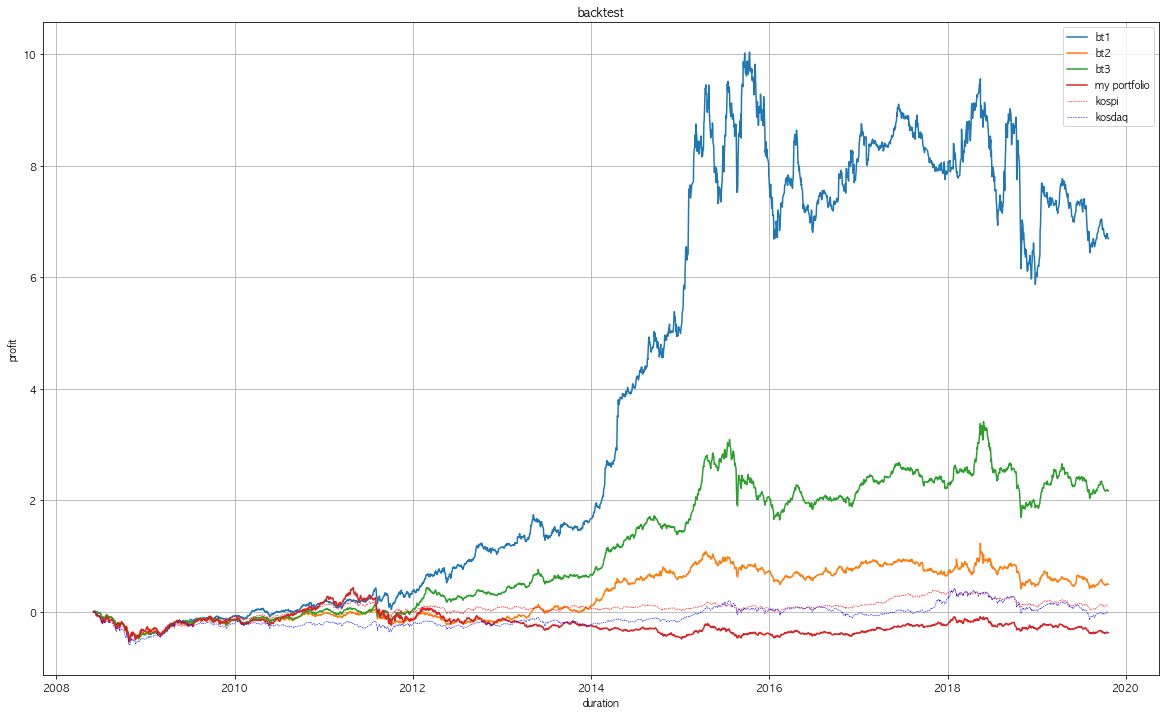

In [50]:
plt.rc('font', size=10)
plt.figure(figsize=(20, 12))
plt.plot(bt1.index, bt1['total_change_rate'], label='bt1')
plt.plot(bt2.index, bt2['total_change_rate'], label='bt2')
plt.plot(bt3.index, bt3['total_change_rate'], label='bt3')
plt.plot(my.index, my['total_change_rate'], label='my portfolio')
plt.plot(kospi_df.index, kospi_df['total_change_rate'], label='kospi', color='red',linewidth=0.5, linestyle='dashed')
plt.plot(kosdaq_df.index, kosdaq_df['total_change_rate'], label='kosdaq', color='blue',linewidth=0.5, linestyle='dashed')
plt.title('backtest')
plt.xlabel("duration")
plt.ylabel("profit")
plt.legend(loc='upper right')
plt.grid()
plt.show()